##### The University of Melbourne, School of Computing and Information Systems

**COMP30027 Machine Learning, 2022 Semester 1**

---

# **Assignment 2:** Sentiment Classification of Tweets

---

In [1]:
## Import all necessary modules for (Needed Installations Flagged):
# general use
import pandas as pd # INSTALL NEEDED
from collections import Counter
import numpy as np # INSTALL NEEDED
from scipy.sparse import csr_matrix, hstack # INSTALL NEEDED
# plotting
import matplotlib.pyplot as plt # INSTALL NEEDED
from wordcloud import WordCloud # INSTALL NEEDED
# feature extraction
import re
from sklearn.feature_extraction import DictVectorizer # INSTALL NEEDED
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # INSTALL NEEDED
import nltk # INSTALL NEEDED
nltk.download('stopwords')
from nltk.corpus import stopwords # INSTALL NEEDED
NLTK_STOPWORDS = list(stopwords.words())
from nltk.stem import PorterStemmer # INSTALL NEEDED
import pronouncing # INSTALL NEEDED
# classification
# classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # INSTALL NEEDED
from sklearn.linear_model import LogisticRegression # INSTALL NEEDED
from sklearn.tree import DecisionTreeClassifier # INSTALL NEEDED
from sklearn.neighbors import KNeighborsClassifier # INSTALL NEEDED
from sklearn.svm import SVC, LinearSVC # INSTALL NEEDED
from sklearn.dummy import DummyClassifier # INSTALL NEEDED
from sklearn.ensemble import BaggingClassifier # INSTALL NEEDED
# evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# set the plot font sizes
# ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Travers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Raw Data Analysis

A shallow analysis of the dataset.

### Importing the data

In [2]:
train_df = pd.read_csv("../data/Train.csv", sep=',')
test_df = pd.read_csv("../data/Test.csv", sep=',')

### Basic Information
Specifically the types of the data and the lengths of each set.

In [3]:
# get information about types in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [4]:
# get information about types in the testing set
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6099 non-null   int64 
 1   text    6099 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


### Inspecting Instances 
To verify what they look like when `pandas` imports them.

In [5]:
# inspect the head of the training information
train_df.head()

Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  
0   doctors hit campaign trail as race to medical...   neutral  
1   is anybody going to the radio station tomorro...  positive  
2   i just found out naruto didn't become the 5th...   neutral  
3   "prince george reservist who died saturday ju...   neutral  
4   season in the sun versi nirvana rancak gak..s...  positive

In [6]:
# inspect the head of the testing information
test_df.head()

id                                               text
0  802217876644052000   @loogunda @poroshenko putin abducted ukrainia...
1  802425296955682000   if putin wanted to intervene all he would hav...
2  805664502515662000   @hillbuzz @gaypatriot elsewhere in progland.....
3  639928670103015000   any females copping the gucci foamposites tom...
4  673824182287904000   "in other news, had a great saturday on the t...

In [7]:
# show a random sample from the training information
train_df.sample(5)

Unnamed: 0                  id  \
3475         4433  640987764721360000   
3353         4282  802372718985285000   
991          1268  802091605566091000   
4456         5689  622816698698178000   
21070       26957  636944757667663000   

                                                    text sentiment  
3475     if youre going to the shawn concert on oct 16\t   neutral  
3353    watching this cabinet take shape i'm wonderin...   neutral  
991     @poroshenko signs decree on granting #israelf...   neutral  
4456    "paul dunne's gonna puke on the first tee tom...   neutral  
21070  what if frank ocean drops his tomorrow on the ...   neutral

In [8]:
# show a random sample from the testing information
test_df.sample(5)

id                                               text
586   639829487429906000   forgot it was friday. wearing tom brady jerse...
2436  629721423557230000   trying to finish reading paper towns so that ...
5075  635979208754376000   "just looked up foo fighters set list for tom...
6003  666032917341192000   if the retaliation to friday is more destruct...
4725  641660106678013000   join us tomorrow for national hot dog day at ...

### Distribution of Sentiments

There may be a majority sentiment in the `Train.csv`.

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


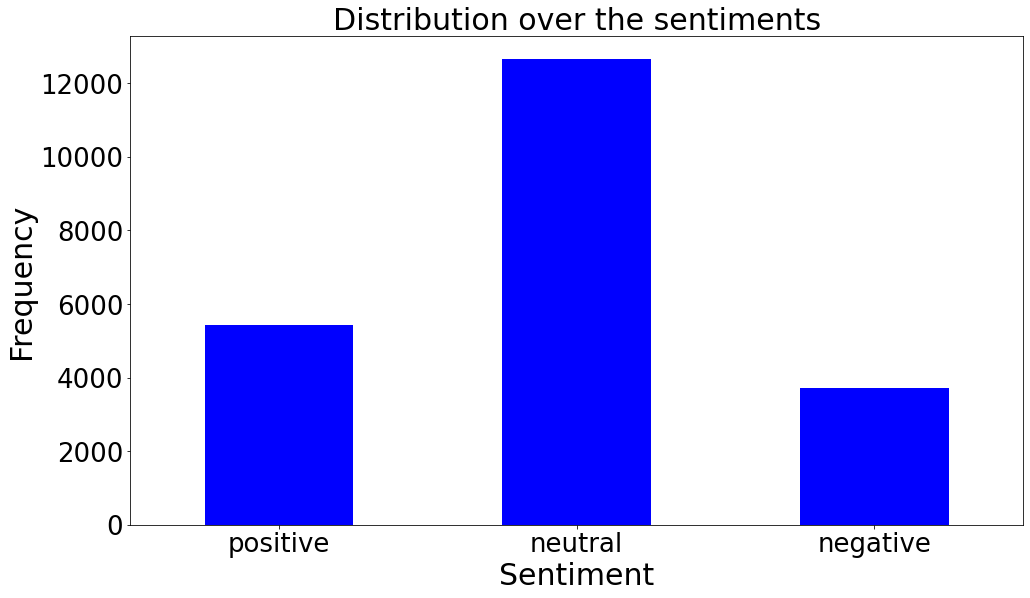

In [9]:
# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))

# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

## 2. Data Preprocessing

Functionality for cleaning the text data

### Cleaning Functionality
A simple cleaning function for the data with modifiable features.

In [10]:
## pre-cache the regex
# common tweet feature regex
RE_LINKS = re.compile(r'https?://t.co/\w*')
RE_HASHTAGS = re.compile(r'(?<=\W)#\w*[a-z]\w*')
RE_MENTIONS = re.compile(r'(?<=\W)@\w+')
# other re
RE_REPEATED_CONSECUTIVES = re.compile(r'(.)\1+')
RE_NUMBERS = re.compile(r'\d+')
RE_NON_ALPHANUMERIC = re.compile(r'[^a-z]+')
RE_PUNCTUATION = re.compile(r'[\.?!,:;\-()\[\]{}"\'/]')

# list of different terms to clean
DEFAULT_CLEAN_DICT = {
    'links': True,
    'hashtags': True,
    'mentions': True,
    'numbers': True,
    'non-alphanumeric': True,
    'repeated-consecutive': True,
    'stopwords': None, # removing stopwords
}

# a function to selectively clean different terms within tweets
def clean_tweet(tweet: str, remove: dict = DEFAULT_CLEAN_DICT) -> str:
    new_tweet = tweet
    re_stopwords = ''
    if remove['stopwords'] is not None: 
        re_stopwords = re.compile(r'\b(' + r'|'.join(remove['stopwords']) + r')\b\s*')
    if remove['links']: new_tweet = RE_LINKS.sub(' ', new_tweet)
    if remove['hashtags']: new_tweet = RE_HASHTAGS.sub(' ', new_tweet)
    if remove['mentions']: new_tweet = RE_MENTIONS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['repeated-consecutive']: new_tweet = RE_REPEATED_CONSECUTIVES.sub(r'\1\1', new_tweet)
    if remove['numbers']: new_tweet = RE_NUMBERS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['non-alphanumeric']: 
        new_tweet = RE_NON_ALPHANUMERIC.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)

    # remove unnecessary space characters
    new_tweet = re.sub(r' +', ' ', new_tweet)
    new_tweet = re.sub(r'^ | $', '', new_tweet) # bookend spaces
    return new_tweet

# apply the default cleaning function to the training and test sets
train_df['text-clean-no-stopwords'] = train_df['text'].apply(clean_tweet)
test_df['text-clean-no-stopwords'] = test_df['text'].apply(clean_tweet)

# inspect a sample of the training information and compare the clean and raw tweets
train_df.sample(5)

### Identifying Stopwords
Words with little value to be removed

In [ ]:
# start the wordcloud object here
wc = WordCloud(max_words=750, width=1920, height=1080)

# a function to display and save a named word cloud
def show_save_word_cloud(text, filename):
    cloud = wc.generate(text)
    plt.figure(figsize= (16, 9), frameon=False)
    plt.axis('off')
    print(f'Word cloud for {filename}')
    plt.imshow(cloud)
    plt.savefig(f'../report/img/wc/{filename}', bbox_inches='tight')

# show and save the wc for train, test, all
if False: # this code hangs sometimes, so change this to run it again
    # show_save_word_cloud(" ".join(train_df['text-clean-default']), 'train-clean-default')
    # show_save_word_cloud(" ".join(test_df['text-clean-default']), 'test-clean-default')
    show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']) + " " + " ".join(test_df['text-clean-no-stopwords']), 
        'text-clean-no-stopwords')

    # generate the wc for `positive`, `neutral` and `negative` instances only
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']),
        f'{sentiment}-clean-no-stopwords')

In [ ]:
# NLTK's stopword list is most applicable (+ add stuff from re-analysis)
FINAL_STOPWORDS = ['amp', 'may', 'th', 'st'] + NLTK_STOPWORDS

# apply the cleaning with the different stopword lists
cleanConfig = DEFAULT_CLEAN_DICT.copy()
cleanConfig['stopwords'] = NLTK_STOPWORDS
train_df['text-clean-nltk'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean-nltk'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
cleanConfig['stopwords'] = FINAL_STOPWORDS
train_df['text-clean'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))

FINAL_CLEAN_CONFIG = cleanConfig

# generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
if False: # this code hangs sometimes, so change this to run it again
    show_save_word_cloud(" ".join(train_df['text-clean-nltk']) + " " + " ".join(test_df['text-clean-nltk']), 
        'all-clean-nltk')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-nltk']),
        f'{sentiment}-clean-nltk')

    # generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
    show_save_word_cloud(" ".join(train_df['text-clean']) + " " + " ".join(test_df['text-clean']), 
        'all-clean-final')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean']),
        f'{sentiment}-clean-final')

# compare the differences
train_df.sample(5)

Unnamed: 0                  id  \
17345       22155  638503786109997000   
19225       24477  630468116884127000   
4881         6214  802193226094481000   
6635         8431  638140427691028000   
10353       13227  802157135643766000   

                                                    text sentiment  \
17345   "come try #ringette for free sat sept 12, 11-...   neutral   
19225  @mkgoblue @kysandy / monday night football was...  positive   
4881    regrann from jpusbrasil  -  @ricky_martin #ma...  positive   
6635    not sleeping till i see nicki first day of sc...  positive   
10353   @elizabethforma, please step to the front. ht...   neutral   

                                 text-clean-no-stopwords  \
17345  come try for free sat sept the prince george c...   
19225  mkgoblue monday night football was must see tv...   
4881                             regrann from jpusbrasil   
6635   not sleeping till i see nicki first day of sch...   
10353                           please step to the front   

                                         text-clean-nltk  \
17345      try free sat sept prince george coliseum info   
19225  mkgoblue monday night football must see tv bac...   
4881                                  regrann jpusbrasil   
6635   sleeping see nicki first day school tomorrow g...   
10353                                  please step front   

                                              text-clean  
17345      try free sat sept prince george coliseum info  
19225  mkgoblue monday night football must see tv bac...  
4881                                  regrann jpusbrasil  
6635   sleeping see nicki first day school tomorrow g...  
10353                                  please step front

## 3. Vectorizers
Three transformers are going to be used `TfidfVectorizer`, `CountVectorizer` and `DictVectorizer`.
The following is code to compare the different features produced on a bar graph (showing those most influential).

In [ ]:
# define the colours for the different sentiment sets
SENTIMENT_COLOURS = {
    'all': 'orange',
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

# create a bar graph (and save it)
def show_save_bar_graph(plot, X:csr_matrix, y: list[str], features: list[str], 
        feature_type: str, sentiment: str, sort_type: str='relative', 
        max_features: int|None=10, labels=False, save=False):

    # ensure the max features are not higher than the length
    if max_features > len(features) or max_features == None: 
        max_features = len(features)
    # fill the value list for the bars
    values = np.zeros((len(features)))
    sums = np.zeros((len(features)))
    for idx, f in enumerate(features):
        all_entries = X[:, idx]
        s_entries = all_entries[y == sentiment]
        sums[idx] = np.sum(all_entries)
        if sentiment == 'all': 
            values[idx] = np.sum(all_entries) / len(y)
        elif sort_type == 'relative':
            values[idx] = np.sum(s_entries) / np.sum(all_entries)
        else:
            values[idx] = np.sum(s_entries) / len(y[y == sentiment])
    values_sums_names = sorted(zip(values, sums, features), reverse=True)[:max_features]
    values = [vn[0] for vn in values_sums_names]
    features = [vn[2] for vn in values_sums_names]
    plot.bar(range(max_features), values, color=SENTIMENT_COLOURS[sentiment])
    if labels:
        plot.xlabel(f'Top {max_features} Features',) 
        plot.ylabel(f'{sort_type} Value',) 
    plot.set_xticks(range(max_features))
    plot.set_xticklabels(features, rotation=45, ha='right')
    plot.set_title(f'{sentiment.upper()} {feature_type} Bar Graph')
    if save:
        plt.savefig(f'../report/img/bar/{sentiment}', bbox_inches='tight')


# create a method to generate 4 bar graphs for top features in a vector based on their relative sums
def compare_bars(X, y, features, feature_type: str, sort_type: str='relative', max_features: int|None=10):

    if max_features > len(features): max_features = len(features)
    f, axes = plt.subplots(1, 4)
    f.set_size_inches([32, 12])

    # set the labels
    f.supxlabel(f'Top {max_features} Features', va='baseline')
    f.supylabel(f'{sort_type.upper()} Value')
    f.suptitle(f'Comparing {feature_type} across sentiments')
    f.subplots_adjust(bottom=0.2, wspace=0.3)

    show_save_bar_graph(axes[0], X, y, features, '-', 'all', sort_type, max_features)

    for idx, sentiment in enumerate(['positive', 'neutral', 'negative']):
        show_save_bar_graph(axes[idx+1], X, y, features, '-', sentiment, sort_type, max_features)

    plt.savefig(f'../report/img/bar/compare-{feature_type}', bbox_inches='tight')


## 4. Tokenization

Implementing different forms of token/vector generation.

In [ ]:
# define the X dictionaries and y for the sentiments
X_train_features = dict()
X_test_features = dict()
y = train_df['sentiment']

# for the sake of comparison/testing, set the # of max features to smth low
MAX_FEATURES = 5000

### Words

KeyboardInterrupt: 

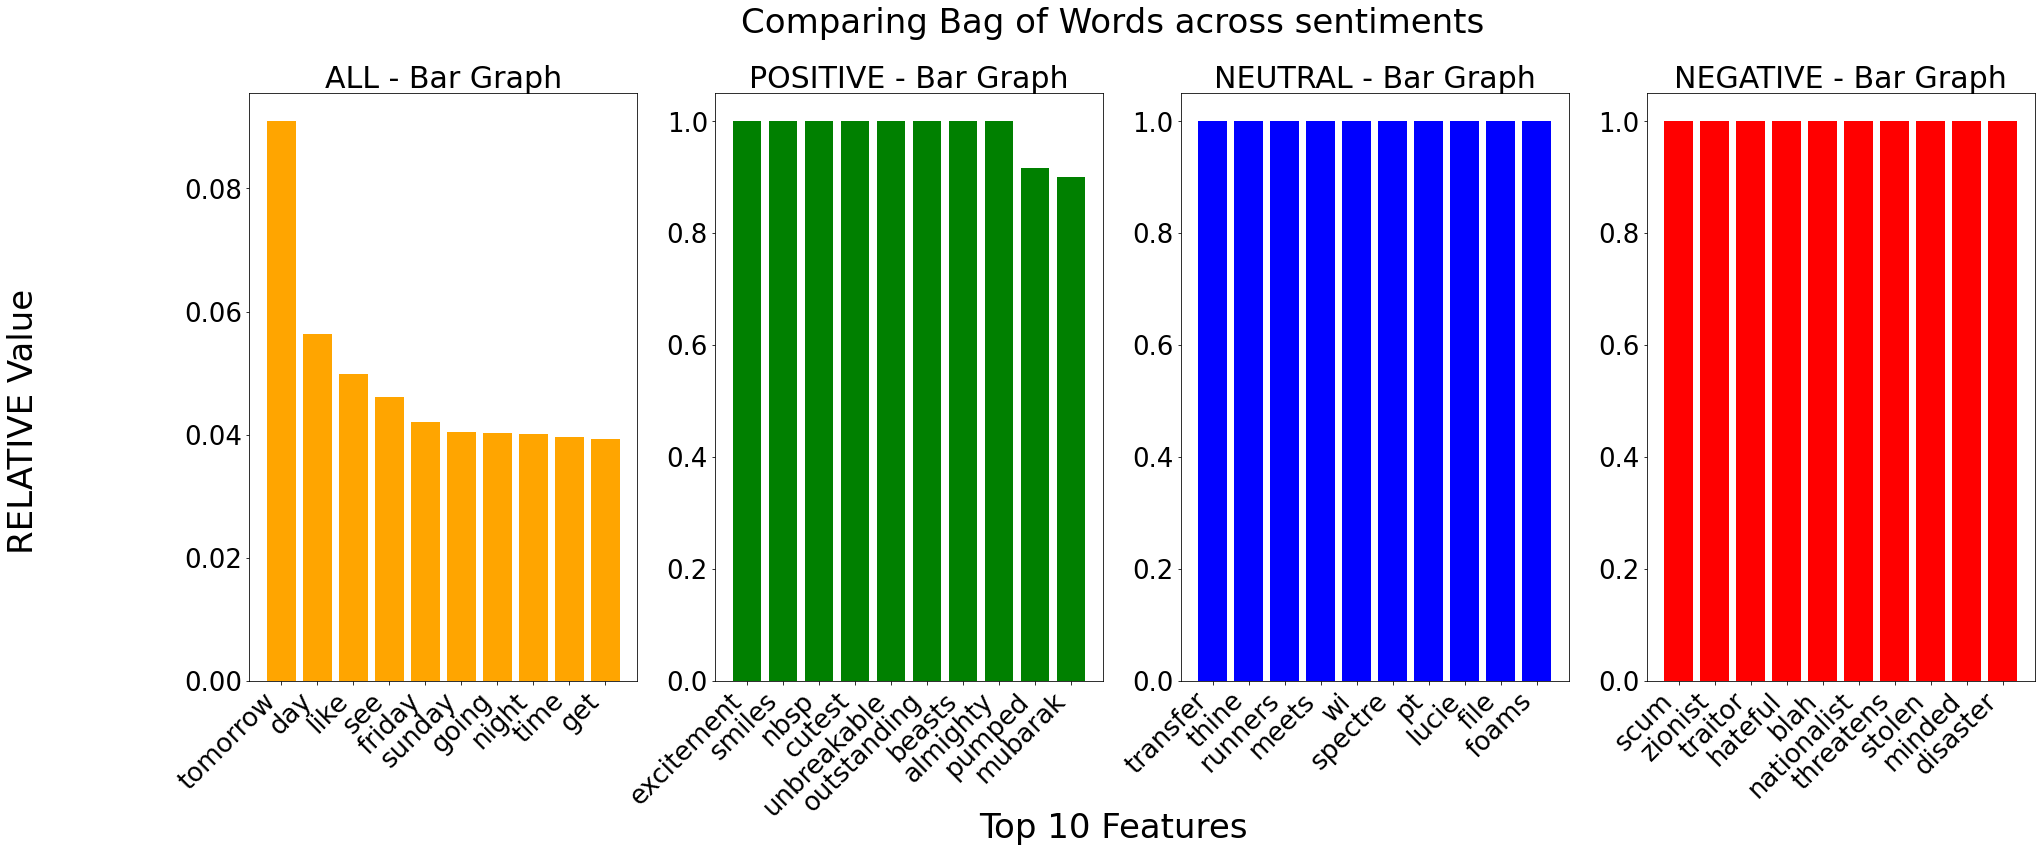

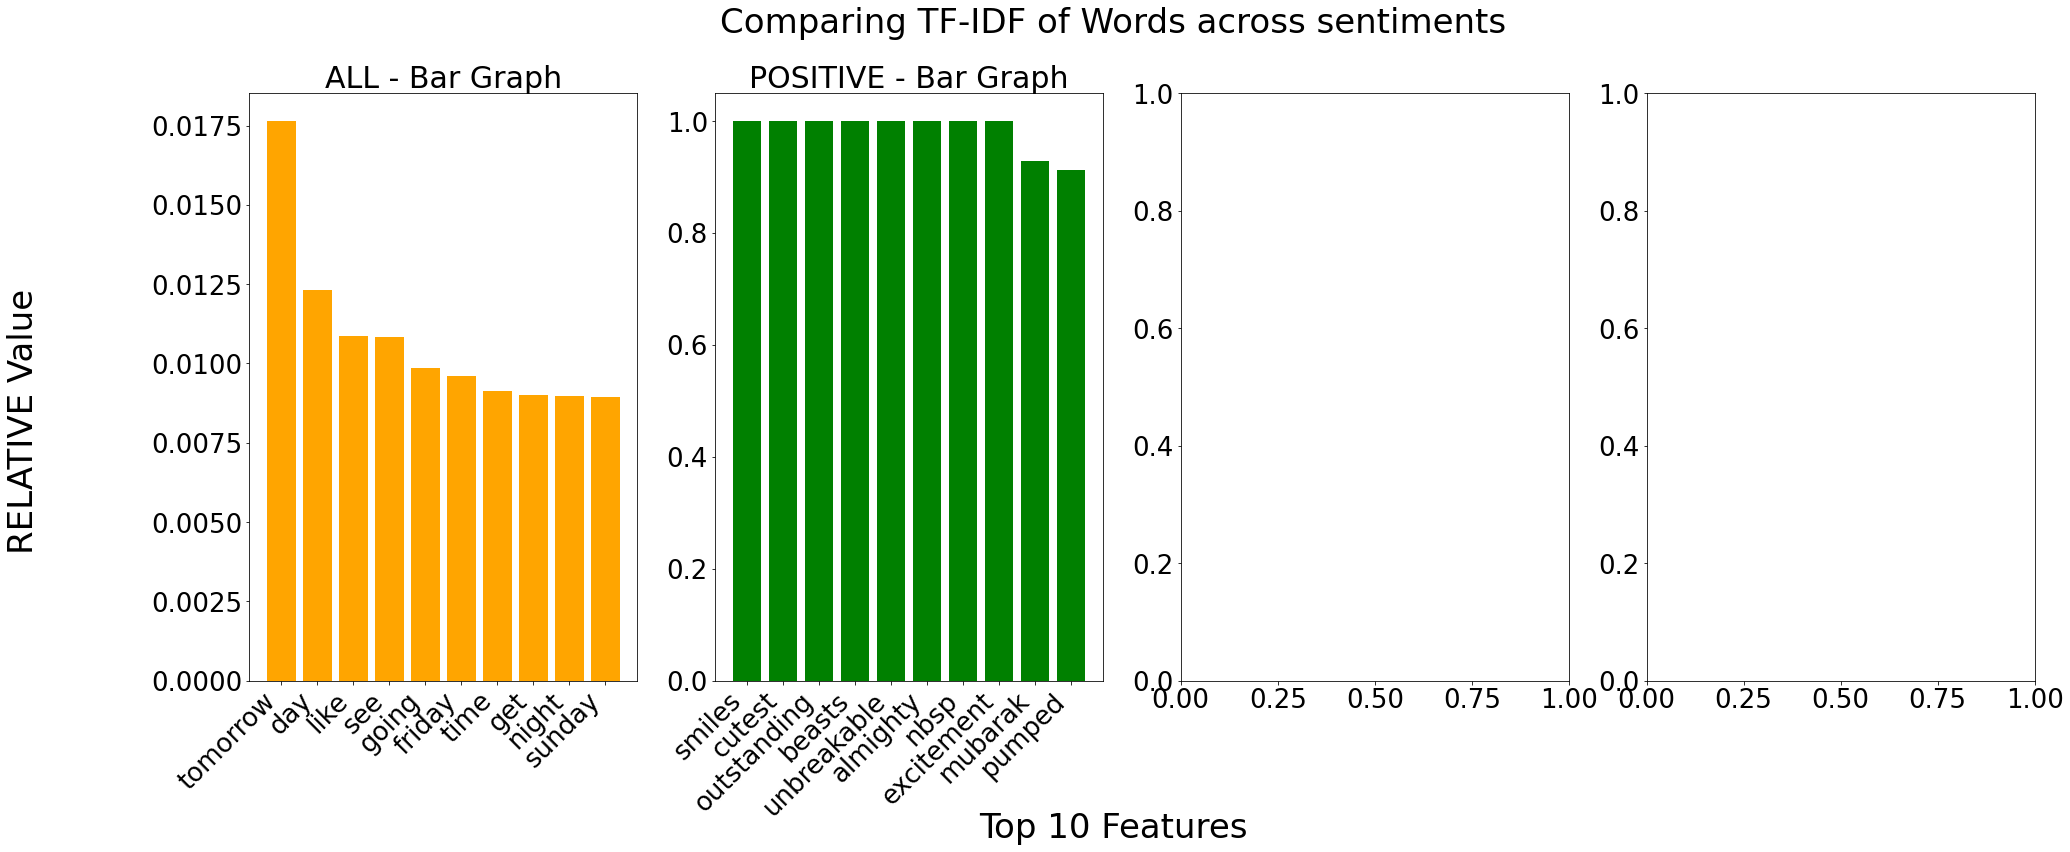

In [ ]:
# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORDS_COUNT = 'Bag of Words'
cv_w = CountVectorizer(max_features=MAX_FEATURES)
X_train_features[FEATURE_WORDS_COUNT] = cv_w.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORDS_COUNT] = cv_w.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORDS_COUNT], y, cv_w.get_feature_names_out(), FEATURE_WORDS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_WORDS_TFIDF = 'TF-IDF of Words'
tfidf_w = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_features[FEATURE_WORDS_TFIDF] = tfidf_w.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORDS_TFIDF] = tfidf_w.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORDS_TFIDF], y, tfidf_w.get_feature_names_out(), FEATURE_WORDS_TFIDF)

### Part-of-speech Tags

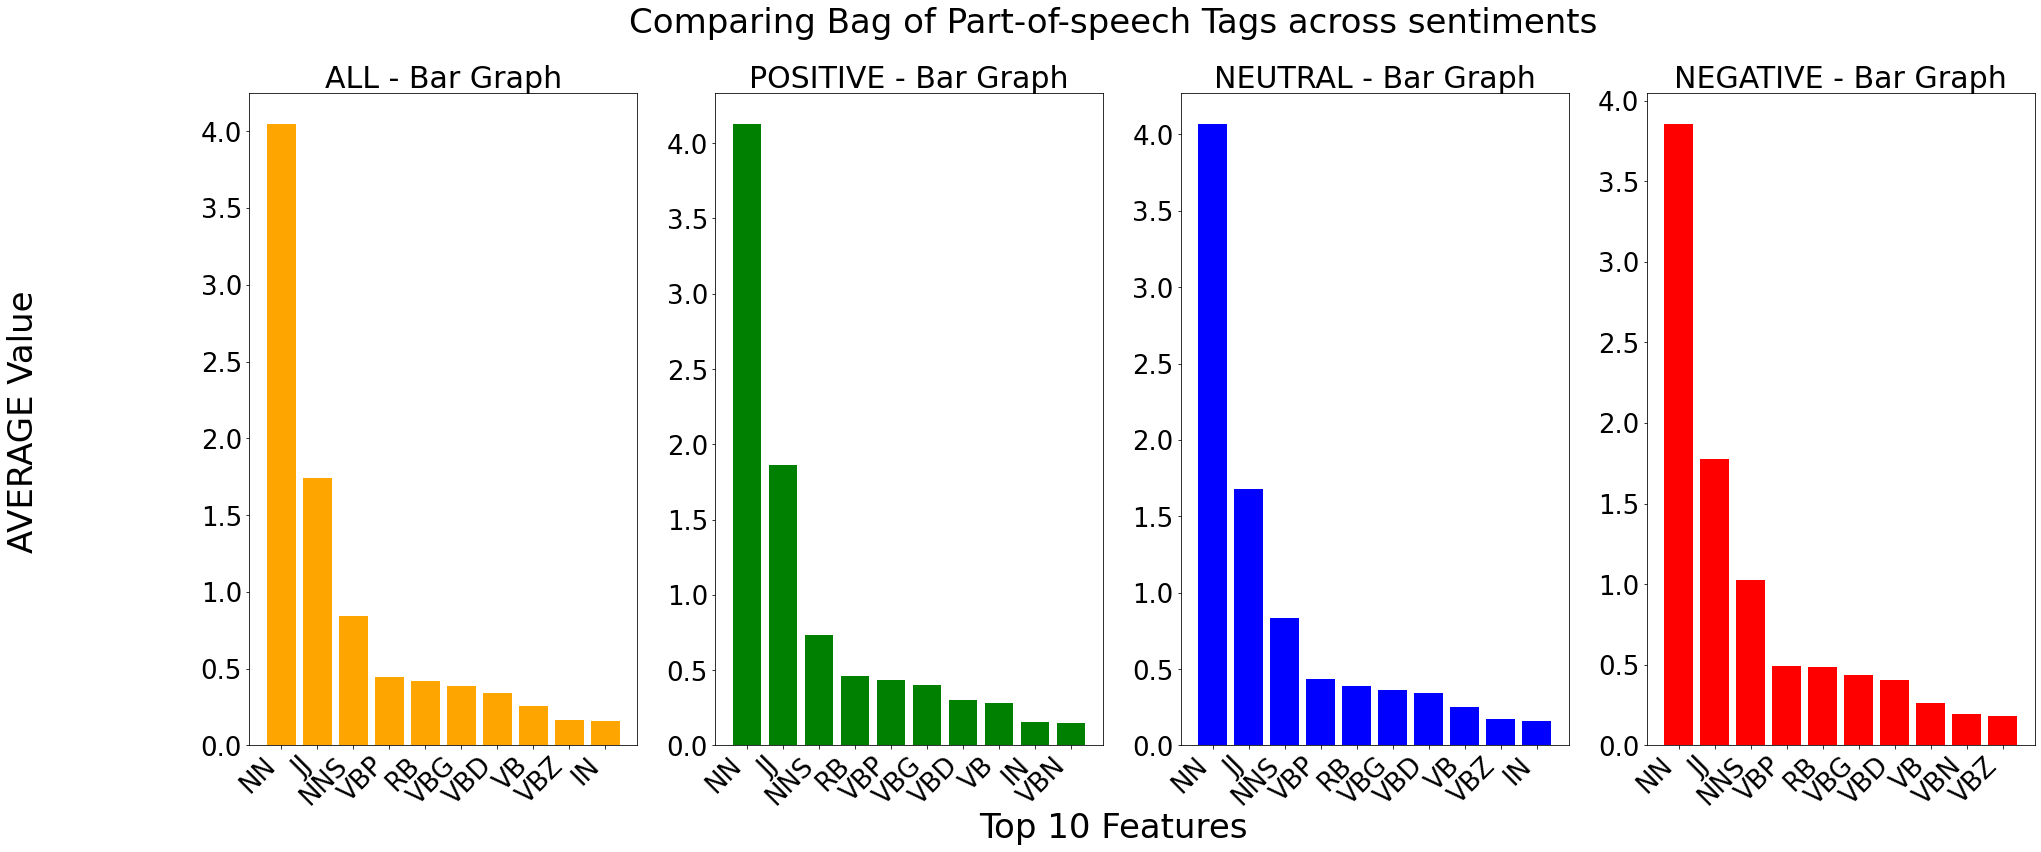

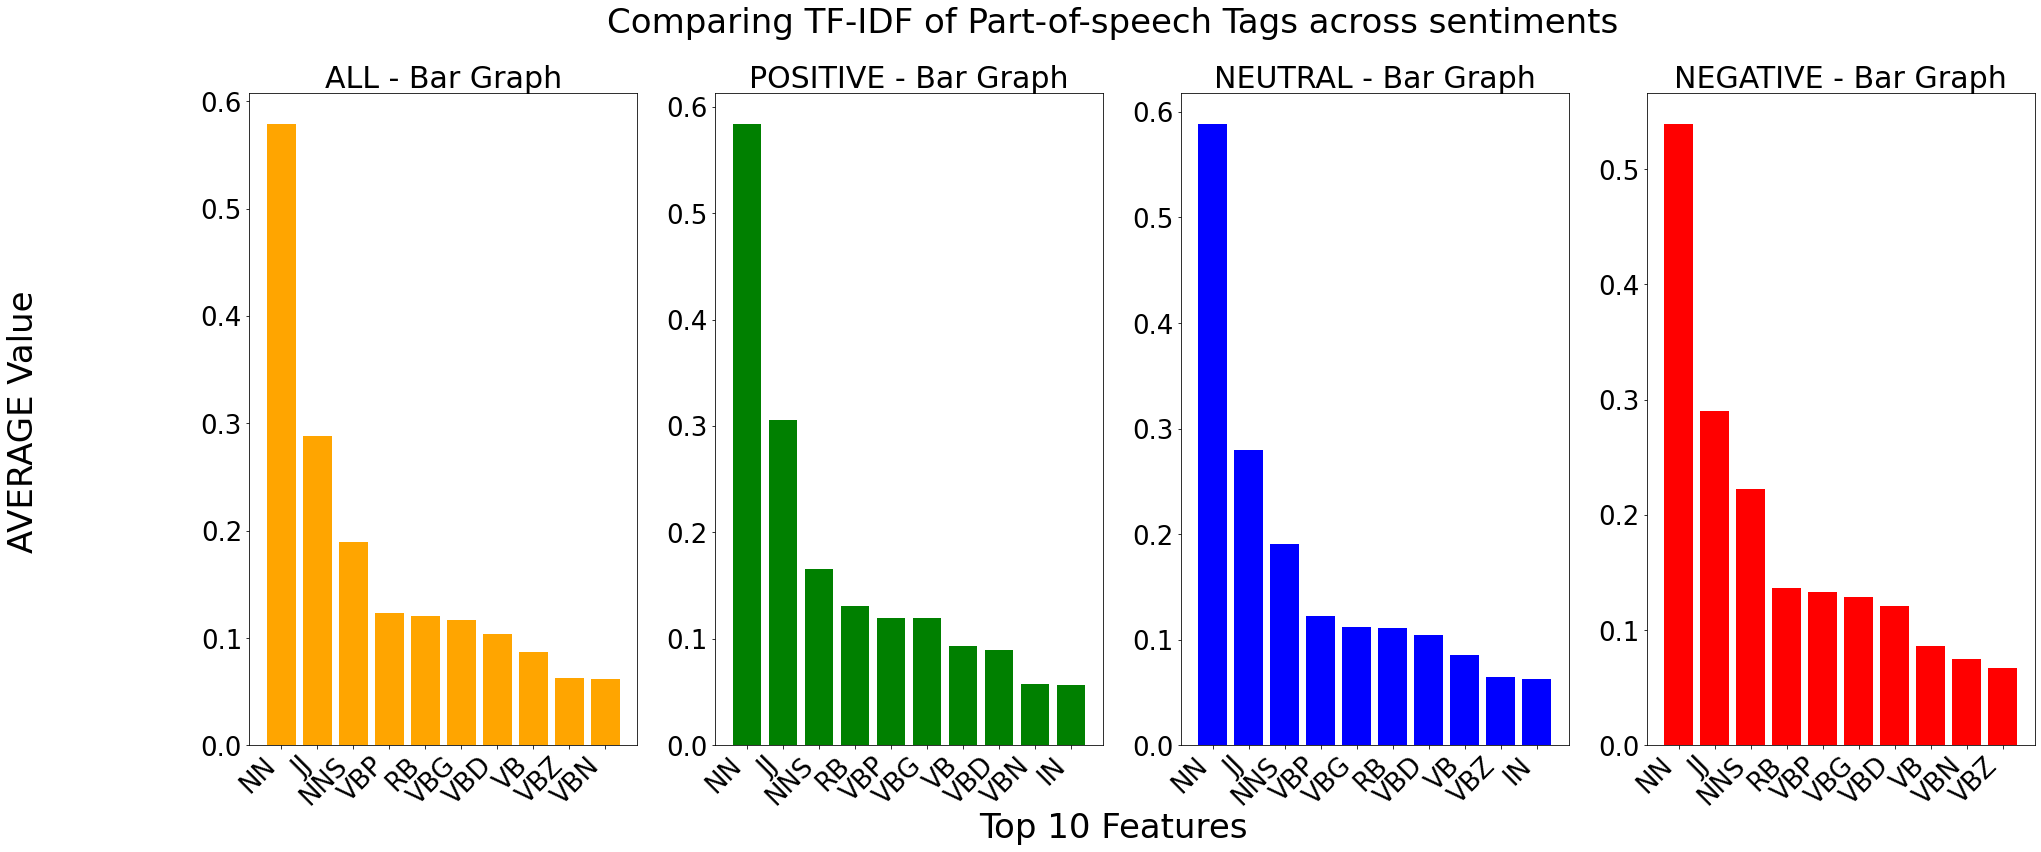

In [ ]:
# Define the tags list
def tokenizer_pos(tweet): return [t[1] for t in nltk.pos_tag(tweet.split(' '))]

# test the stemming split tokenization on the count/bag-of-words
FEATURE_POS_TAGS_COUNT = 'Bag of Part-of-speech Tags'
cv_pos = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
X_train_features[FEATURE_POS_TAGS_COUNT] = cv_pos.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_POS_TAGS_COUNT] = cv_pos.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_POS_TAGS_COUNT], y, cv_pos.get_feature_names_out(), FEATURE_POS_TAGS_COUNT)

# test the stemming split tokenization on the tf-idf
FEATURE_POS_TAGS_TFIDF = 'TF-IDF of Part-of-speech Tags'
tfidf_pos = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
X_train_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_POS_TAGS_TFIDF] = tfidf_pos.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_POS_TAGS_TFIDF], y, tfidf_pos.get_feature_names_out(), FEATURE_POS_TAGS_TFIDF)

### Stems

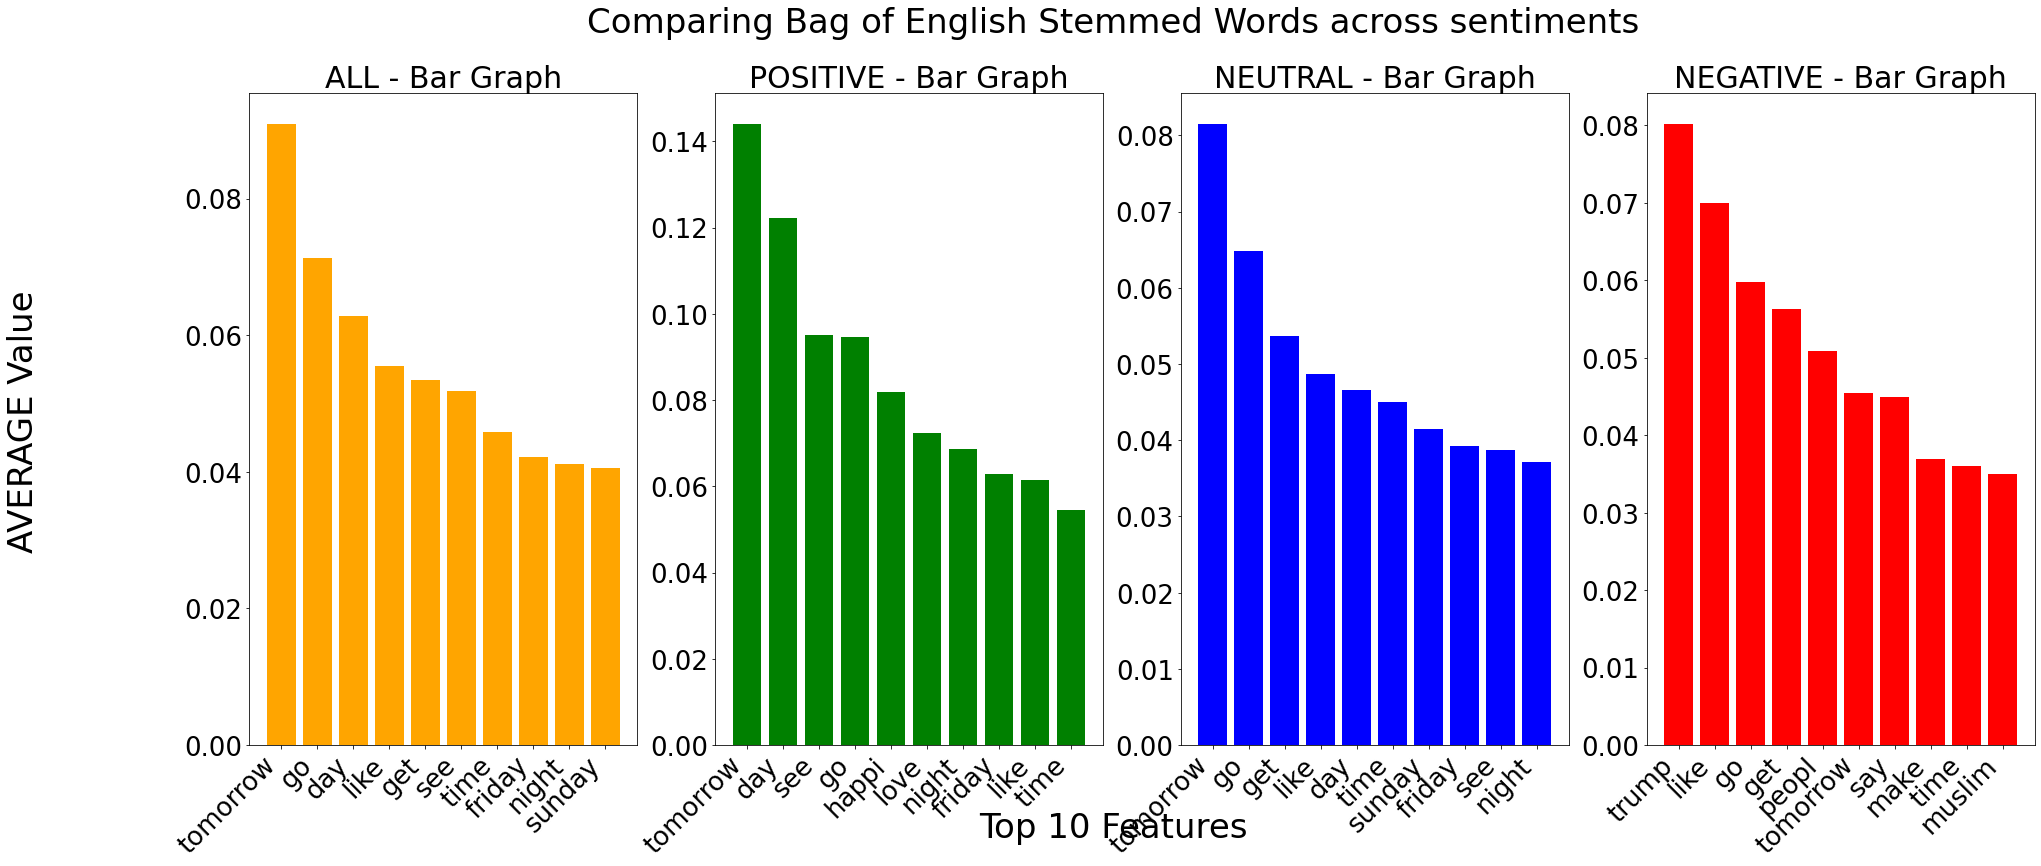

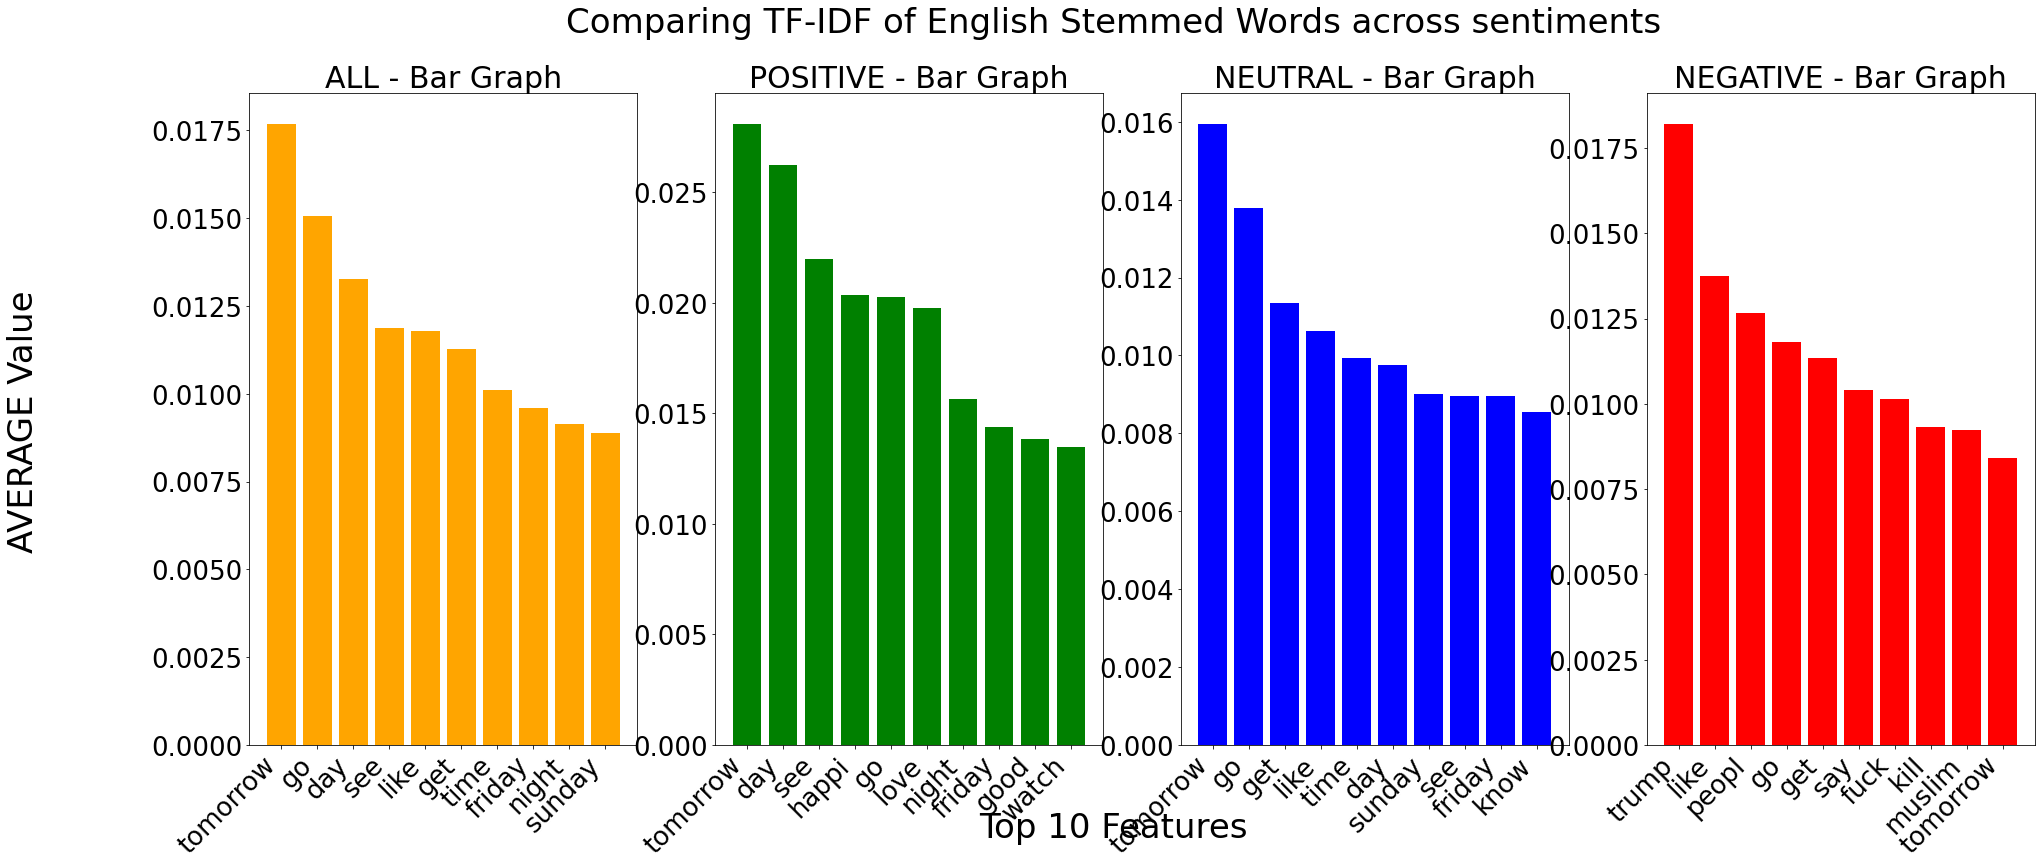

In [ ]:
if False: # stemming not needed
    # Porter Stemmer
    ps = PorterStemmer()
    def tokenizer_stem(tweet): return [ps.stem(w) for w in tweet.split(' ')]

    # test the stemming split tokenization on the count/bag-of-words
    FEATURE_STEMS_COUNT = 'Bag of English Stemmed Words'
    cv_ps = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEMS_COUNT] = cv_ps.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEMS_COUNT] = cv_ps.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEMS_COUNT], y, cv_ps.get_feature_names_out(), FEATURE_STEMS_COUNT)

    # test the stemming split tokenization on the tf-idf
    FEATURE_STEMS_TFIDF = 'TF-IDF of English Stemmed Words'
    tfidf_ps = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEMS_TFIDF] = tfidf_ps.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEMS_TFIDF] = tfidf_ps.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEMS_TFIDF], y, tfidf_ps.get_feature_names_out(), FEATURE_STEMS_TFIDF)

### 2-Grams

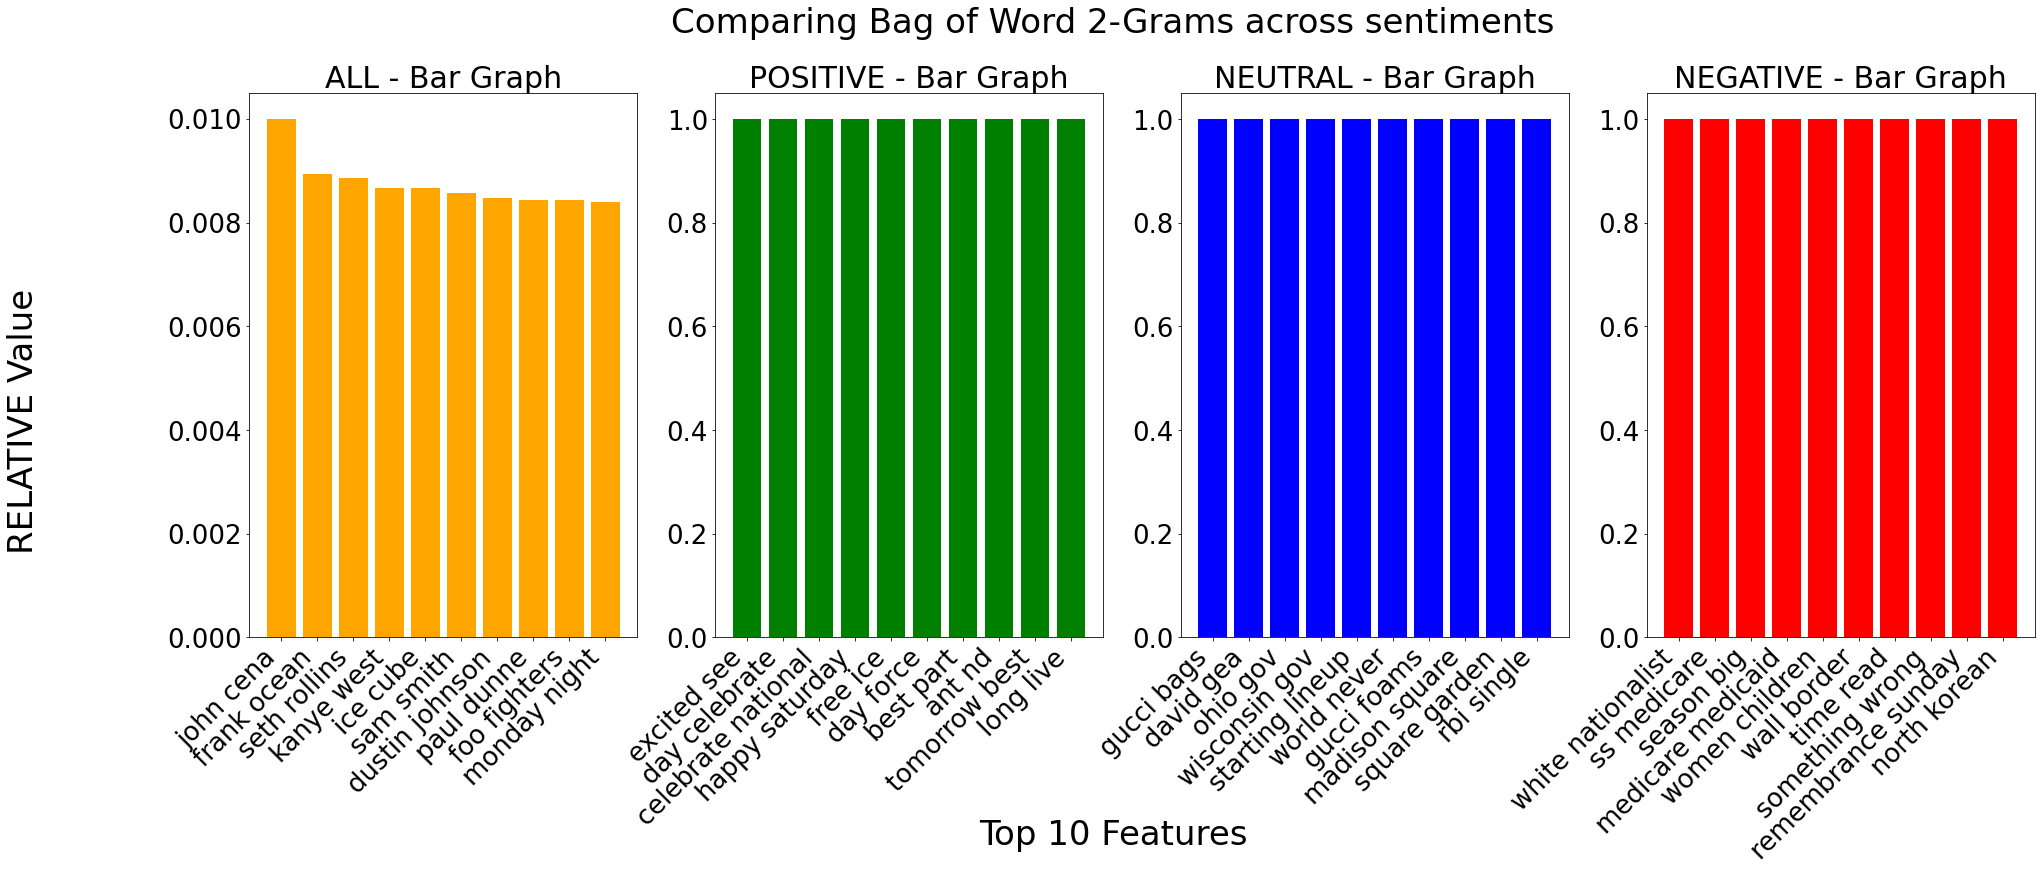

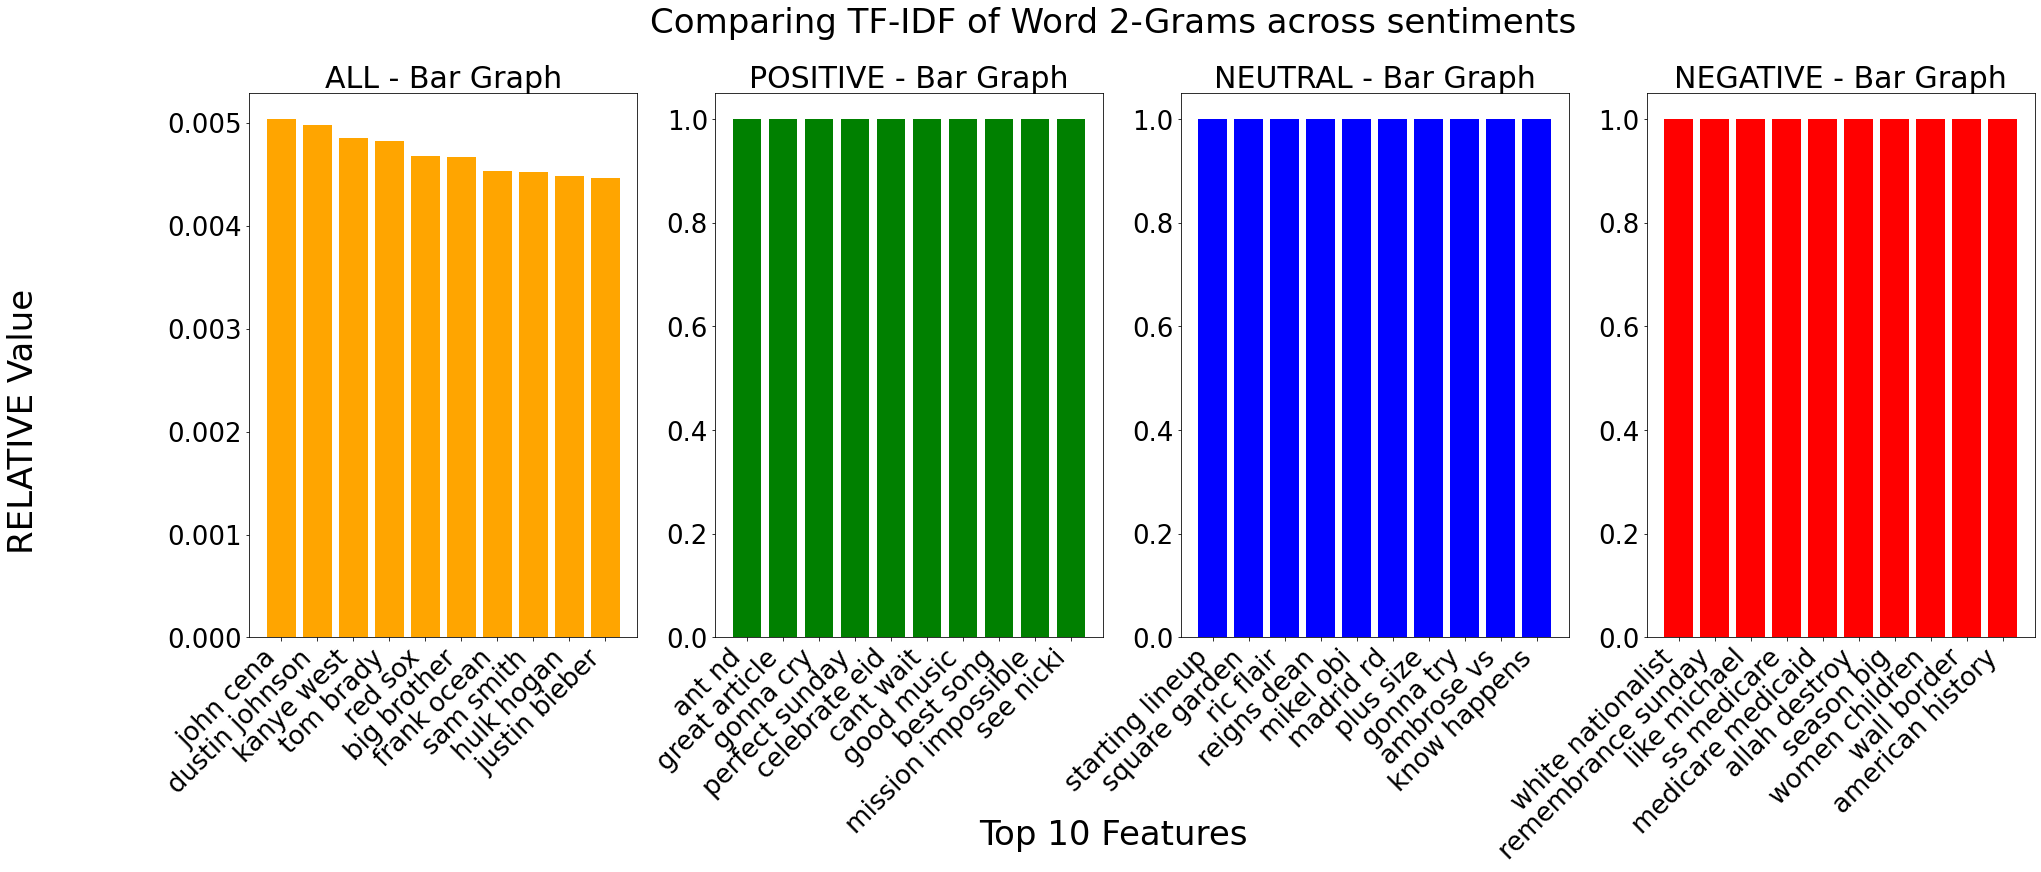

In [ ]:
# Test on occurrences
FEATURE_WORD_2GRAMS_COUNT = 'Bag of Word 2-Grams'
cv_word2g = CountVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
X_train_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_2GRAMS_COUNT] = cv_word2g.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_2GRAMS_COUNT], y, cv_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_COUNT)

# Test on tfidf
FEATURE_WORD_2GRAMS_TFIDF = 'TF-IDF of Word 2-Grams'
tfidf_word2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
X_train_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_2GRAMS_TFIDF] = tfidf_word2g.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_2GRAMS_TFIDF], y, tfidf_word2g.get_feature_names_out(), FEATURE_WORD_2GRAMS_TFIDF)

if False: # stemming not needed
    # tokenizer by stemming instead
    # Test on occurrences
    FEATURE_STEM_2GRAMS_COUNT = 'Bag of English Stemmed 2-Grams'
    cv_stem2g = CountVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEM_2GRAMS_COUNT] = cv_stem2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_COUNT], y, cv_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_COUNT)

    # Test on tfidf
    FEATURE_STEM_2GRAMS_TFIDF = 'TF-IDF of English Stemmed 2-Grams'
    tfidf_stem2g = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
    X_train_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.fit_transform(train_df['text-clean'])
    X_test_features[FEATURE_STEM_2GRAMS_TFIDF] = tfidf_stem2g.transform(test_df['text-clean'])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_TFIDF], y, tfidf_stem2g.get_feature_names_out(), FEATURE_STEM_2GRAMS_TFIDF)

### Characters

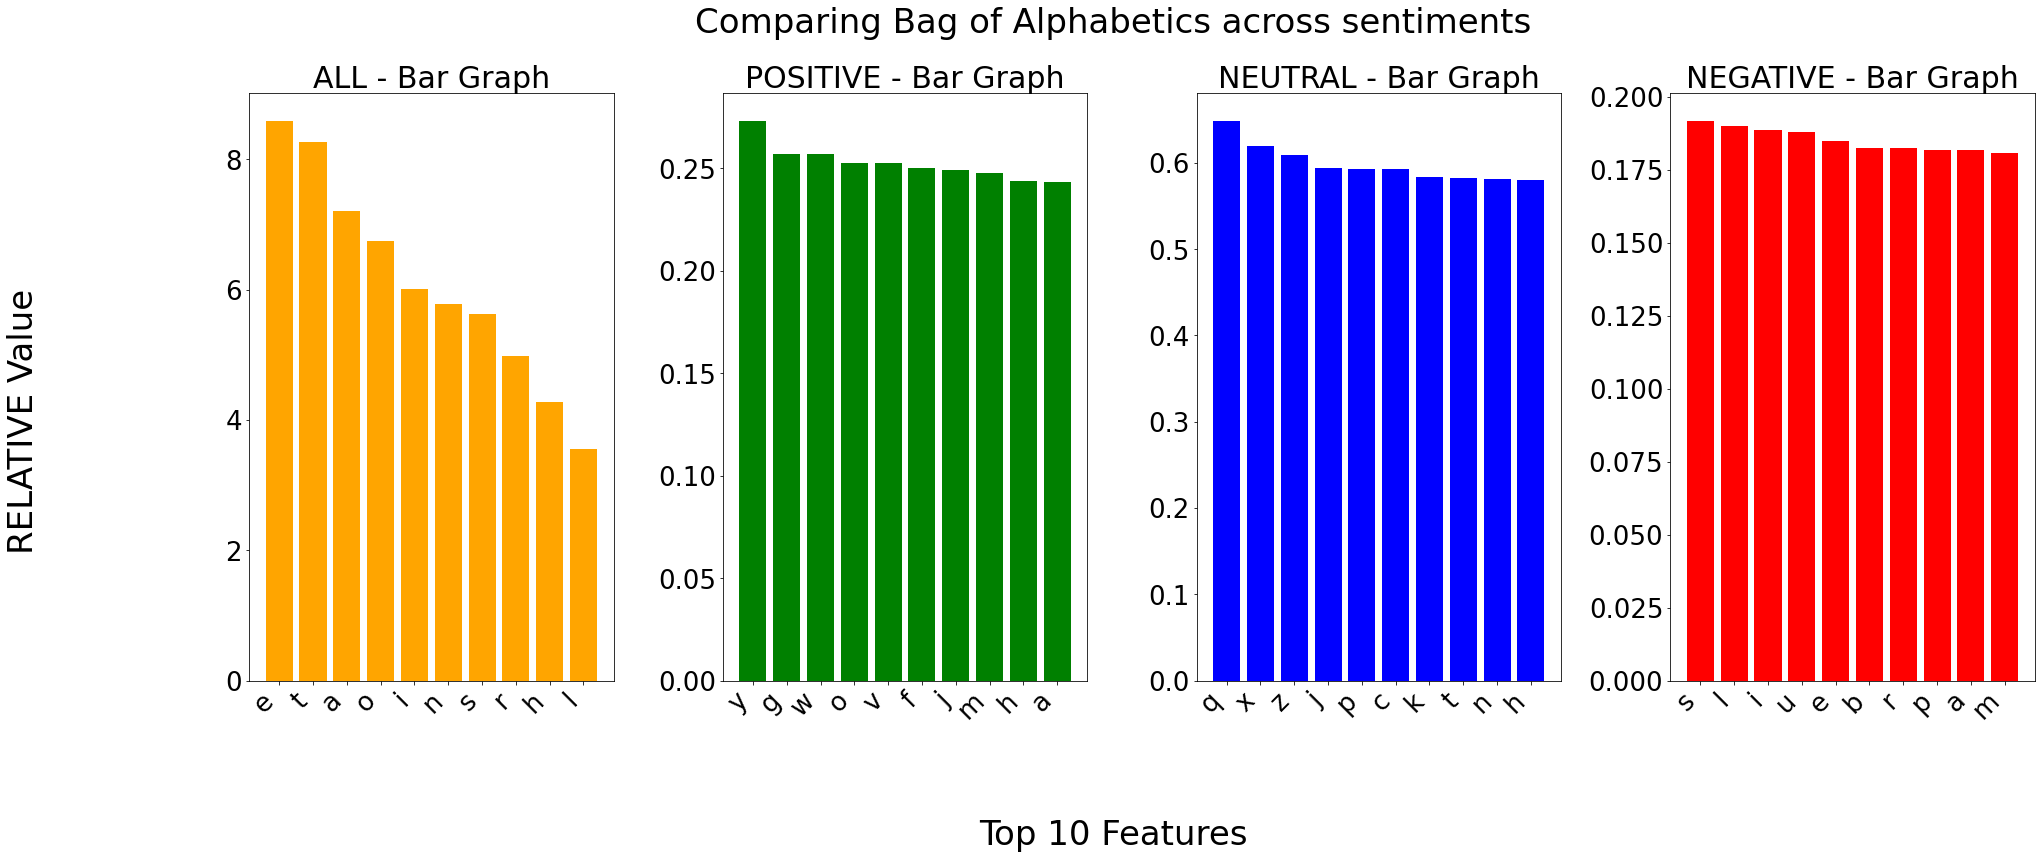

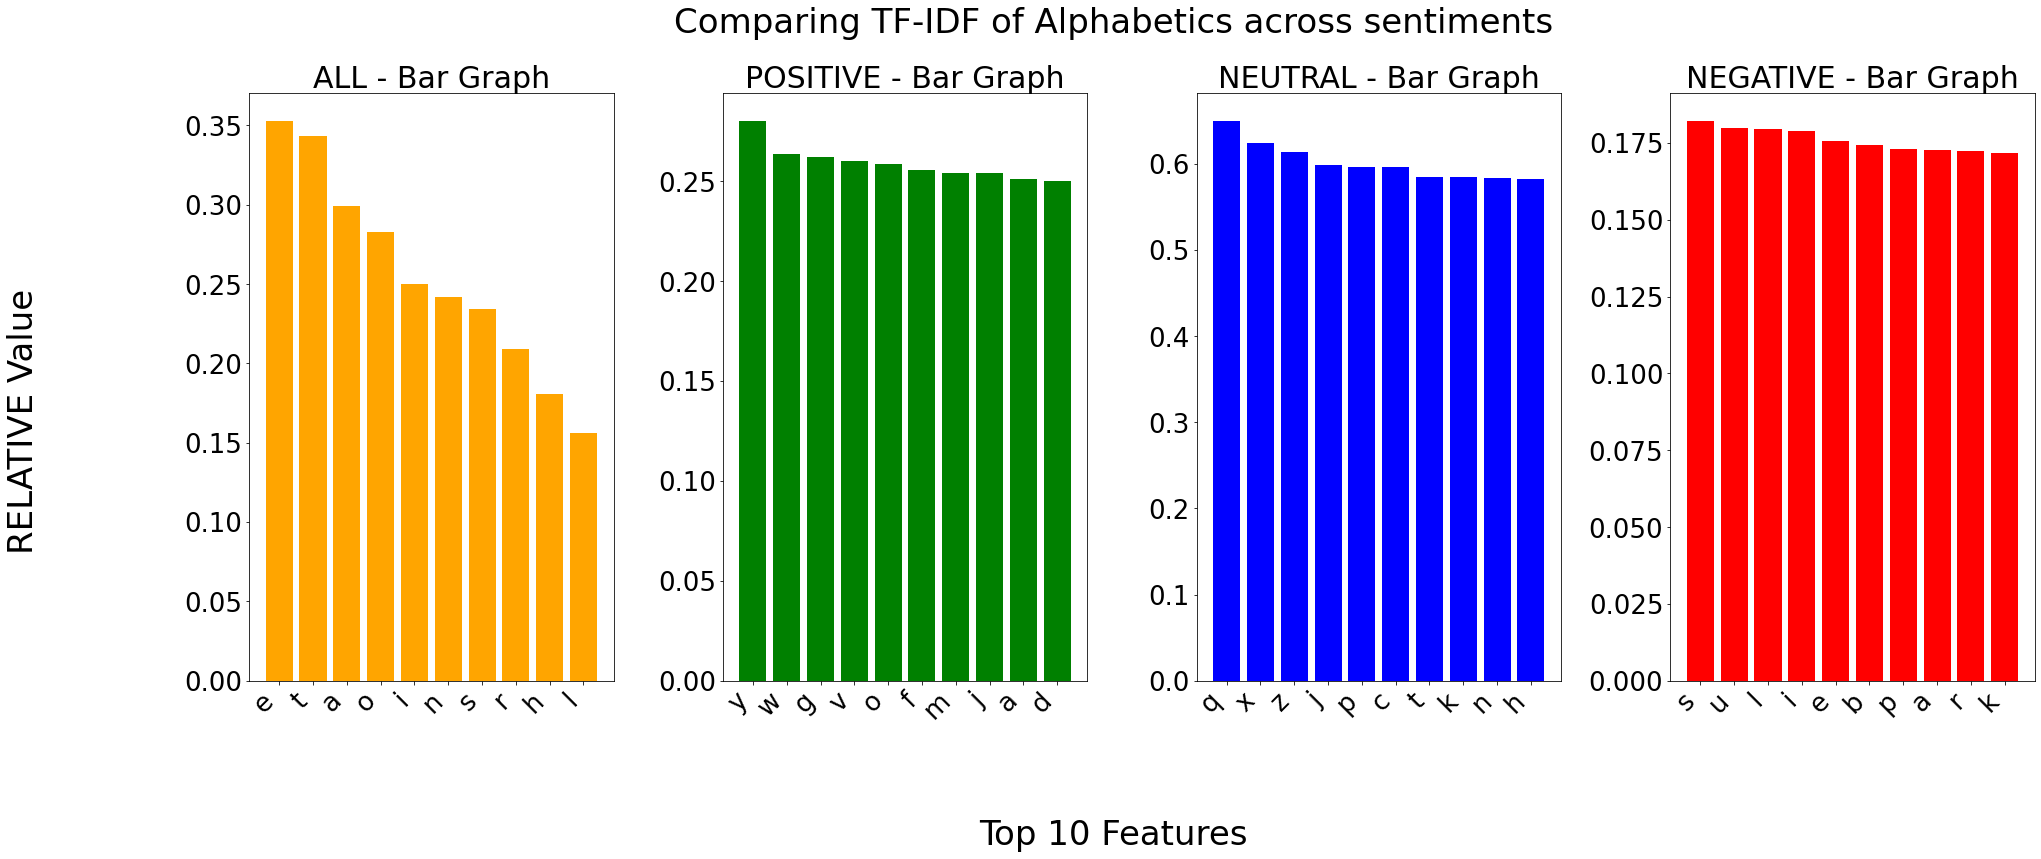

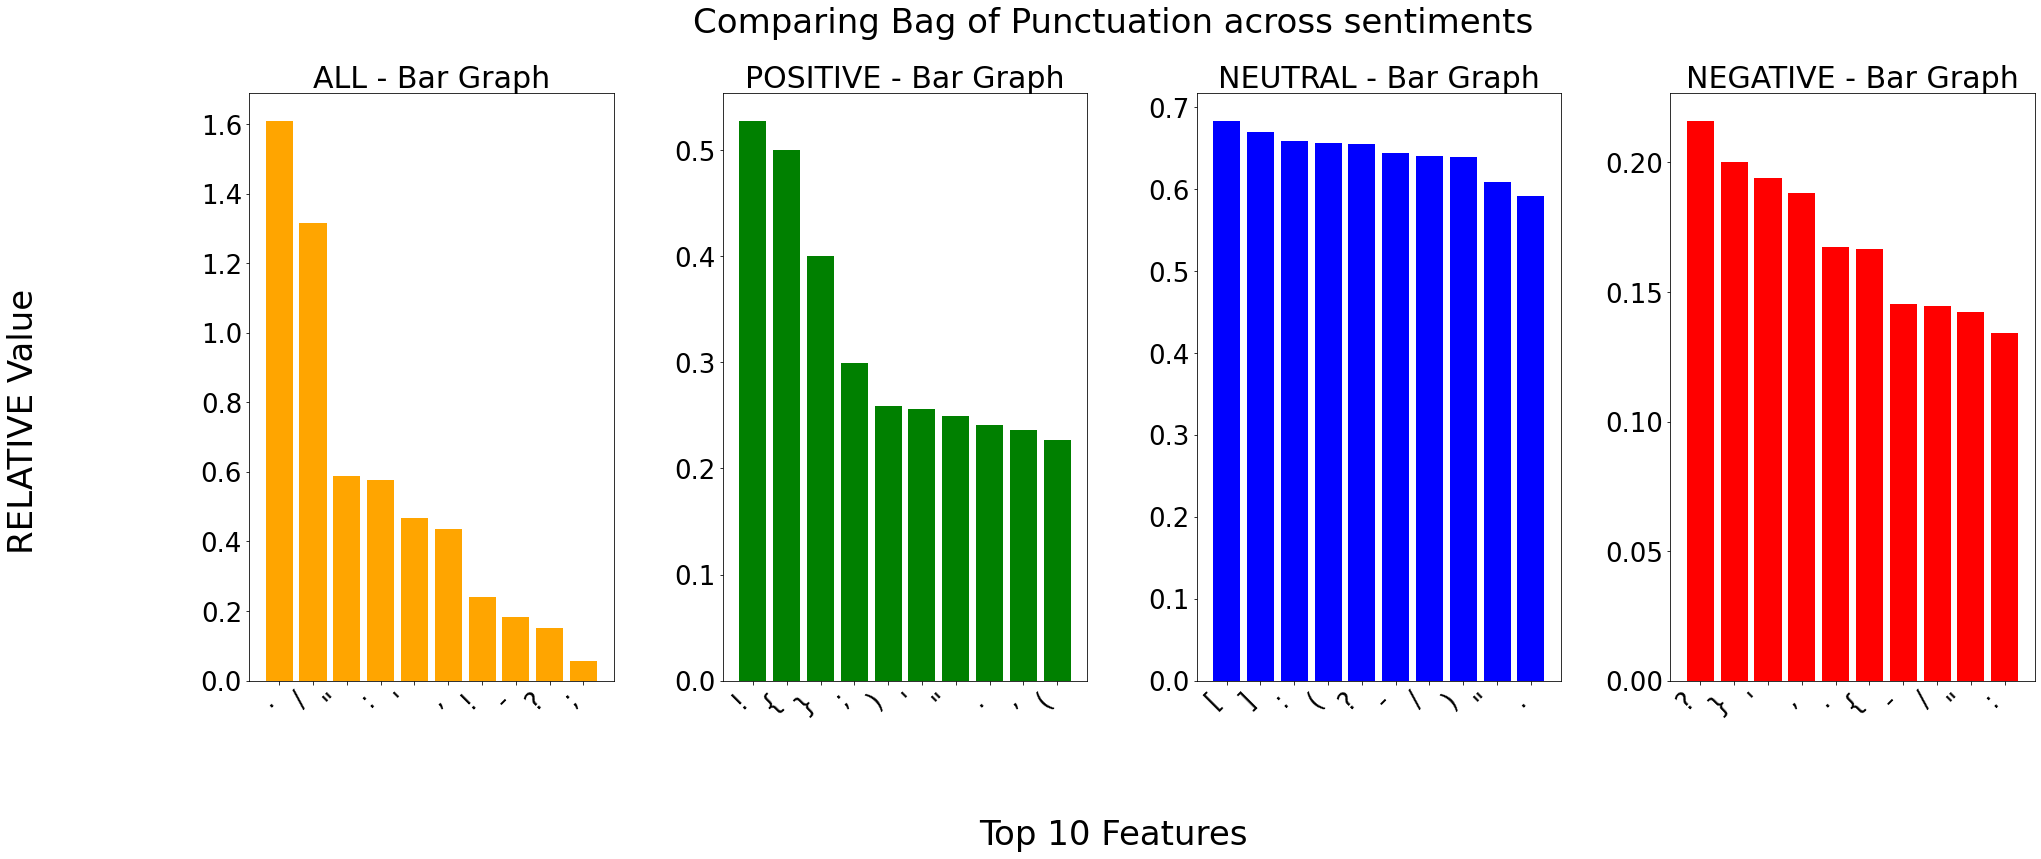

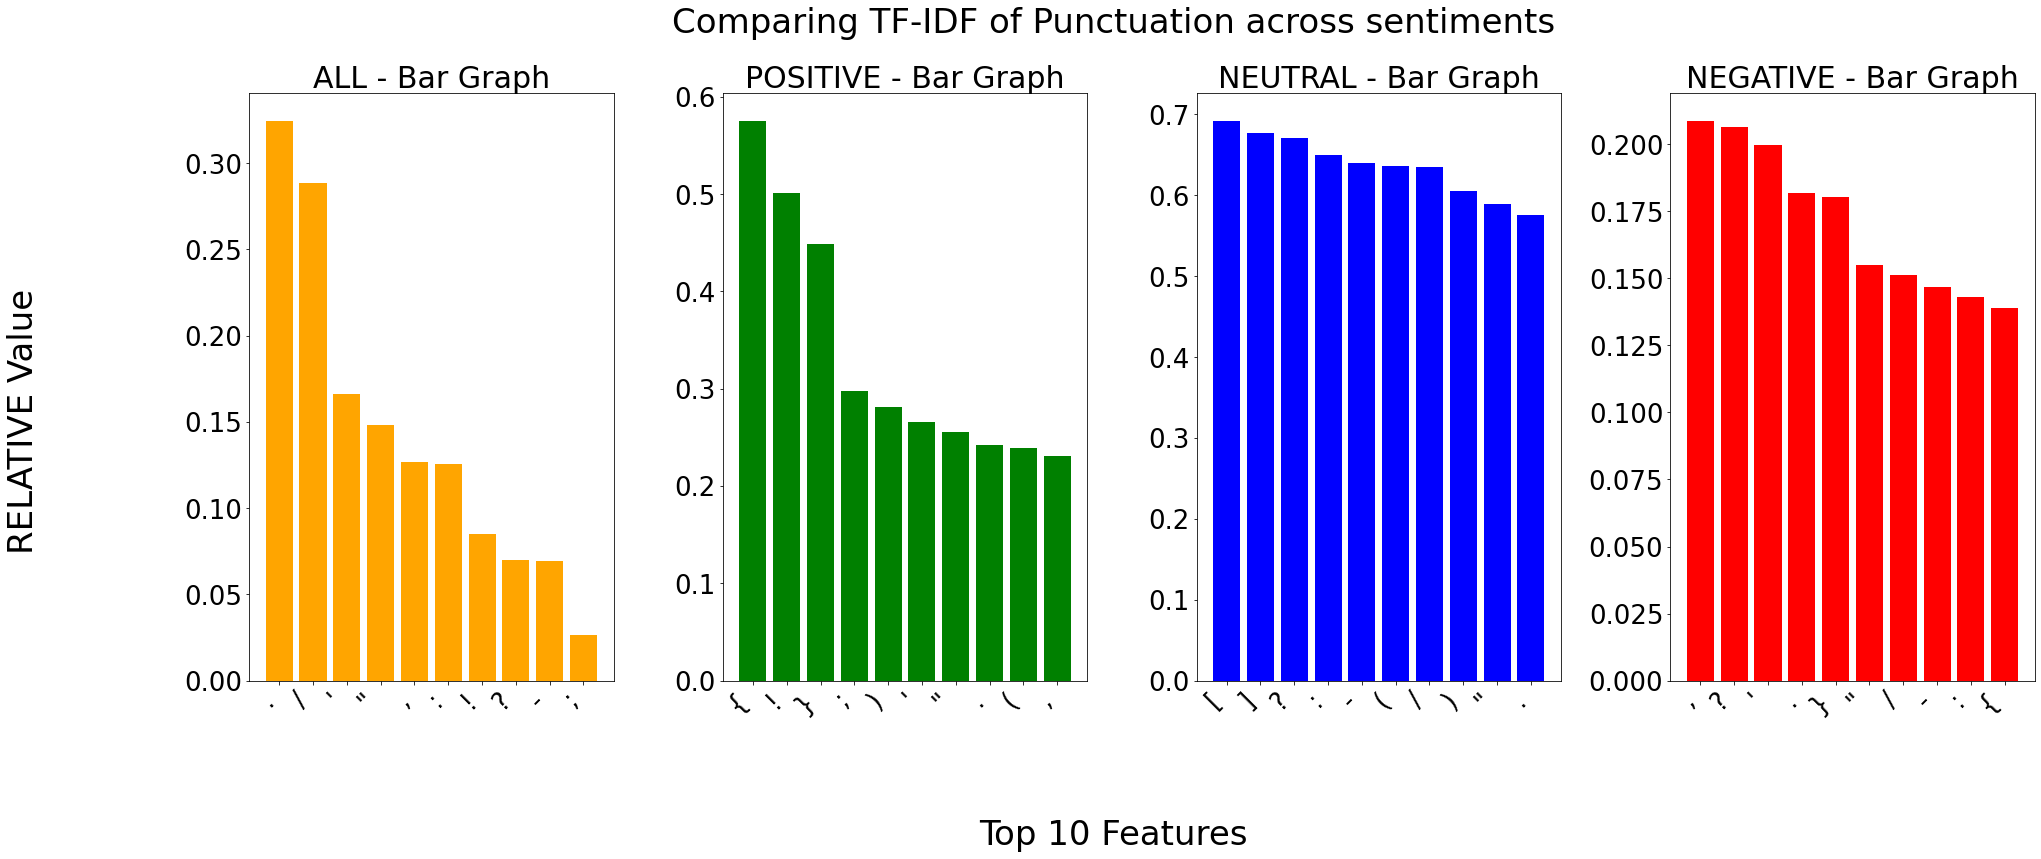

In [ ]:
def tokenizer_char(tweet, char_type = 'alphabetic'): 
    if char_type == 'alphabetic':
        t = re.sub(r'[^a-z]+', '', tweet)
        return list(t)
    elif char_type == 'non-word':
        t = re.sub(r'[\w\s]+', '', tweet)
        return list(t)
    elif char_type == 'punctuation':
        return RE_PUNCTUATION.findall(tweet)
    else:
        return list(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_ALPHABETICS_COUNT = 'Bag of Alphabetics'
cv_alpha = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
X_train_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.fit_transform(train_df['text'])
X_test_features[FEATURE_ALPHABETICS_COUNT] = cv_alpha.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_ALPHABETICS_COUNT], y, cv_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_ALPHABETICS_TFIDF = 'TF-IDF of Alphabetics'
tfidf_alpha = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
X_train_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.fit_transform(train_df['text'])
X_test_features[FEATURE_ALPHABETICS_TFIDF] = tfidf_alpha.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_ALPHABETICS_TFIDF], y, tfidf_alpha.get_feature_names_out(), FEATURE_ALPHABETICS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PUNCTUATION_COUNT = 'Bag of Punctuation'
cv_punct = CountVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
X_train_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.fit_transform(train_df['text'])
X_test_features[FEATURE_PUNCTUATION_COUNT] = cv_punct.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_PUNCTUATION_COUNT], y, cv_punct.get_feature_names_out(), FEATURE_PUNCTUATION_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PUNCTUATION_TFIDF = 'TF-IDF of Punctuation'
tfidf_punct = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
X_train_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.fit_transform(train_df['text'])
X_test_features[FEATURE_PUNCTUATION_TFIDF] = tfidf_punct.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_PUNCTUATION_TFIDF], y, tfidf_punct.get_feature_names_out(), FEATURE_PUNCTUATION_TFIDF)

### Word Lengths

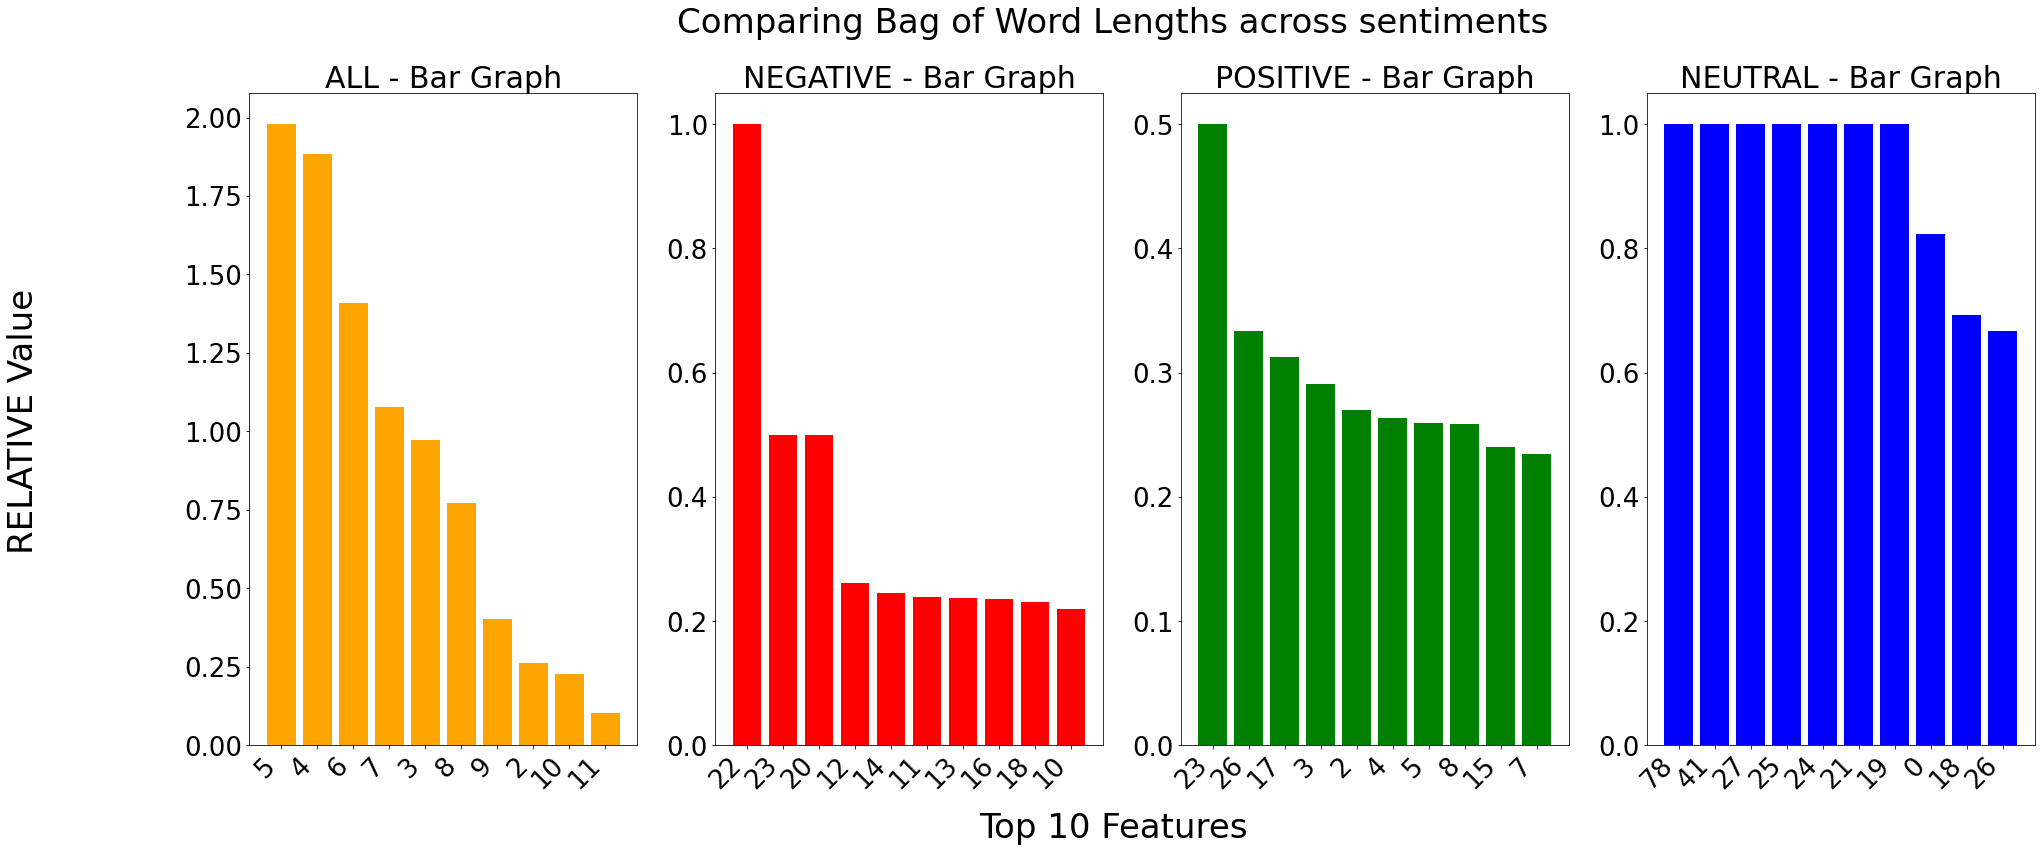

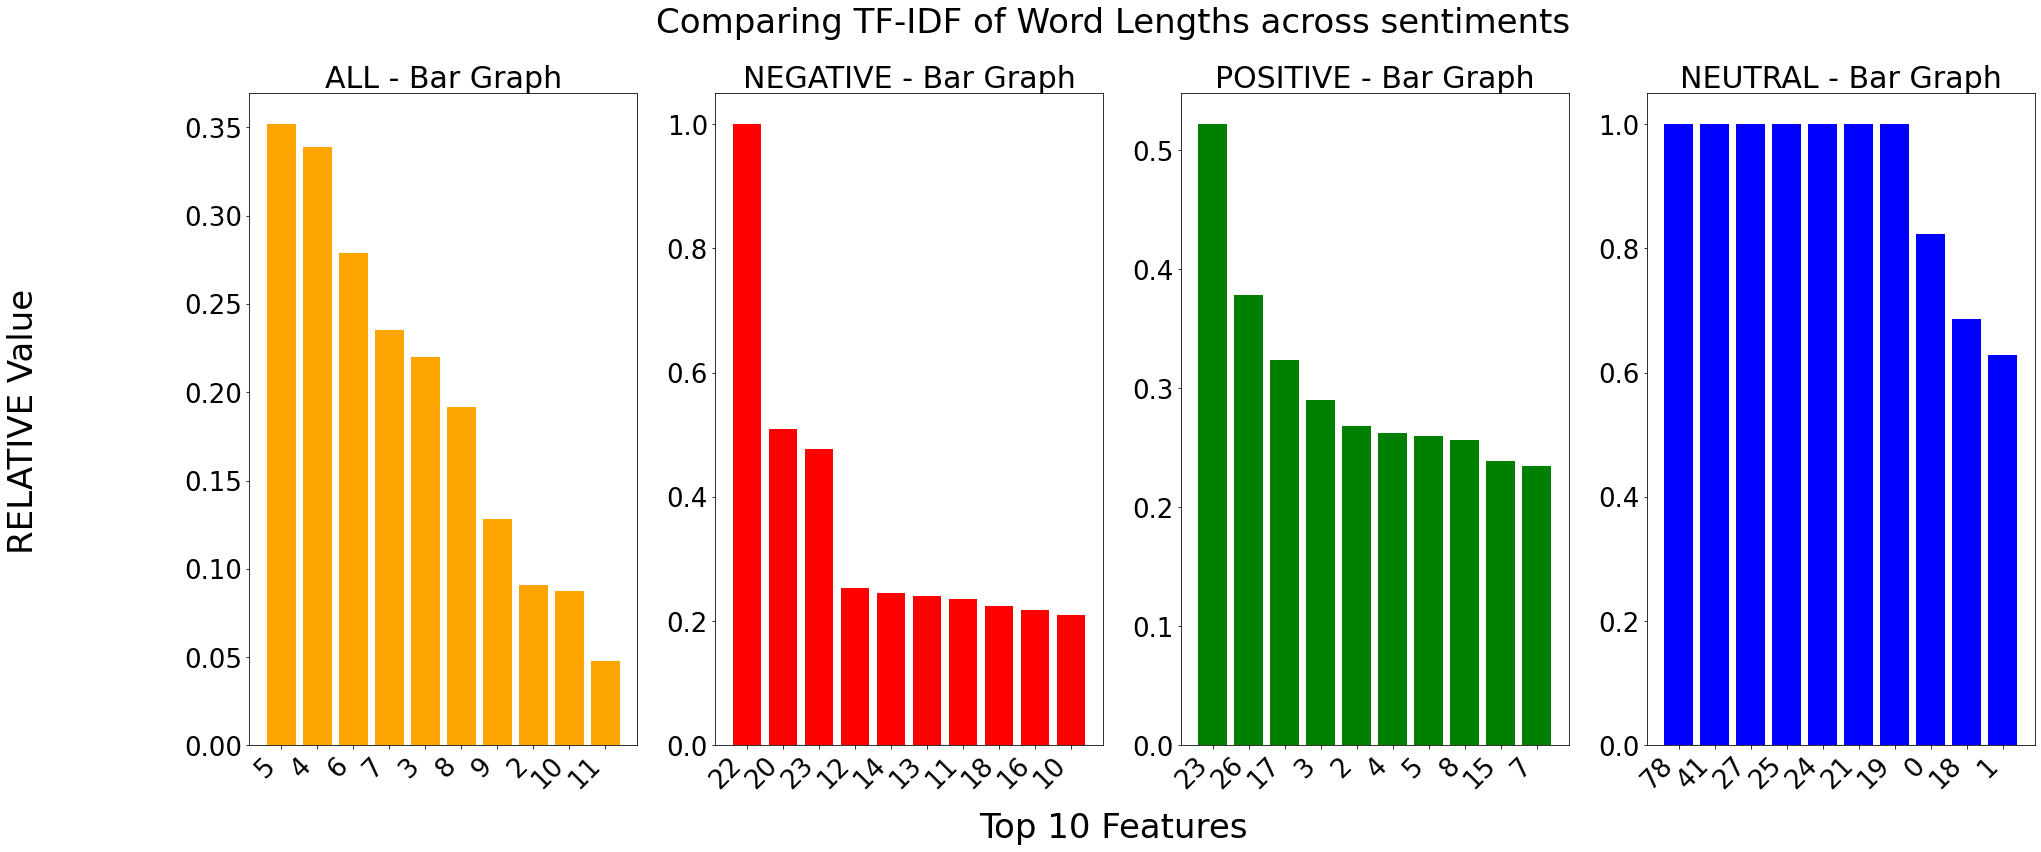

In [ ]:
def tokenizer_word_lengths(tweet): return [f'{len(w)}' for w in tweet.split(' ')]

# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORD_LENGTHS_TFIDF = 'Bag of Word Lengths'
cv_wl = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = cv_wl.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = cv_wl.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, cv_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

# test the regular word split tokenization on the tf-idf
FEATURE_WORD_LENGTHS_TFIDF = 'TF-IDF of Word Lengths'
tfidf_wl = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = tfidf_wl.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, tfidf_wl.get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

### Links

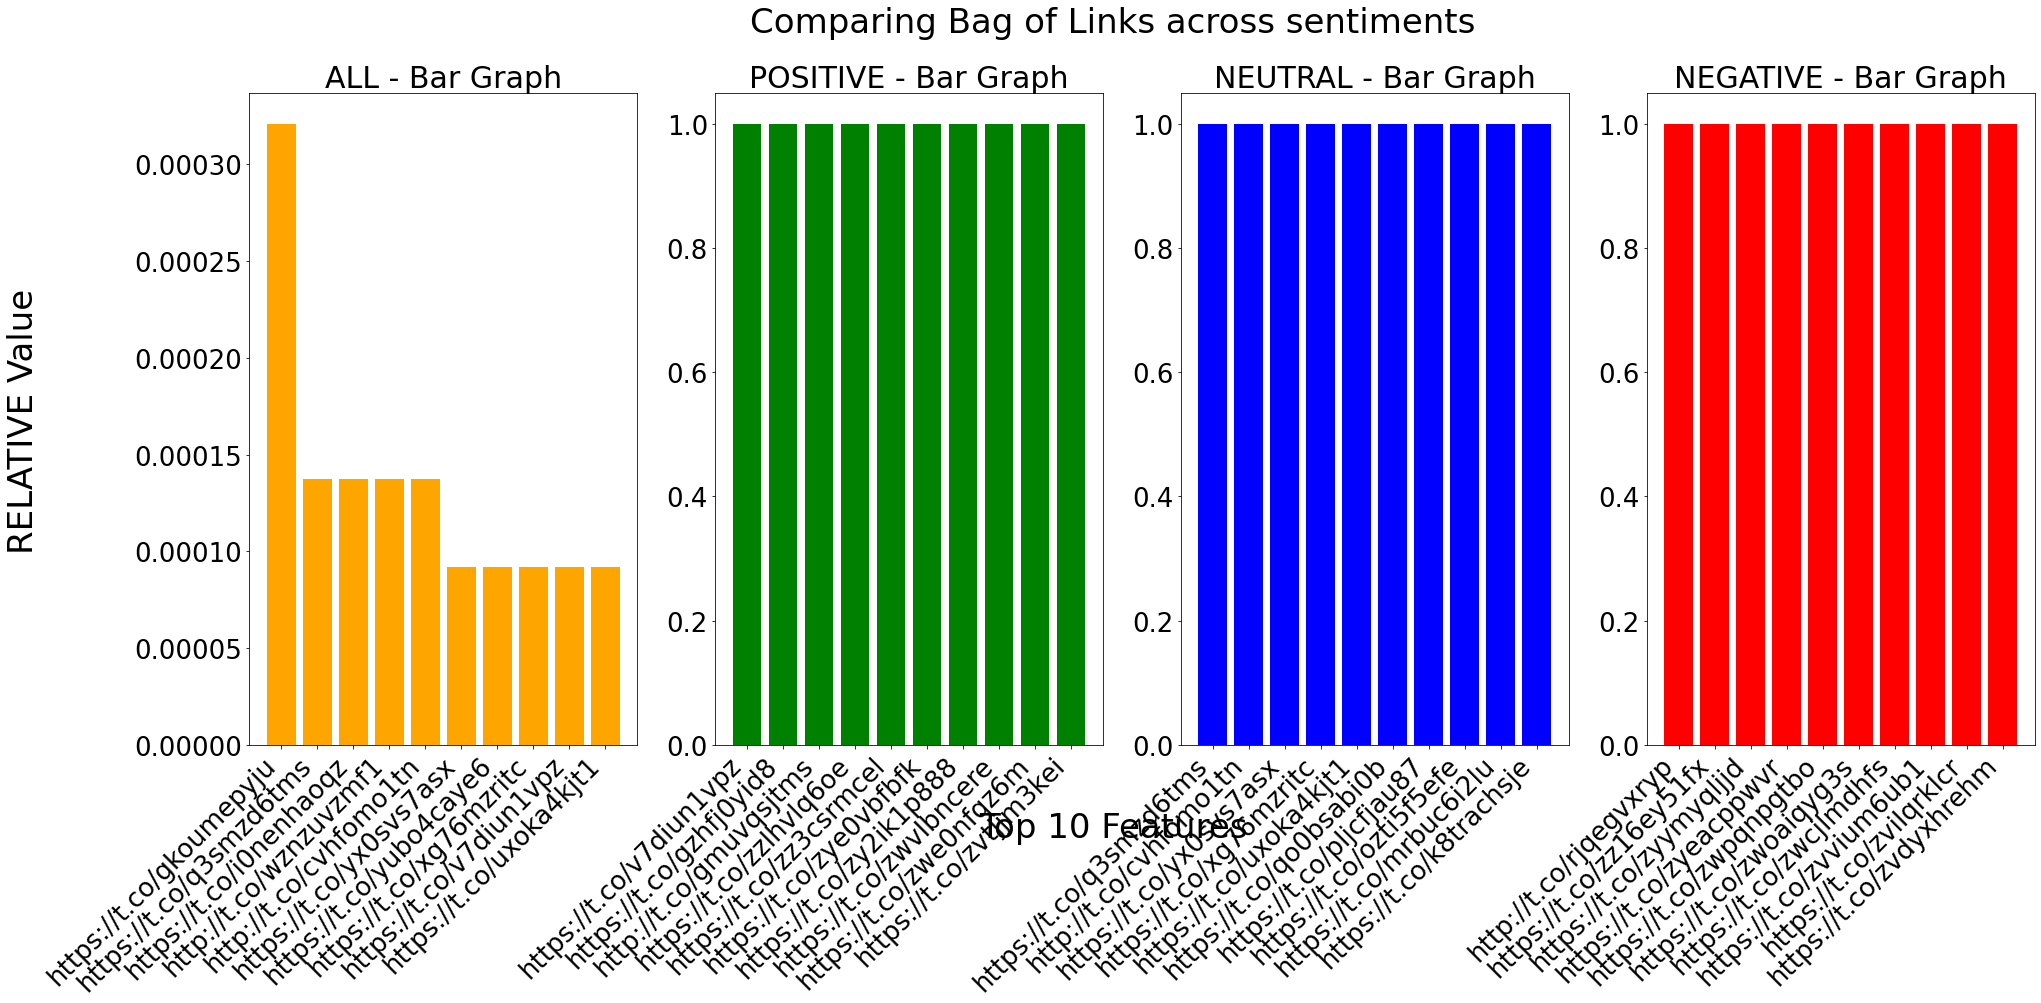

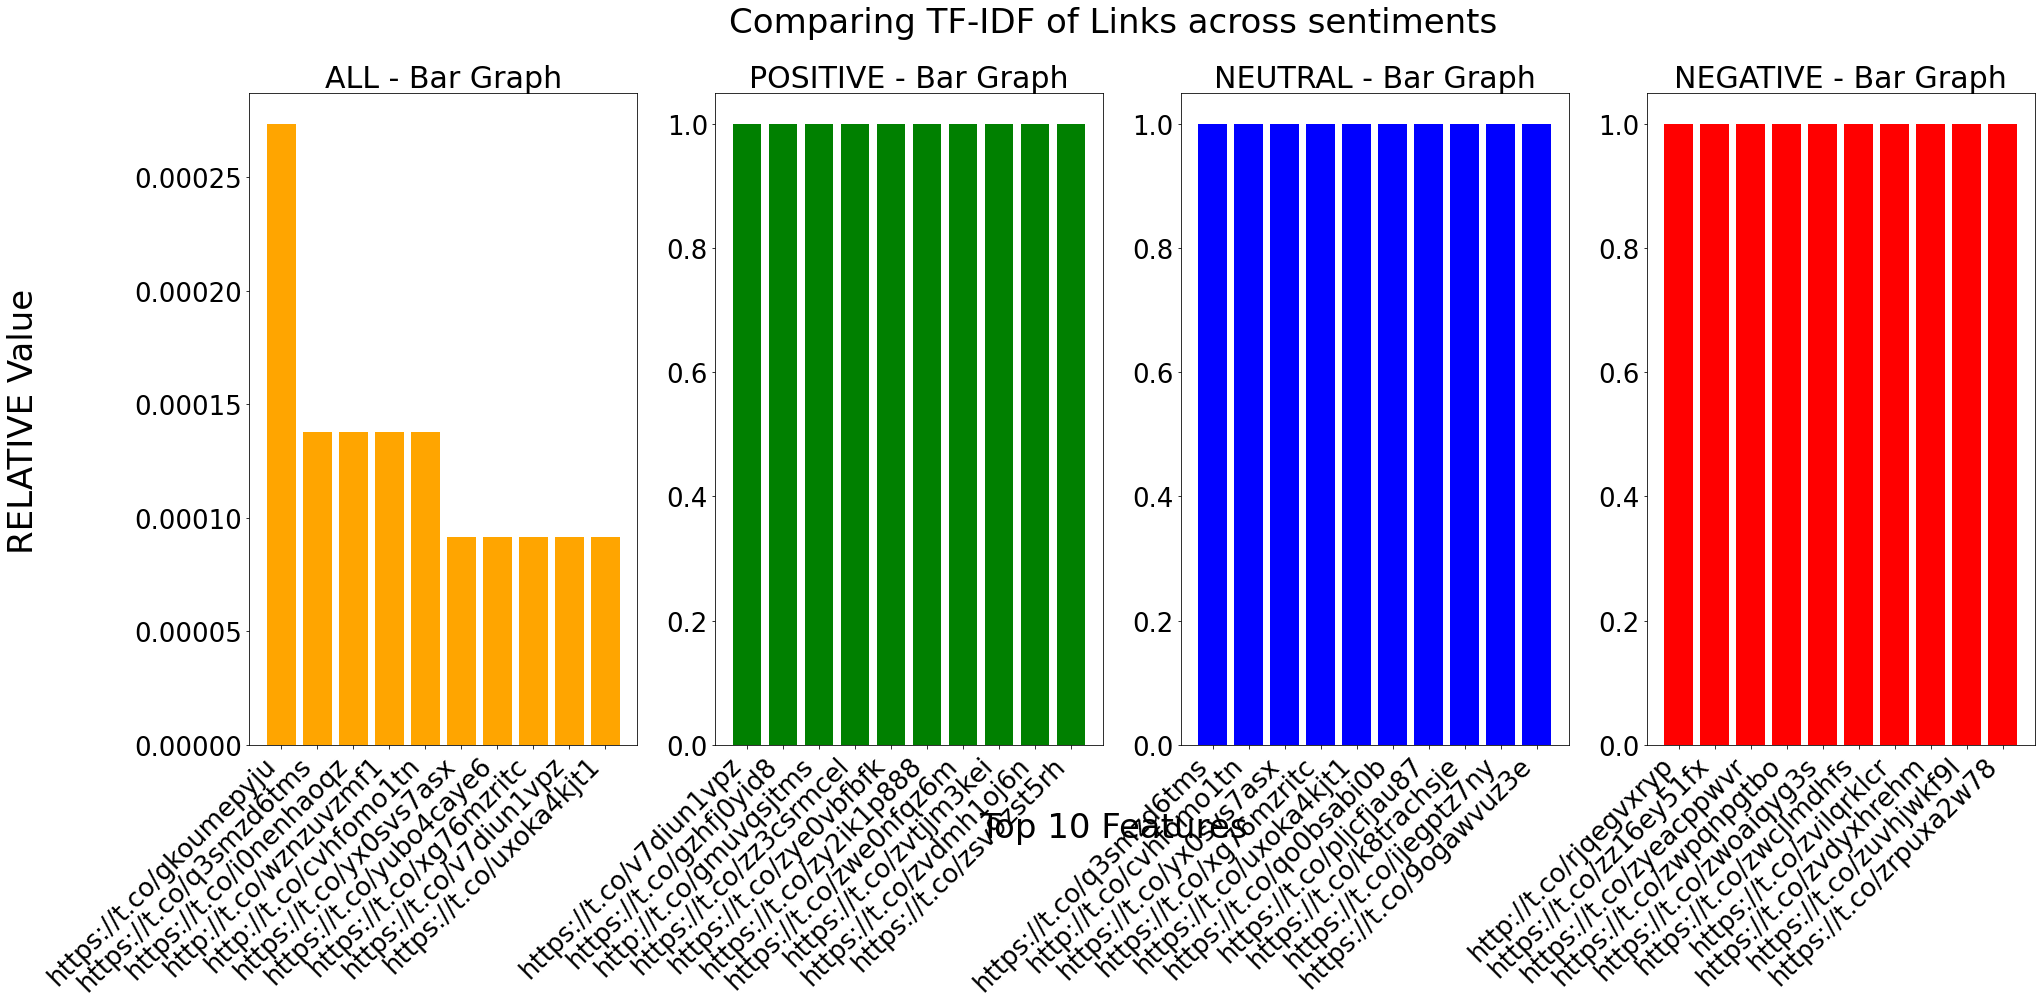

In [ ]:
def tokenizer_links(tweet): return RE_LINKS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_LINKS_COUNT = 'Bag of Links'
cv_link = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
X_train_features[FEATURE_LINKS_COUNT] = cv_link.fit_transform(train_df['text'])
X_test_features[FEATURE_LINKS_COUNT] = cv_link.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_LINKS_COUNT], y, cv_link.get_feature_names_out(), FEATURE_LINKS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_LINKS_TFIDF = 'TF-IDF of Links'
tfidf_link = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
X_train_features[FEATURE_LINKS_TFIDF] = tfidf_link.fit_transform(train_df['text'])
X_test_features[FEATURE_LINKS_TFIDF] = tfidf_link.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_LINKS_TFIDF], y, tfidf_link.get_feature_names_out(), FEATURE_LINKS_TFIDF)

### Hashtags

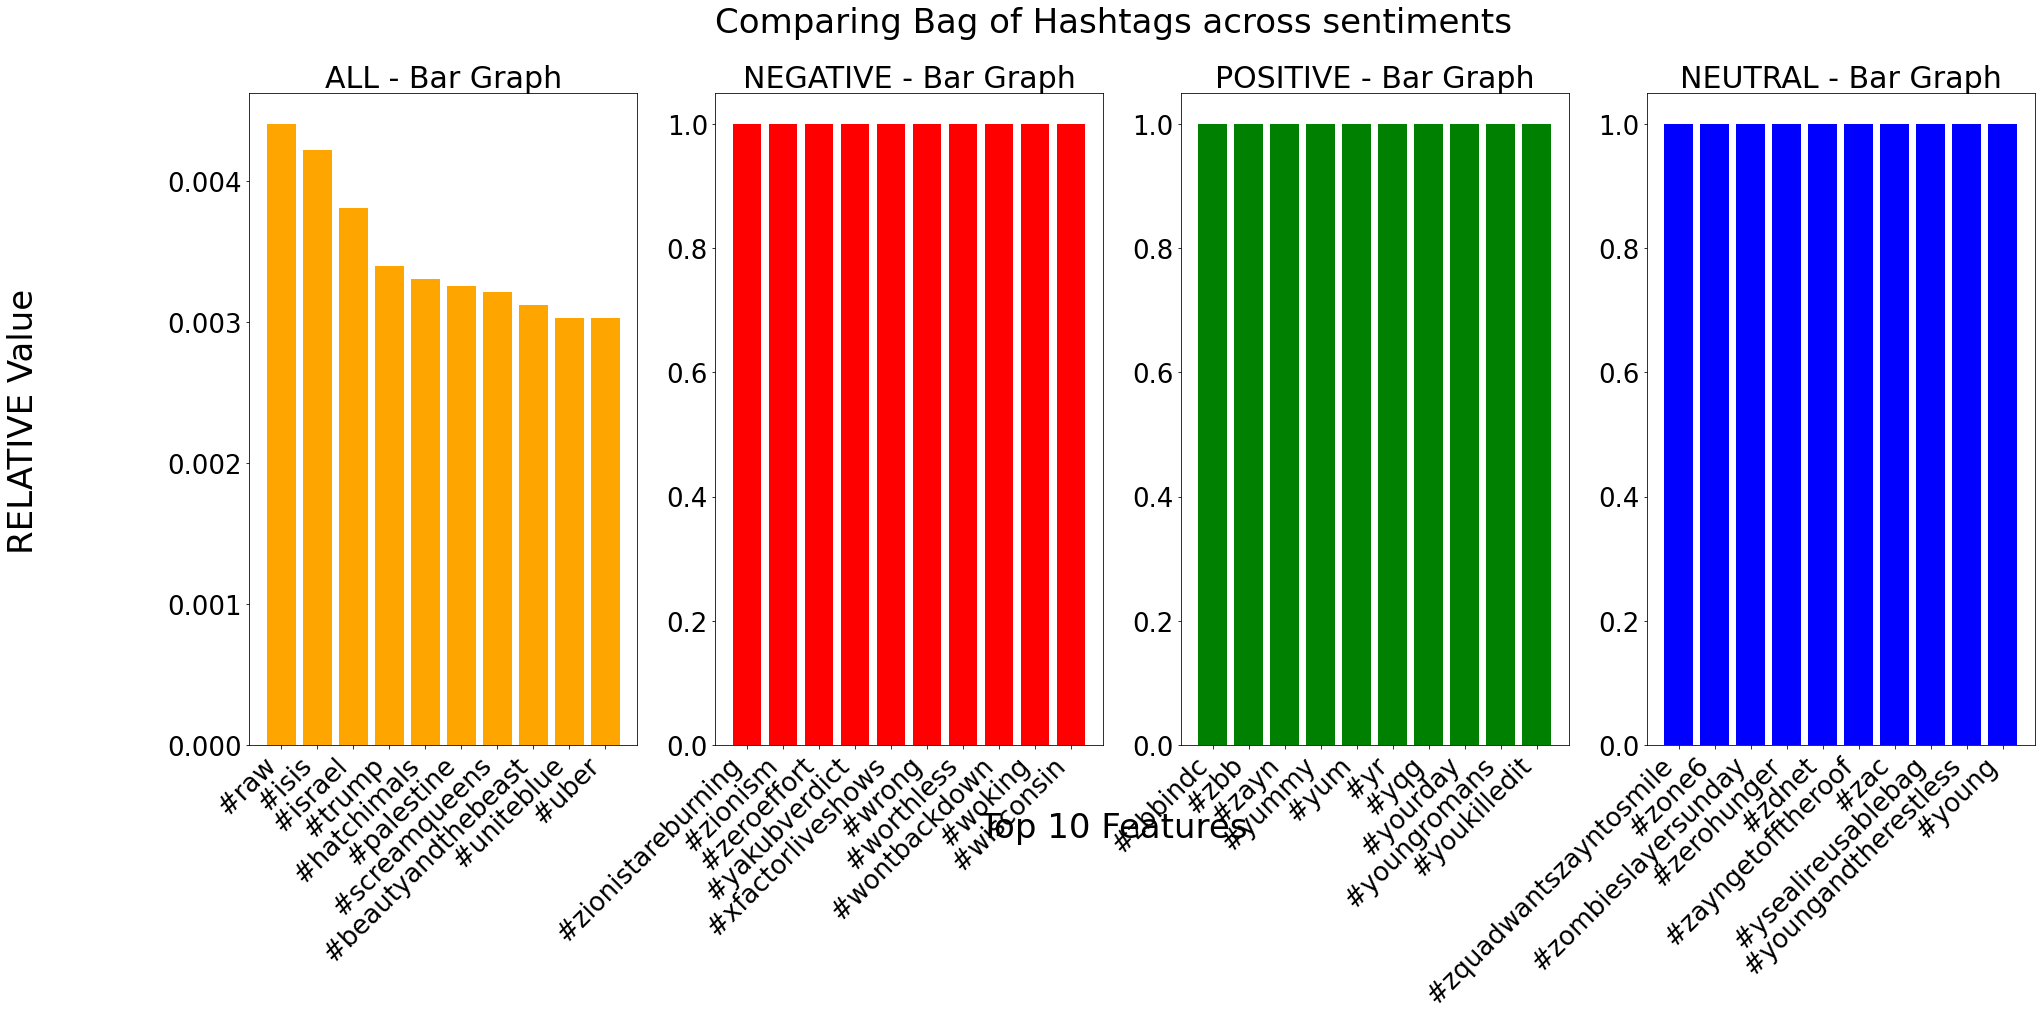

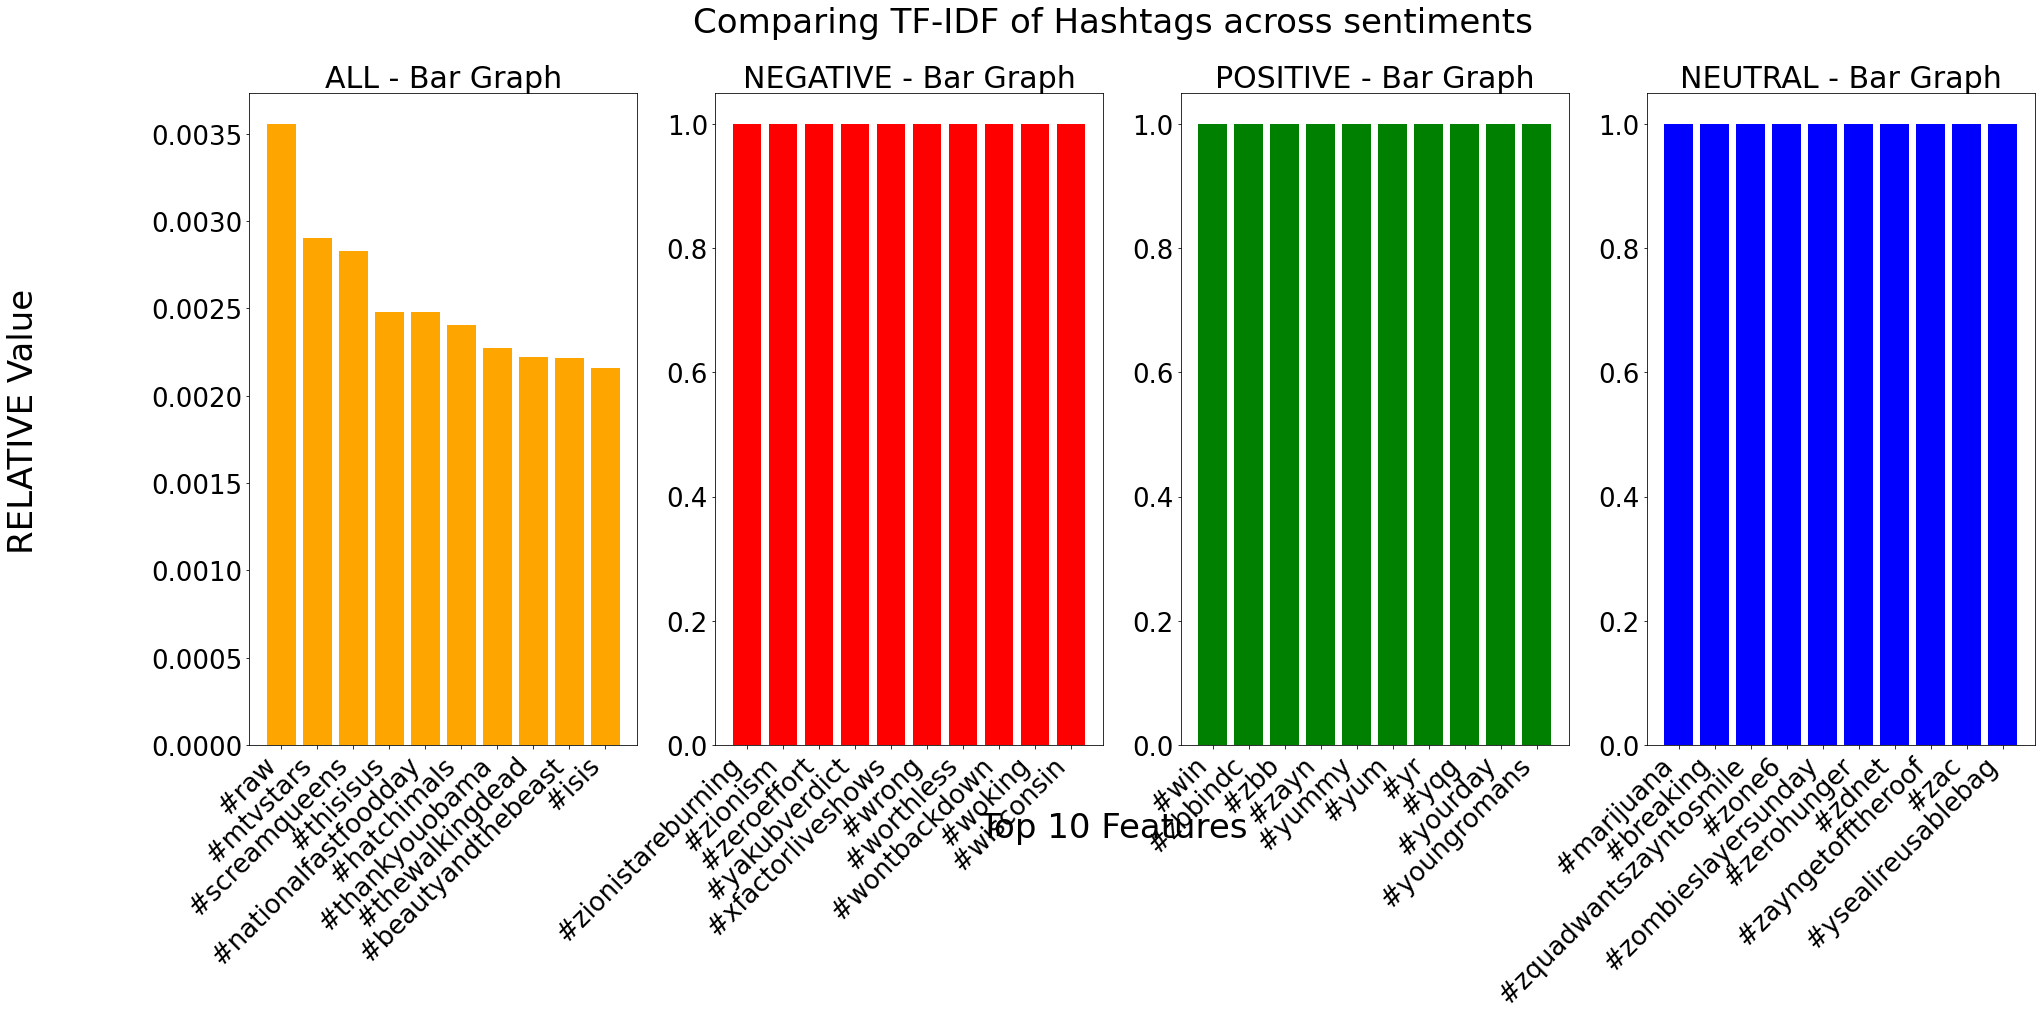

In [ ]:
def tokenizer_hashtags(tweet): return RE_HASHTAGS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_HASHTAGS_COUNT = 'Bag of Hashtags'
cv_ht = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
X_train_features[FEATURE_HASHTAGS_COUNT] = cv_ht.fit_transform(train_df['text'])
X_test_features[FEATURE_HASHTAGS_COUNT] = cv_ht.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_HASHTAGS_COUNT], y, cv_ht.get_feature_names_out(), FEATURE_HASHTAGS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_HASHTAGS_TFIDF = 'TF-IDF of Hashtags'
tfidf_ht = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
X_train_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.fit_transform(train_df['text'])
X_test_features[FEATURE_HASHTAGS_TFIDF] = tfidf_ht.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_HASHTAGS_TFIDF], y, tfidf_ht.get_feature_names_out(), FEATURE_HASHTAGS_TFIDF)

### Mentions

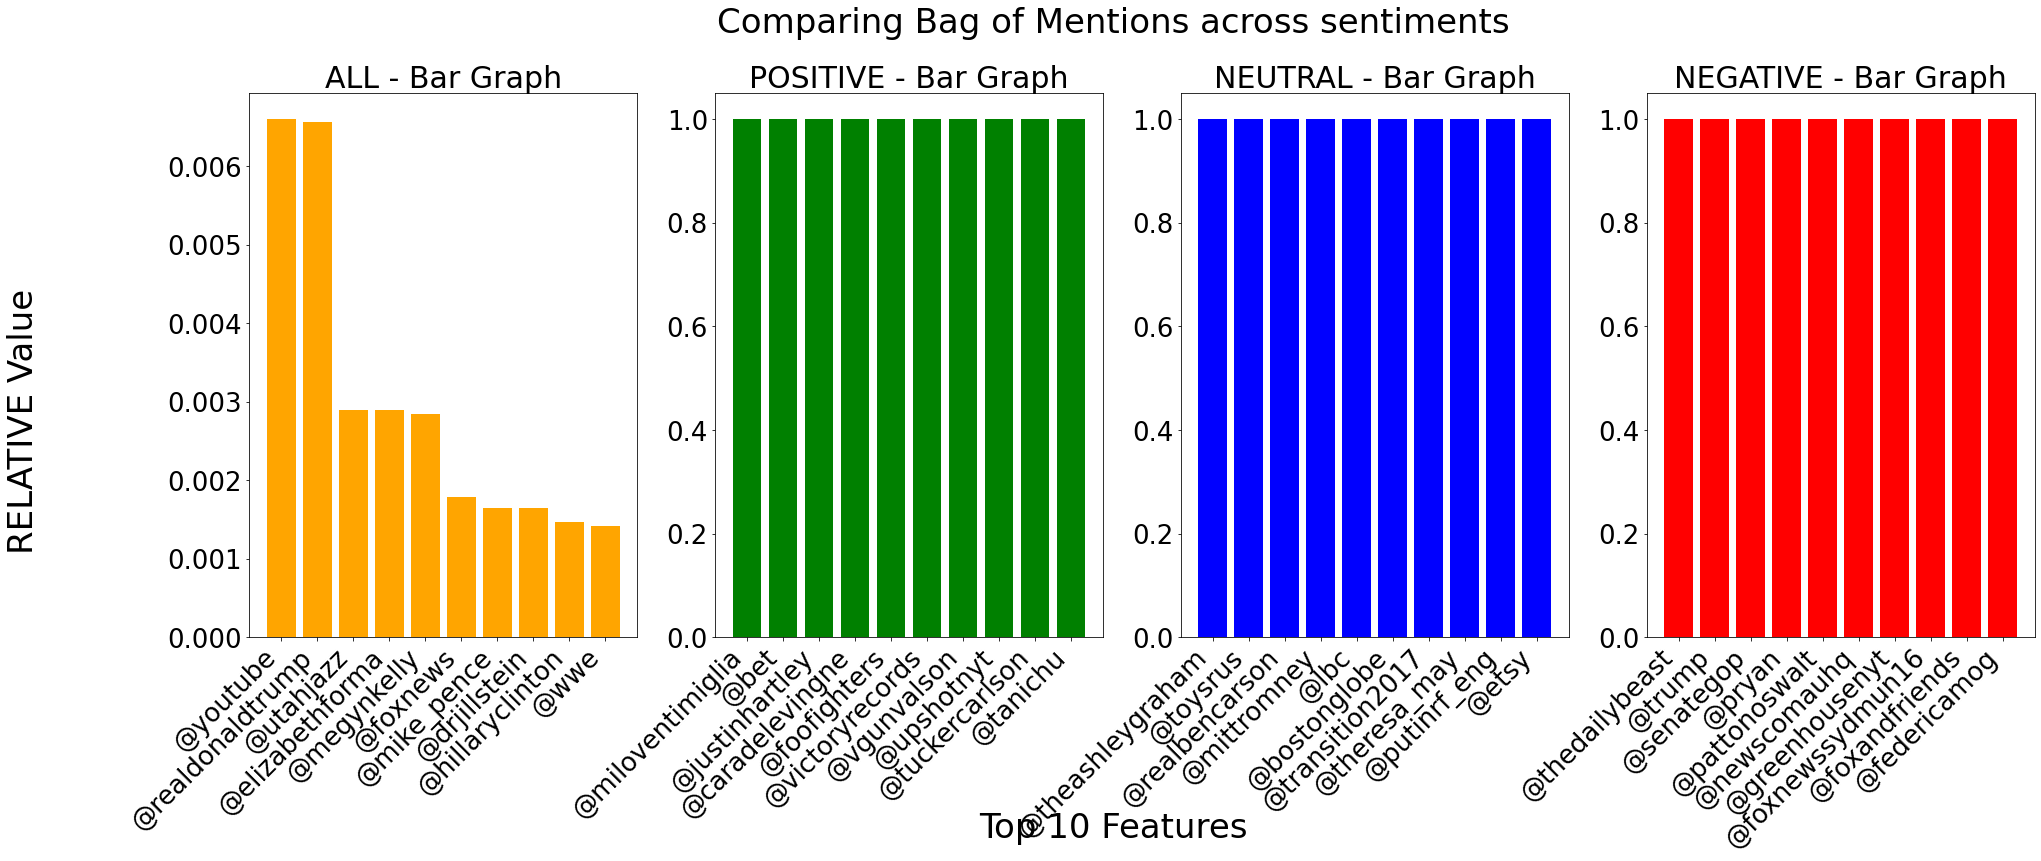

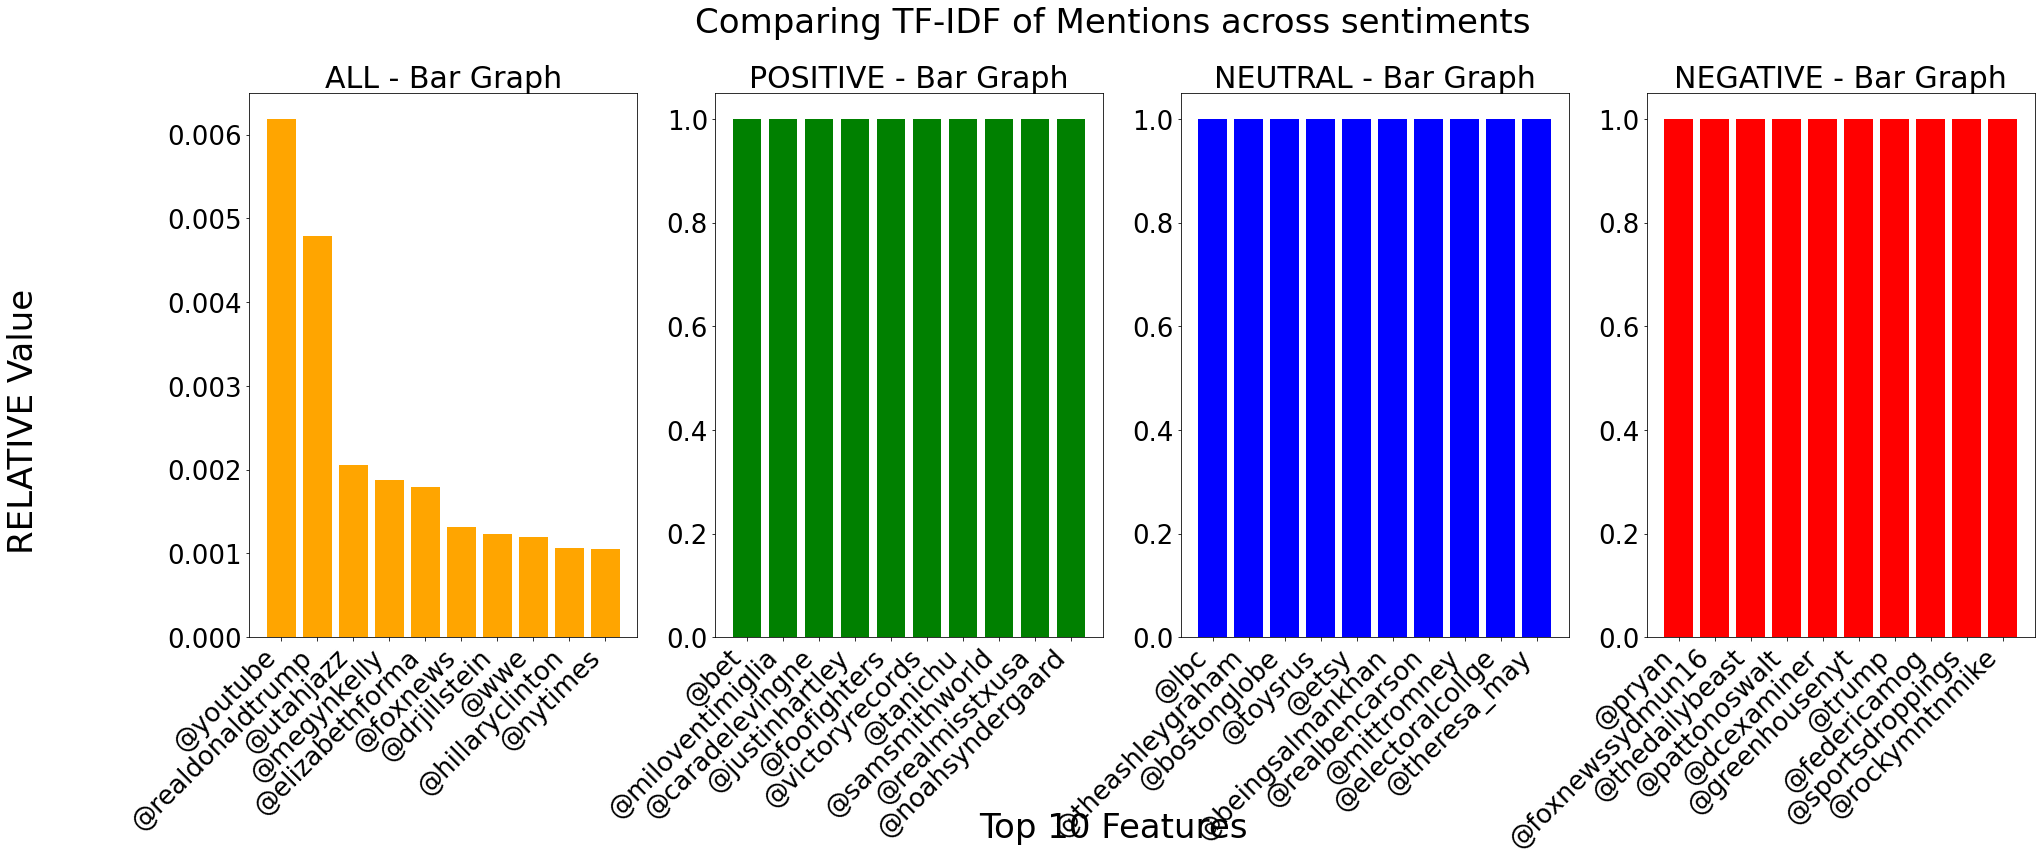

In [ ]:
def tokenizer_mentions(tweet): return RE_MENTIONS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_MENTIONS_COUNT = 'Bag of Mentions'
cv_at = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions, binary=True)
X_train_features[FEATURE_MENTIONS_COUNT] = cv_at.fit_transform(train_df['text'])
X_test_features[FEATURE_MENTIONS_COUNT] = cv_at.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_MENTIONS_COUNT], y, cv_at.get_feature_names_out(), FEATURE_MENTIONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_MENTIONS_TFIDF = 'TF-IDF of Mentions'
tfidf_at = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions)
X_train_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.fit_transform(train_df['text'])
X_test_features[FEATURE_MENTIONS_TFIDF] = tfidf_at.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_MENTIONS_TFIDF], y, tfidf_at.get_feature_names_out(), FEATURE_MENTIONS_TFIDF)

### Emoticons


In [ ]:
# define the sets of symbols to construct the emoticons
CH_EMOTE_EYES = r';:8='  # eye symbols
CH_EMOTE_MIDDLE = r'\',\-\"\*'  # middle symbols
CH_EMOTE_MOUTHS_HAP = r')3\]'  # happy/cutesy mouths
CH_EMOTE_MOUTHS_HAP_BACK = r'(\[' # if the emote is reversed these are happy mouths
CH_EMOTE_MOUTHS_SAD = r'\\/(\['  # sad/unhappy mouths
CH_EMOTE_MOUTHS_SAD_BACK = r'p)\]'  # if the emote is reversed these are sad mouths
CH_EMOTE_MOUTHS_SUR = r'vo'  # surprised mouths
CH_EMOTE_MOUTHS_NEU = r'pl\|'  # neutral mouths
CH_EMOTE_MOUTHS = CH_EMOTE_MOUTHS_HAP + CH_EMOTE_MOUTHS_SAD + \
    CH_EMOTE_MOUTHS_SUR + CH_EMOTE_MOUTHS_NEU
# Only allow one type of mouth to be found at a time (`:\3` is not allowed)
CH_EMOTES = r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_HAP + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SAD + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SUR + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_NEU + r']+(?=[\W])|'
# add the backwards results
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_HAP_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_SAD_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_NEU + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])'

RE_EMOTES = re.compile(CH_EMOTES)

# Simplifies emoticons to remove middle symbols and simplify eyes
# (since it's really the mouth that gives emotion away)
def simplify_emoticon(emote):
    DEFAULT_EYES = ":"
    DEFAULT_NOSE = ""
    DEFAULT_MOUTH_HAP = ")"
    DEFAULT_MOUTH_SAD = "("
    DEFAULT_MOUTH_SUR = "o"
    DEFAULT_MOUTH_NEU = "|"

    # reverse it if needed
    if emote[0] in CH_EMOTE_MOUTHS_HAP_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_HAP_BACK + r"]+",
                        DEFAULT_MOUTH_HAP, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_SAD_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_SAD_BACK + r"]+",
                        DEFAULT_MOUTH_SAD, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_NEU:
        emote = emote[::-1]

    # shrink the emote to one of the simple :) :( :| :o emotes.
    e_simple = ""
    for symbol in emote:
        if symbol in CH_EMOTE_EYES:
            symbol = DEFAULT_EYES
        elif symbol in CH_EMOTE_MIDDLE:
            symbol = DEFAULT_NOSE
        elif symbol in CH_EMOTE_MOUTHS_HAP:
            symbol = DEFAULT_MOUTH_HAP
        elif symbol in CH_EMOTE_MOUTHS_SAD:
            symbol = DEFAULT_MOUTH_SAD
        elif symbol in CH_EMOTE_MOUTHS_SUR:
            symbol = DEFAULT_MOUTH_SUR
        elif symbol in CH_EMOTE_MOUTHS_NEU:
            symbol = DEFAULT_MOUTH_NEU
        if len(e_simple) > 0:
            if symbol == e_simple[-1]:
                continue
            if symbol in CH_EMOTE_MOUTHS and e_simple[-1] in CH_EMOTE_MOUTHS:
                continue
        e_simple += symbol

    return e_simple

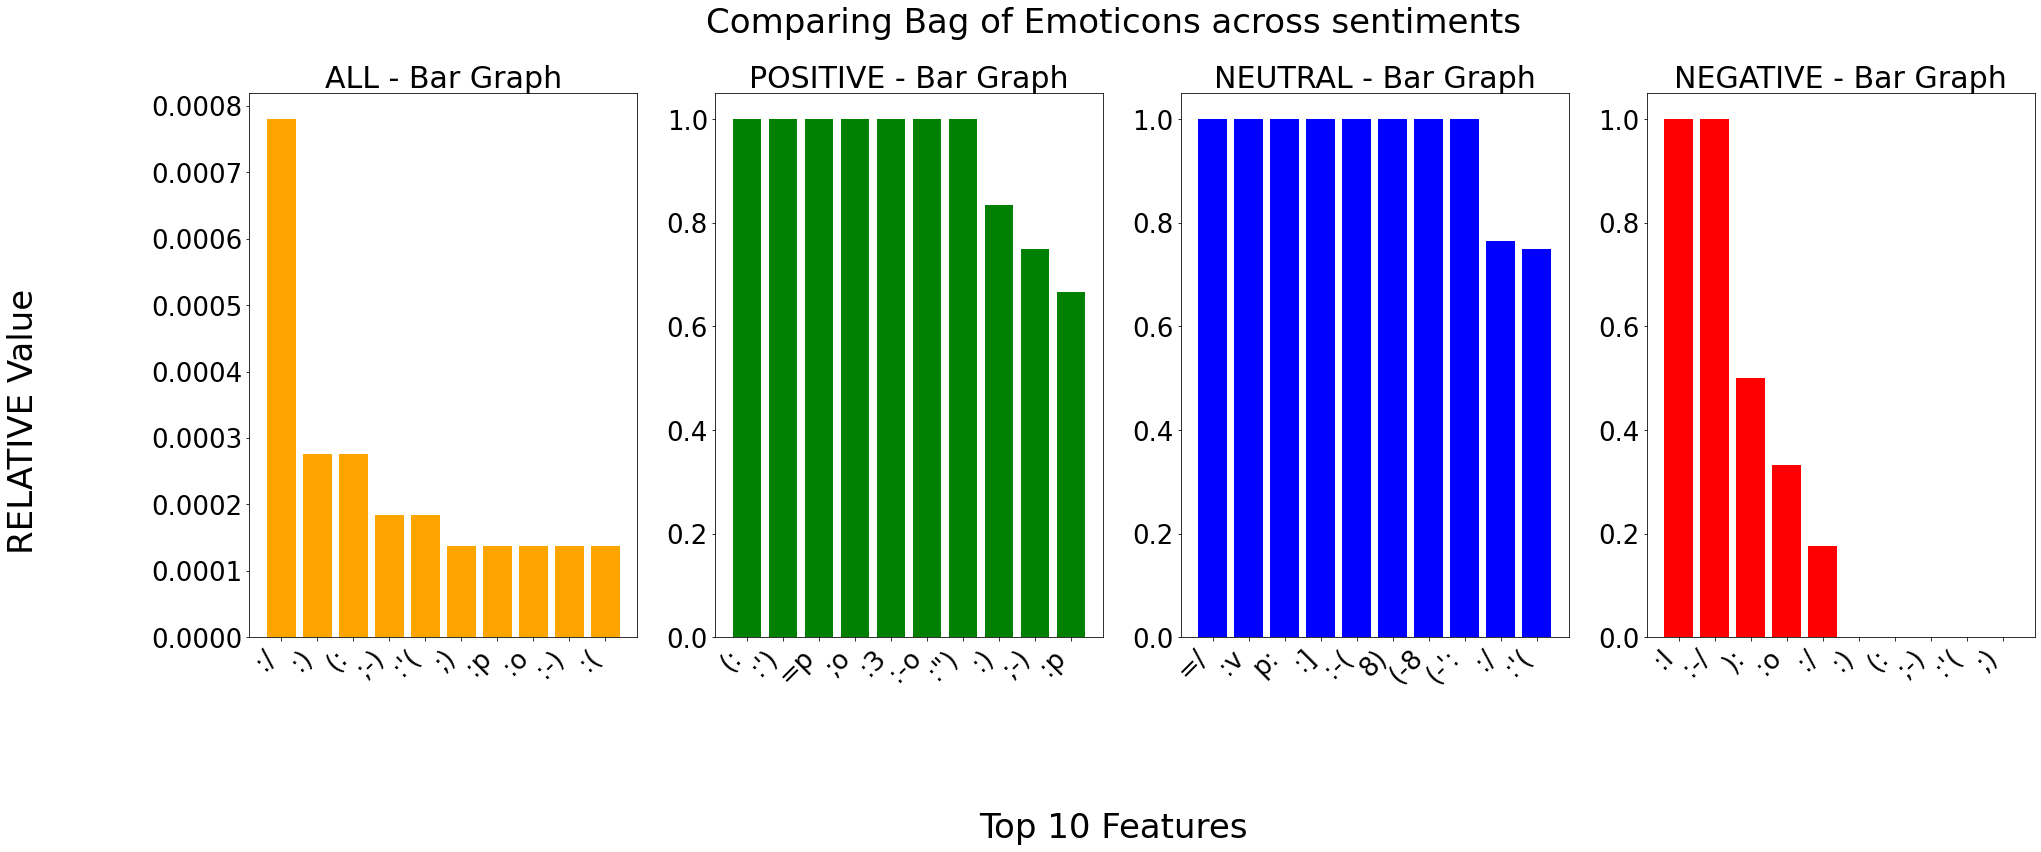

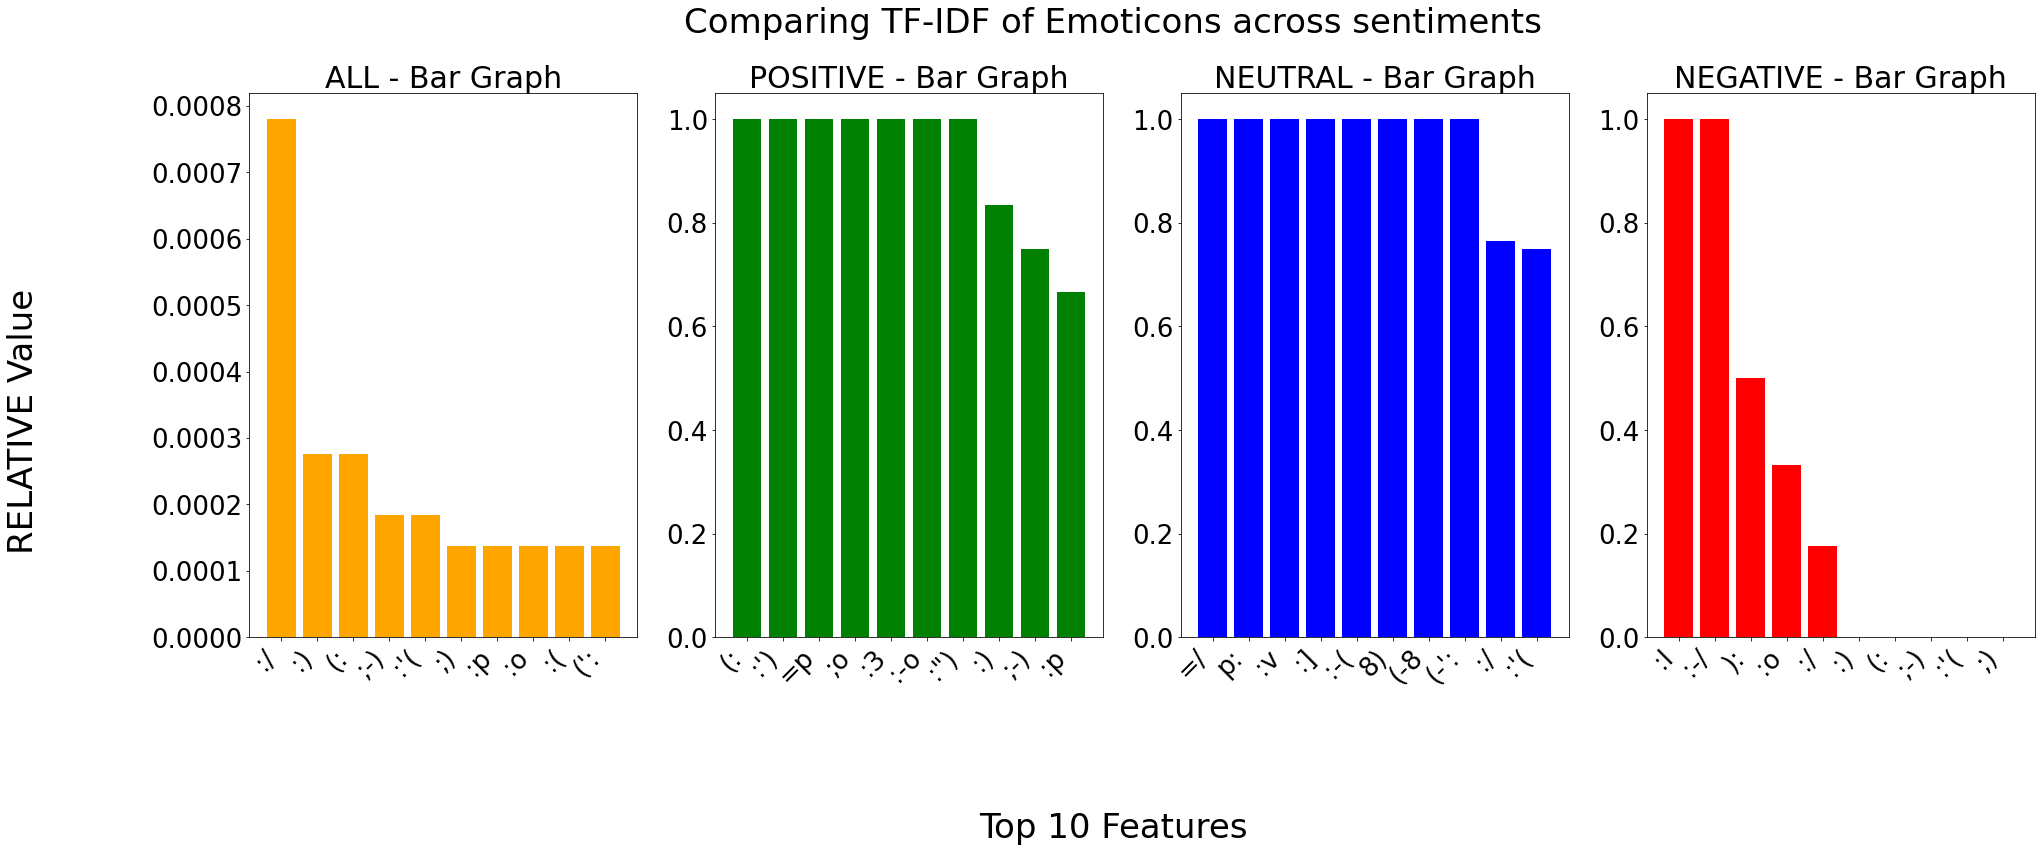

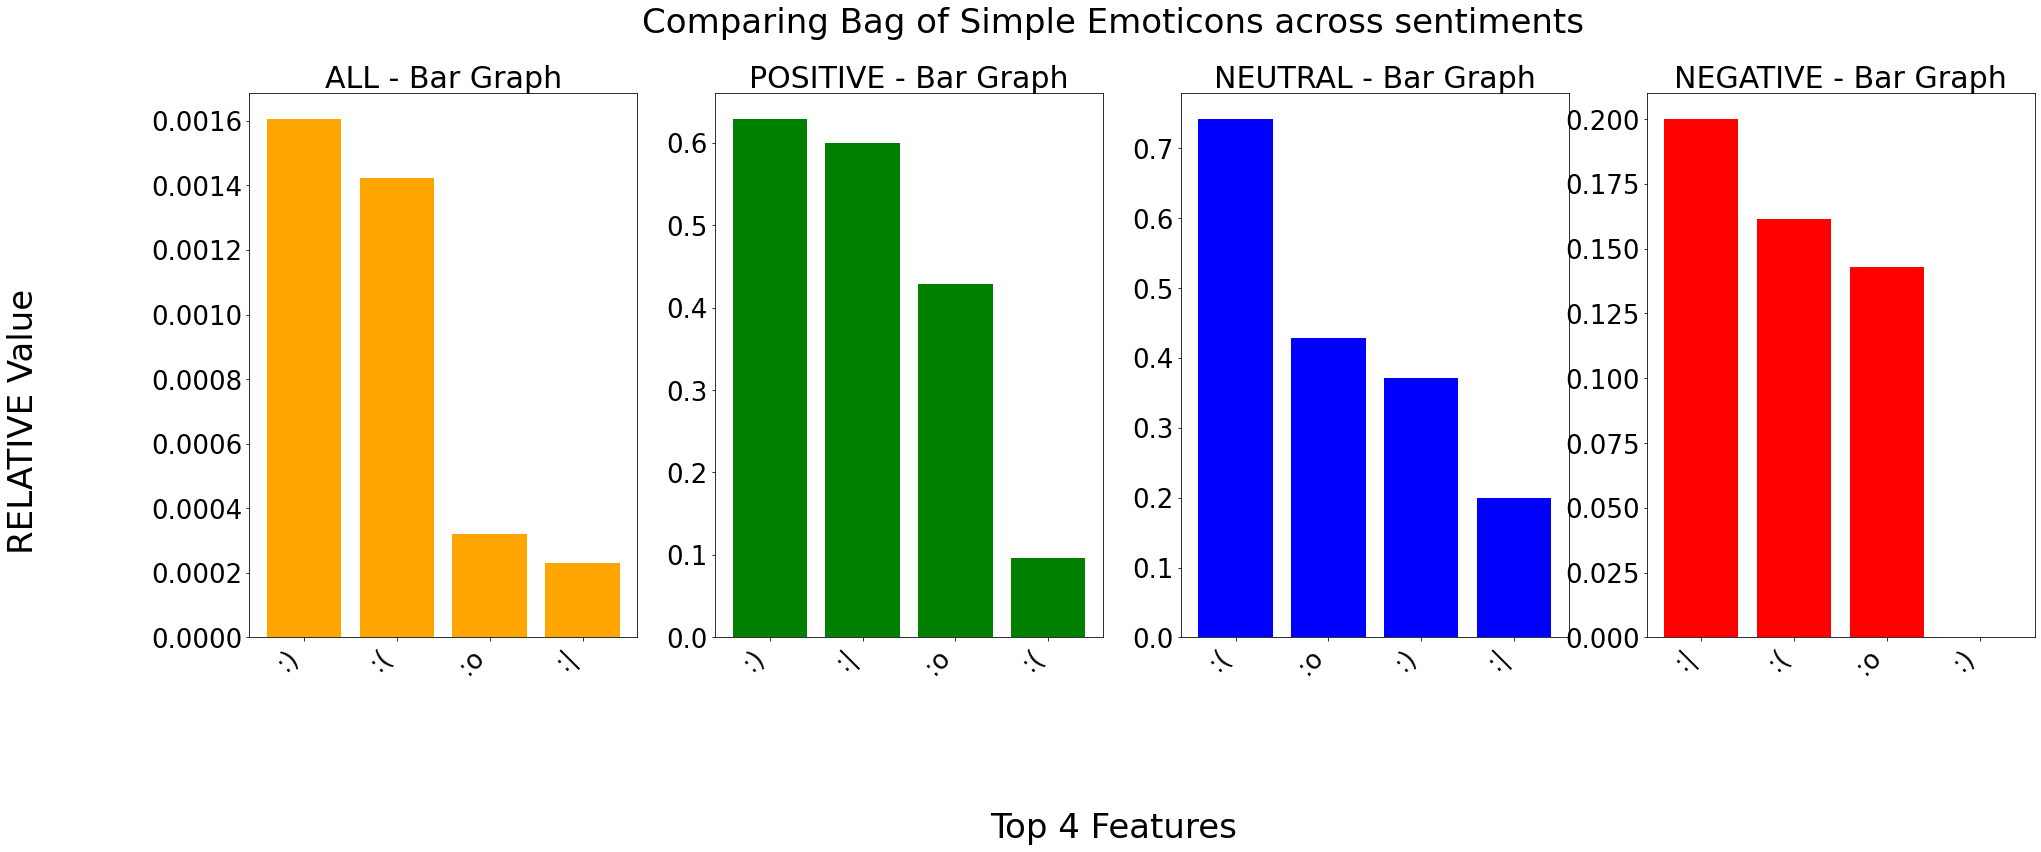

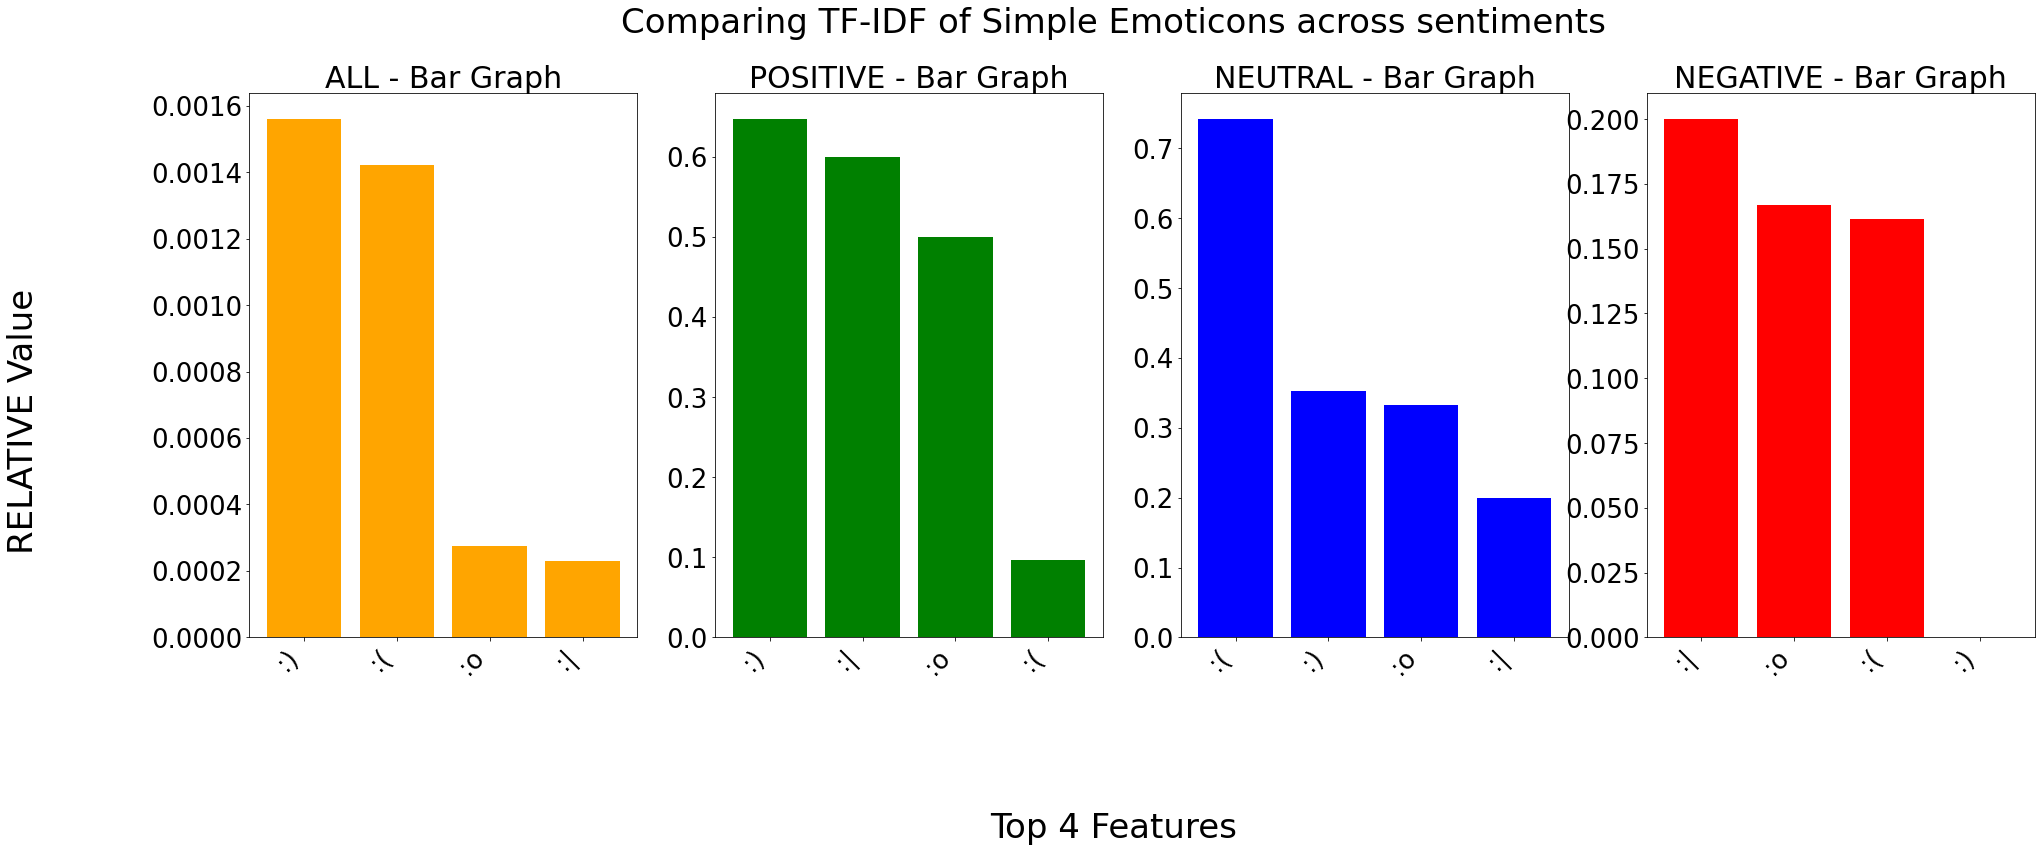

In [ ]:
# tokenize into emotes
def tokenizer_emotes(tweet, remove_repeated=True, simplify=False): 
    if remove_repeated:
        tweet = re.sub(r'(.)\1+', r'\1', tweet)
    emotes = RE_EMOTES.findall(tweet)
    # prune numbers/decimals emotes
    emotes = [e for e in emotes if not (e.isalnum() or e.isdecimal() or e.isdigit())]
    if simplify:
        return [simplify_emoticon(e) for e in emotes]
    return emotes

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_COUNT = 'Bag of Emoticons'
cv_emo = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
X_train_features[FEATURE_EMOTICONS_COUNT] = cv_emo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_COUNT] = cv_emo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_COUNT], y, cv_emo.get_feature_names_out(), FEATURE_EMOTICONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_TFIDF = 'TF-IDF of Emoticons'
tfidf_emo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
X_train_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_TFIDF] = tfidf_emo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_TFIDF], y, tfidf_emo.get_feature_names_out(), FEATURE_EMOTICONS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_SIMPLE_COUNT = 'Bag of Simple Emoticons'
cv_simemo = CountVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = cv_simemo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT], y, cv_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_SIMPLE_TFIDF = 'TF-IDF of Simple Emoticons'
tfidf_simemo = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.fit_transform(train_df['text'])
X_test_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = tfidf_simemo.transform(test_df['text'])
compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF], y, tfidf_simemo.get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_TFIDF)


### Phonetics

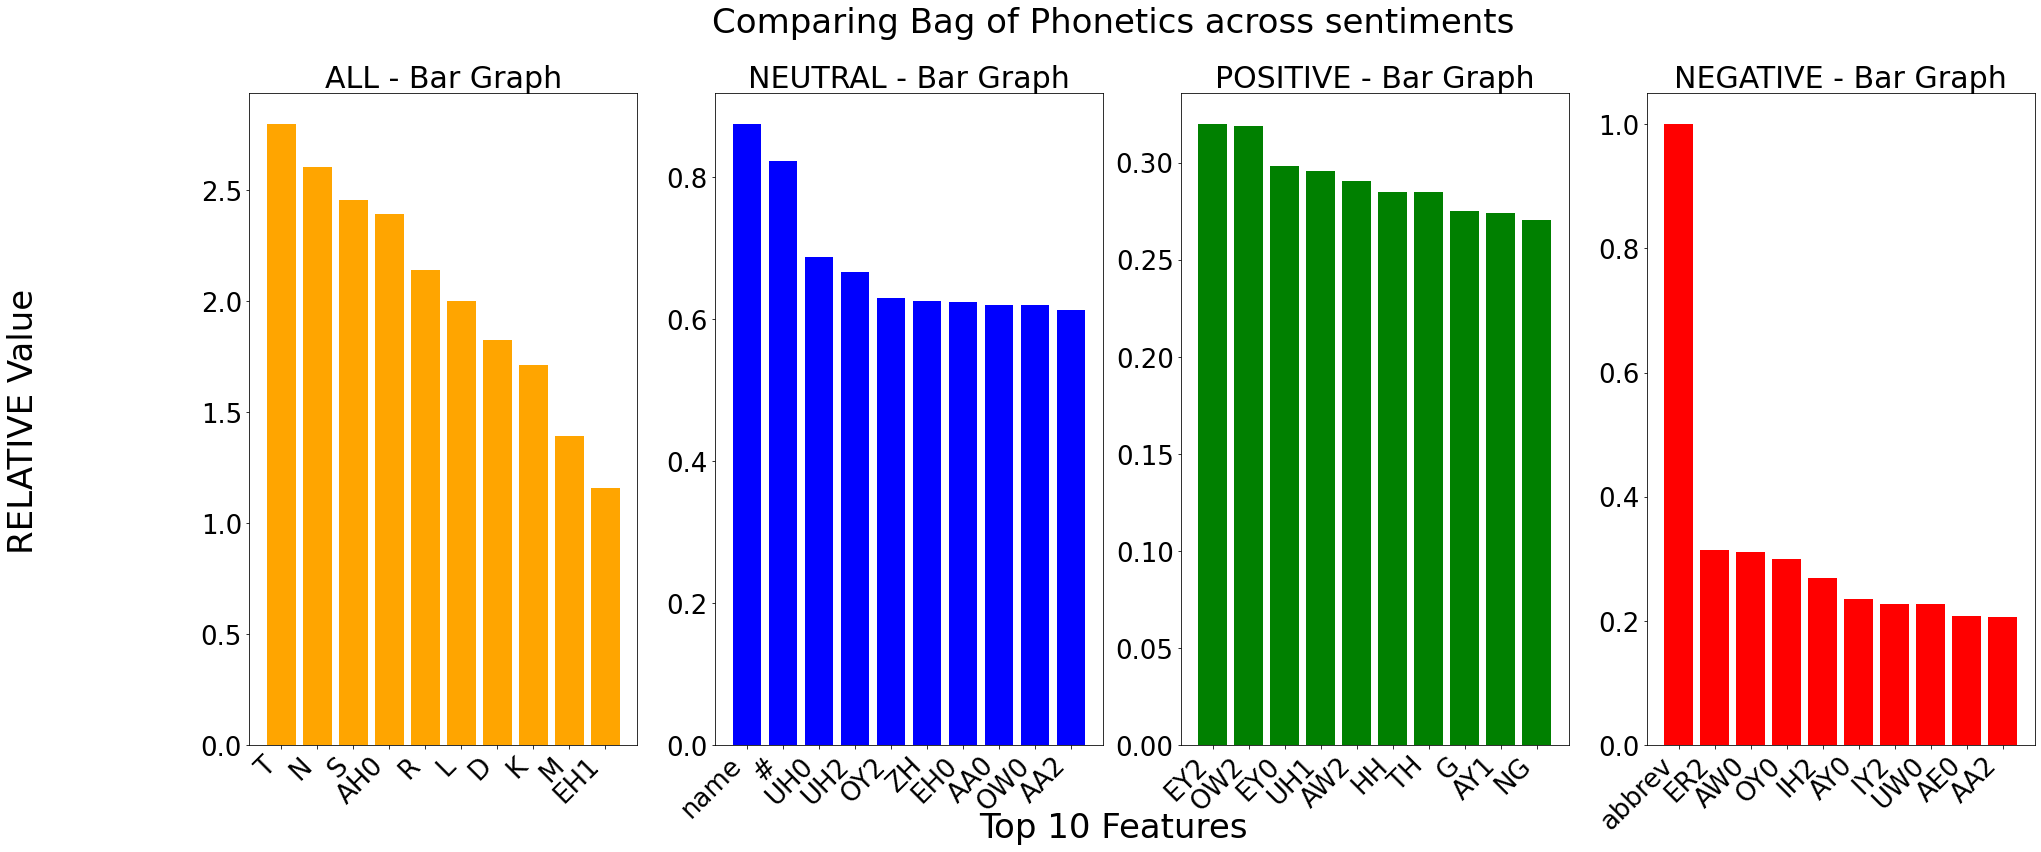

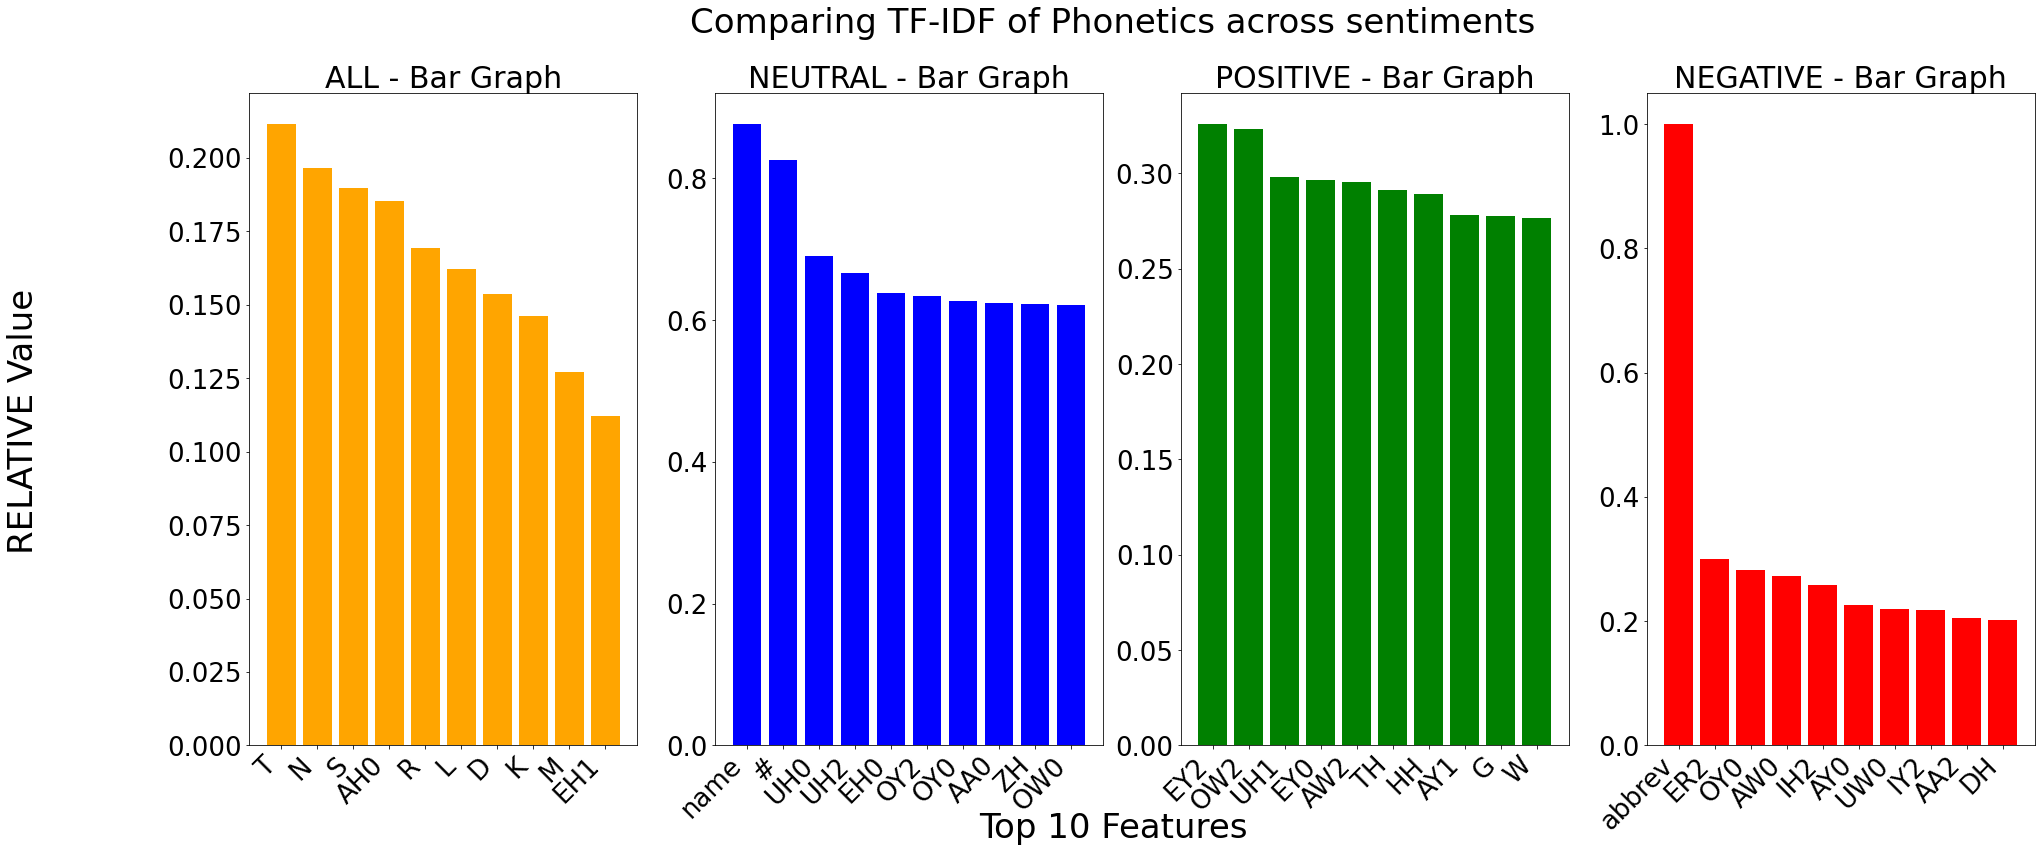

In [ ]:
def tokenizer_phonetic(tweet): 
    wlist = tweet.split(' ')
    all_phones = []
    for w in wlist:
        # get the phones breakdown of the words
        phones = pronouncing.phones_for_word(w)
        # break the phones into a list and add to it
        if len(phones) > 0:
            all_phones += phones[0].split(' ')
    return all_phones

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PHONETICS_COUNT = 'Bag of Phonetics'
cv_ph = CountVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
X_train_features[FEATURE_PHONETICS_COUNT] = cv_ph.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_PHONETICS_COUNT] = cv_ph.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_PHONETICS_COUNT], y, cv_ph.get_feature_names_out(), FEATURE_PHONETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PHONETICS_TFIDF = 'TF-IDF of Phonetics'
tfidf_ph = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
X_train_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.fit_transform(train_df['text-clean'])
X_test_features[FEATURE_PHONETICS_TFIDF] = tfidf_ph.transform(test_df['text-clean'])
compare_bars(X_train_features[FEATURE_PHONETICS_TFIDF], y, tfidf_ph.get_feature_names_out(), FEATURE_PHONETICS_TFIDF)

### Poetic Phonetics

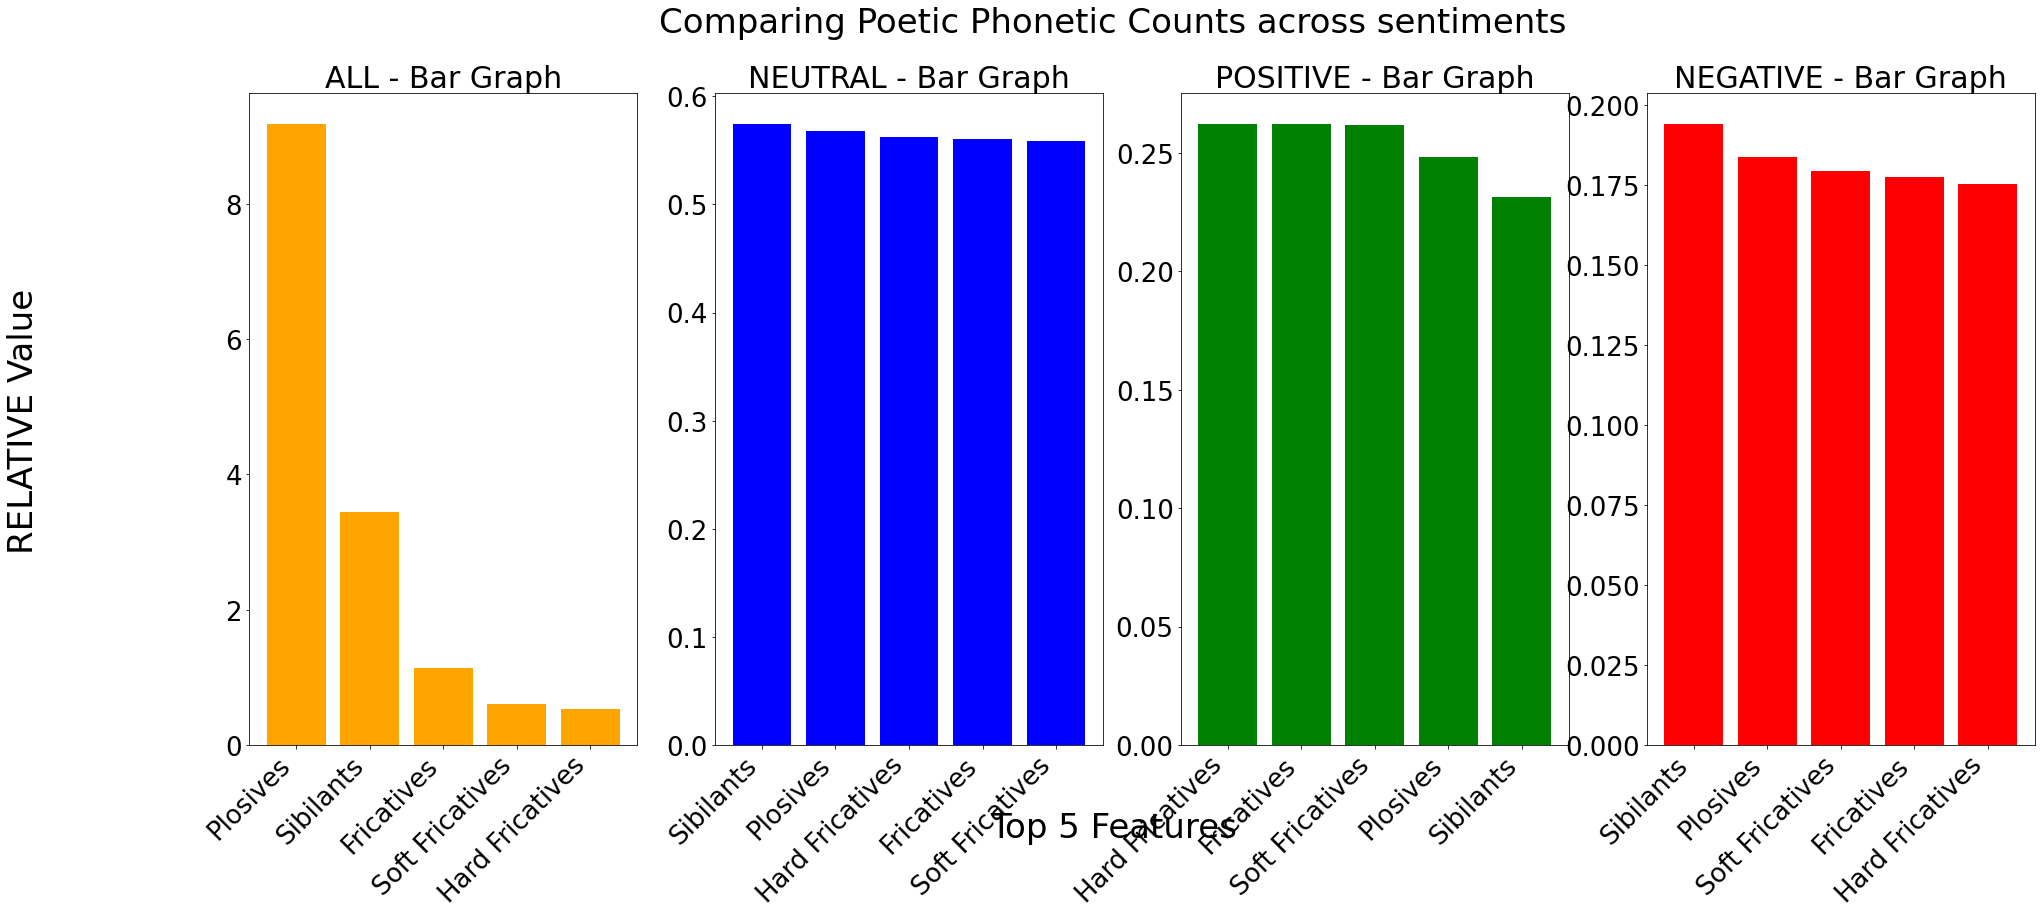

In [ ]:
FEATURE_POETICS = 'Poetic Phonetic Counts'
plosive_set = ['B', 'P', 'D', 'T', 'G', 'K',
                'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
ch_plosive = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"
RE_PLOSIVES = re.compile(ch_plosive)

fricative_hard_set = ['DH', 'V']
ch_fricative_hard = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"
RE_FRICATIVES_HARD = re.compile(ch_fricative_hard)

fricative_soft_set = ['TH', 'F']
ch_fricative_soft = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"
RE_FRICATIVES_SOFT = re.compile(ch_fricative_soft)

fricative_set = fricative_hard_set + fricative_soft_set
ch_fricative = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_set) + r"(?=[ $])"
RE_FRICATIVES = re.compile(ch_fricative)

sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
ch_sibilant = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"
RE_SIBILANTS = re.compile(ch_sibilant)

def dictorizer_poetic_counts(tweets): 
    dict_list = []

    for t in tweets:
        wlist = t.split(' ')
        all_phones = ''
        for w in wlist:
            # get the phones breakdown of the words
            phones = pronouncing.phones_for_word(w)
            # break the phones into a list and add to it
            if len(phones) > 0:
                all_phones += phones[0]
        str_phones = ' '.join(all_phones)
        t_dict = {
            'Plosives': len(RE_PLOSIVES.findall(str_phones)),
            'Sibilants': len(RE_SIBILANTS.findall(str_phones)),
            'Fricatives': len(RE_FRICATIVES.findall(str_phones)),
            'Hard Fricatives': len(RE_FRICATIVES_HARD.findall(str_phones)),
            'Soft Fricatives': len(RE_FRICATIVES_SOFT.findall(str_phones)),
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_poe = DictVectorizer()
X_train_features[FEATURE_POETICS] = dv_poe.fit_transform(dictorizer_poetic_counts(train_df['text-clean']))
X_test_features[FEATURE_POETICS] = dv_poe.transform(dictorizer_poetic_counts(test_df['text-clean']))
compare_bars(X_train_features[FEATURE_POETICS], y, dv_poe.get_feature_names_out(), FEATURE_POETICS)

### General Metrics

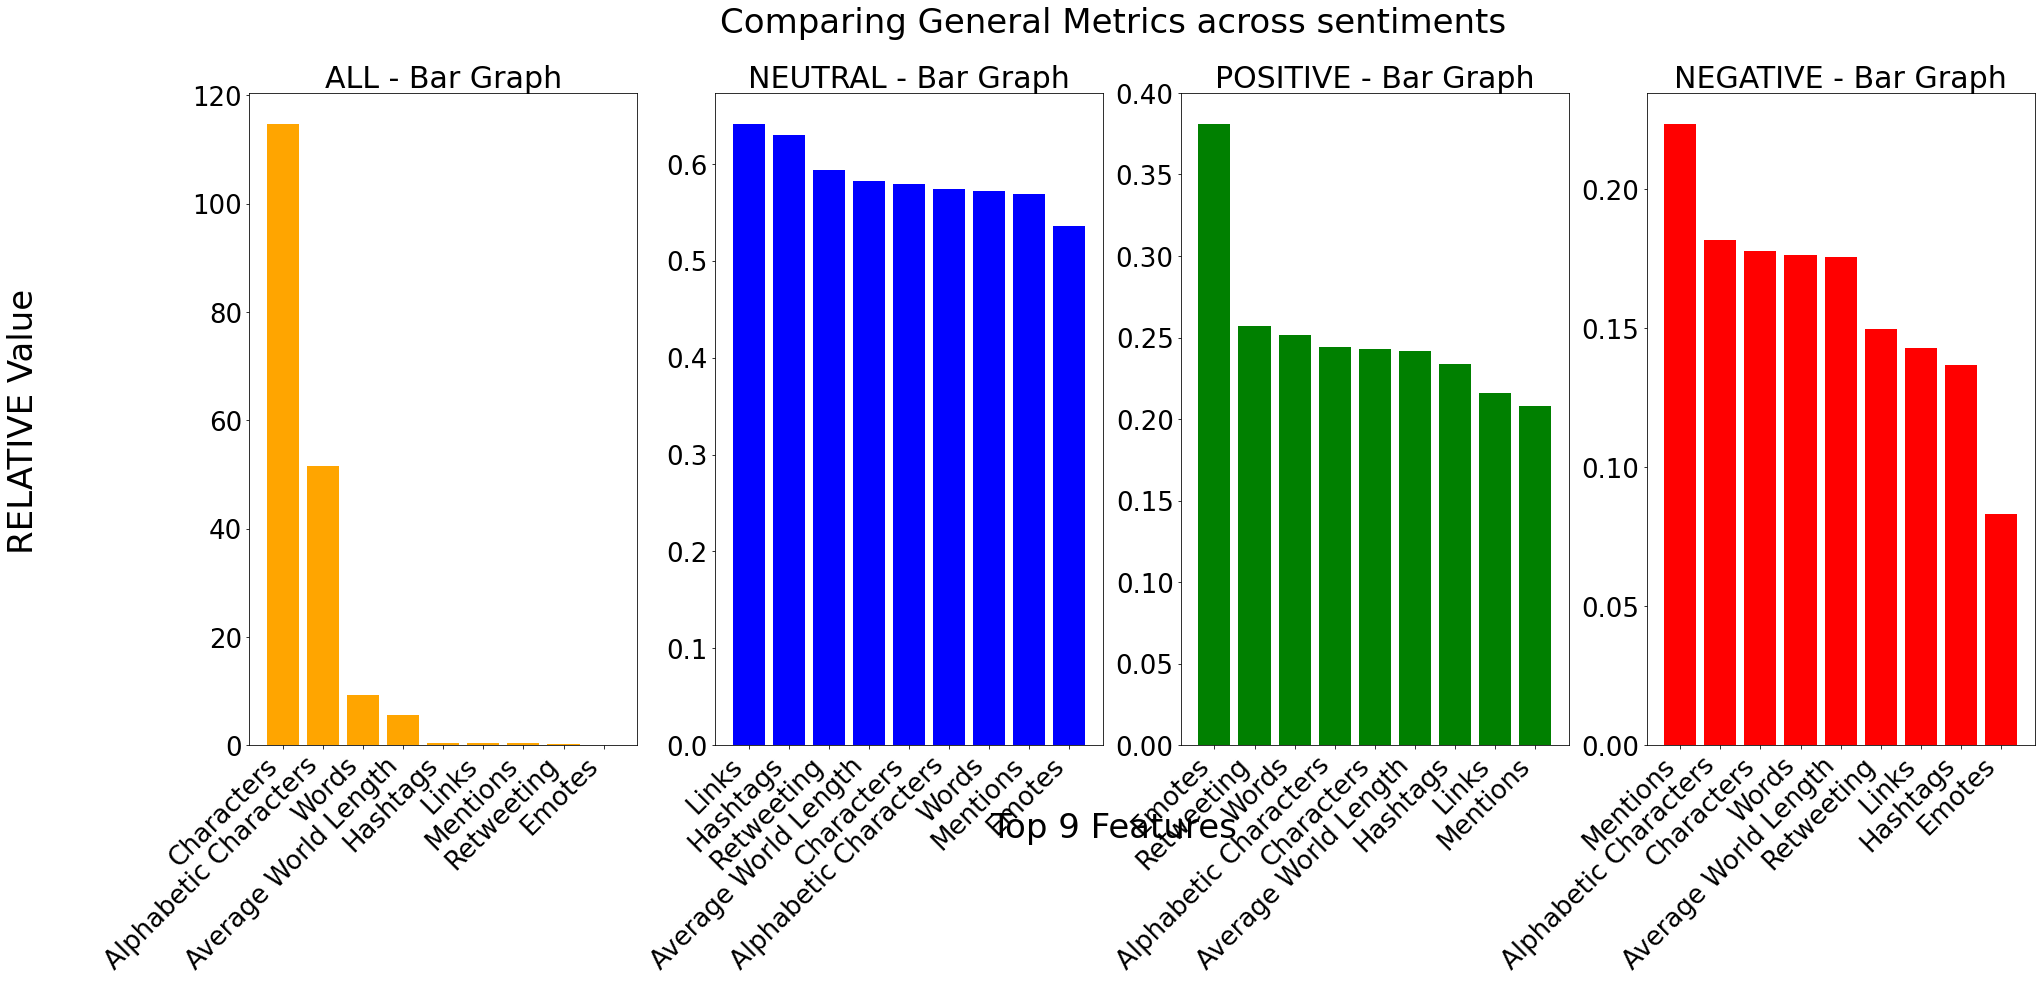

In [ ]:
FEATURE_METRICS = 'General Metrics'
def dictorizer_metrics(tweets: list[str], tweets_cleaned: list[str]): 
    dict_list = []
    for t, t_clean in zip(tweets, tweets_cleaned):
        wlist = t_clean.split(' ')
        total_wlen = 0
        for w in wlist:
            total_wlen += len(w)

        t_dict = {
            'Links': len(RE_LINKS.findall(t)),
            'Hashtags': len(RE_HASHTAGS.findall(t)),
            'Mentions': len(RE_MENTIONS.findall(t)),
            'Words': len(wlist),
            'Average World Length': total_wlen / len(wlist),
            'Emotes': len(RE_EMOTES.findall(t)),
            'Retweeting': ('"' in t),
            'Characters': len(t),
            'Alphabetic Characters': len(re.sub(r' +', '', t_clean))
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
dv_metrics = DictVectorizer()
X_train_features[FEATURE_METRICS] = dv_metrics.fit_transform(dictorizer_metrics(train_df['text'], train_df['text-clean']))
X_test_features[FEATURE_METRICS] = dv_metrics.transform(dictorizer_metrics(test_df['text'], test_df['text-clean']))
compare_bars(X_train_features[FEATURE_METRICS], y, dv_metrics.get_feature_names_out(), FEATURE_METRICS)

## 5. Model Selection

Selecting, training, and evaluating possible models.

### Helper Functions

In [ ]:
# Combine the chosen tokens into one matrix
# Generate the final train and test sets
def combine_X_matrices(train_dict: dict, test_dict: dict, feature_types: list[str]):
    X_Train = hstack([train_dict[ft] for ft in feature_types])
    X_Test = hstack([test_dict[ft] for ft in feature_types])
    
    return (X_Train, X_Test)

### Generating Features

In [ ]:
# Choose the features for the train and test sets
CHOSEN_FEATURES = [
    FEATURE_HASHTAGS_COUNT,
    FEATURE_MENTIONS_COUNT,
    FEATURE_LINKS_COUNT,
    FEATURE_POS_TAGS_COUNT, 
    FEATURE_WORDS_COUNT, 
    FEATURE_WORD_2GRAMS_COUNT,
    FEATURE_PUNCTUATION_TFIDF,
    FEATURE_EMOTICONS_SIMPLE_TFIDF,
    FEATURE_METRICS]
X_train, X_test = combine_X_matrices(X_train_features, X_test_features, CHOSEN_FEATURES)

print(f'\tModified Training Set Shape: {X_train.shape}')
print(f'\tModified Testing Set Shape: {X_test.shape}')

	Modified Training Set Shape: (21802, 14454)
	Modified Testing Set Shape: (6099, 14454)


### Evaluation Function

In [ ]:
def evaluate(model, X:csr_matrix, y, model_name:str = '', cv:int = 5, display:bool = True):

    # Create the output list for evaluations
    output = []

    if display:
        print(type(model))

    for i in range(cv):      
        # extract the split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 / cv)

        # fit the data and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # append a dictionary of the evaluation summaries
        output.append({
            'data': (X_train, X_test, y_train, y_test, y_pred),
            'evaluation-string': classification_report(y_test, y_pred, zero_division=0),
            'evaluation': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
            'confusion-matrix': confusion_matrix(y_test, y_pred)
        })

        # display the stuff if needed
        if display:
            print(output[i]['evaluation-string'])
            plt.figure(figsize=(32, 18))
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
            plt.title(f'{model_name}\nConfusion Matrix (cv={i+1}/{cv})')
            plt.savefig(f'../report/img/cf/{model_name}-cv-{i+1}-of-{cv}', bbox_inches='tight')

    # finally, evaluate on the whole set
    # fit the data and predict
    model.fit(X, y)
    y_pred = model.predict(X)

    overall_dict = {
        'data': (X, X, y, y, y_pred),
        'evaluation-string': classification_report(y, y_pred, zero_division=0),
        'evaluation': classification_report(y, y_pred, output_dict=True, zero_division=0),
        'confusion-matrix': confusion_matrix(y, y_pred)
    }

    # display the overall results if needed
    if display:
        print(overall_dict['evaluation-string'])
        plt.figure(figsize=(32, 18))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, xticks_rotation=45)
        plt.title(f'{model_name}\nConfusion Matrix (Overall)')
        plt.savefig(f'../report/img/cf/{model_name}-overall', bbox_inches='tight')

    return (output, overall_dict)


### Baseline Model (0-R)

<class 'sklearn.dummy.DummyClassifier'>
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       731
     neutral       0.58      1.00      0.73      2532
    positive       0.00      0.00      0.00      1098

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.34      0.58      0.43      4361

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       741
     neutral       0.58      1.00      0.74      2544
    positive       0.00      0.00      0.00      1076

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.25      4361
weighted avg       0.34      0.58      0.43      4361

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       753
     neutral       0.58      1.00      0.73      2509
    positive       0.00      0.00  

<Figure size 2304x1296 with 0 Axes>

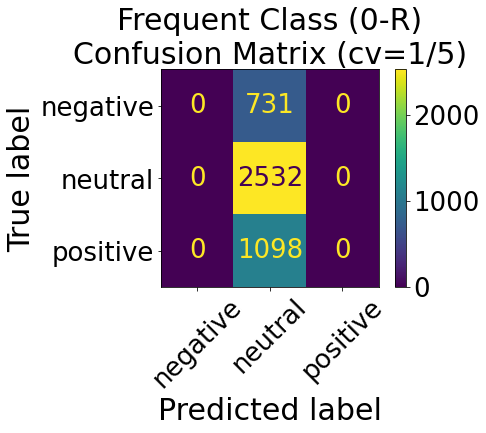

<Figure size 2304x1296 with 0 Axes>

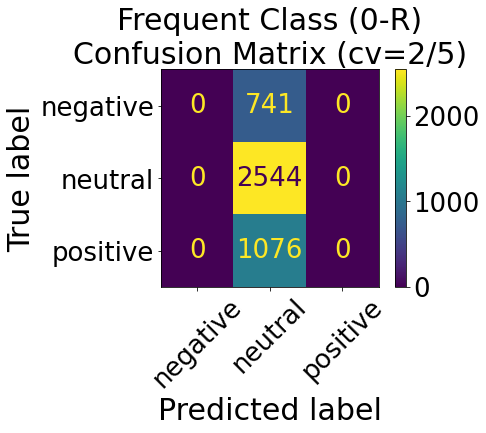

<Figure size 2304x1296 with 0 Axes>

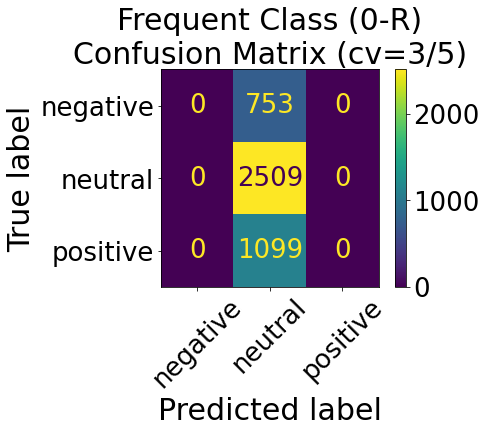

<Figure size 2304x1296 with 0 Axes>

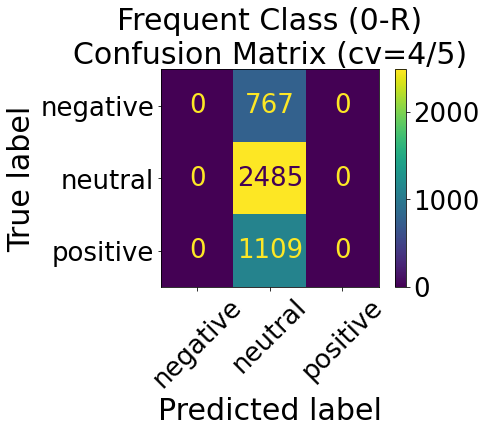

<Figure size 2304x1296 with 0 Axes>

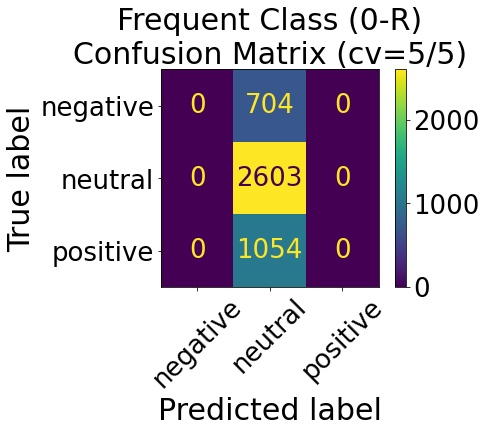

<Figure size 2304x1296 with 0 Axes>

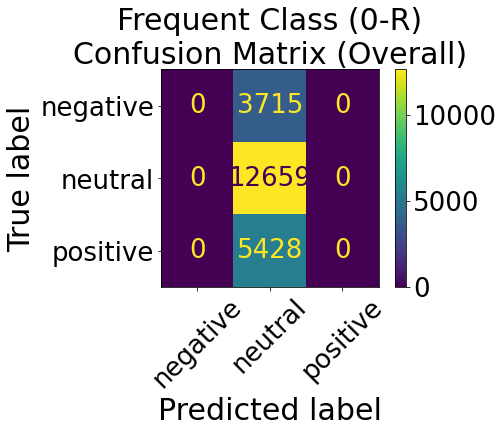

In [ ]:
# create the baseline model
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y)

# Evaluate the baseline model
baseline_results = evaluate(baseline, X_train, y, 'Frequent Class (0-R)')

### Multinomial Naive Bayes

In [ ]:
# Default mnb
mnb = MultinomialNB()
mnb_results = evaluate(mnb, X_train, y, 'Multinomial Naive Bayes')

# mnb without smoothing
mnb_no_smoothing = MultinomialNB(alpha=0)
mnb_no_smoothing_results = evaluate(mnb_no_smoothing, X_train, y, 'Multinomial Naive Bayes (Without Smoothing)')

# mnb with priors
mnb_without_priors = MultinomialNB(fit_prior=False)
mnb_without_priors_results = evaluate(mnb_without_priors, X_train, y, 'Multinomial Naive Bayes (Without Priors)')

<class 'sklearn.naive_bayes.MultinomialNB'>
              precision    recall  f1-score   support

    negative       0.42      0.63      0.50       744
     neutral       0.73      0.55      0.63      2544
    positive       0.51      0.63      0.56      1073

    accuracy                           0.59      4361
   macro avg       0.55      0.60      0.57      4361
weighted avg       0.63      0.59      0.59      4361

              precision    recall  f1-score   support

    negative       0.43      0.65      0.52       753
     neutral       0.74      0.55      0.63      2553
    positive       0.51      0.63      0.56      1055

    accuracy                           0.59      4361
   macro avg       0.56      0.61      0.57      4361
weighted avg       0.63      0.59      0.60      4361

              precision    recall  f1-score   support

    negative       0.42      0.62      0.50       767
     neutral       0.72      0.55      0.62      2540
    positive       0.50      0.

### Bernoulli Naive Bayes

<class 'sklearn.naive_bayes.BernoulliNB'>
              precision    recall  f1-score   support

    negative       0.39      0.66      0.49       692
     neutral       0.75      0.53      0.62      2601
    positive       0.51      0.65      0.57      1068

    accuracy                           0.58      4361
   macro avg       0.55      0.61      0.56      4361
weighted avg       0.63      0.58      0.59      4361

              precision    recall  f1-score   support

    negative       0.41      0.62      0.49       772
     neutral       0.71      0.53      0.60      2501
    positive       0.51      0.63      0.56      1088

    accuracy                           0.57      4361
   macro avg       0.54      0.59      0.55      4361
weighted avg       0.61      0.57      0.57      4361

              precision    recall  f1-score   support

    negative       0.40      0.63      0.49       727
     neutral       0.73      0.52      0.61      2539
    positive       0.52      0.67

C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.41      0.62      0.49       757
     neutral       0.71      0.50      0.59      2565
    positive       0.47      0.62      0.53      1039

    accuracy                           0.55      4361
   macro avg       0.53      0.58      0.54      4361
weighted avg       0.60      0.55      0.56      4361



C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.40      0.61      0.48       753
     neutral       0.72      0.51      0.60      2528
    positive       0.50      0.65      0.57      1080

    accuracy                           0.56      4361
   macro avg       0.54      0.59      0.55      4361
weighted avg       0.61      0.56      0.57      4361



C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.41      0.60      0.49       753
     neutral       0.71      0.51      0.59      2522
    positive       0.49      0.67      0.57      1086

    accuracy                           0.56      4361
   macro avg       0.54      0.59      0.55      4361
weighted avg       0.61      0.56      0.57      4361



C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.40      0.61      0.48       729
     neutral       0.72      0.51      0.59      2557
    positive       0.48      0.66      0.56      1075

    accuracy                           0.56      4361
   macro avg       0.54      0.59      0.55      4361
weighted avg       0.61      0.56      0.57      4361



C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\Xavier Travers\AppData\Local\Temp\ipykernel_27384\324720599.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(32, 18))


              precision    recall  f1-score   support

    negative       0.40      0.62      0.49       770
     neutral       0.72      0.51      0.60      2560
    positive       0.48      0.64      0.55      1031

    accuracy                           0.56      4361
   macro avg       0.54      0.59      0.55      4361
weighted avg       0.61      0.56      0.57      4361



C:\Python310\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.48      0.74      0.59      3715
     neutral       0.82      0.58      0.68     12659
    positive       0.56      0.75      0.64      5428

    accuracy                           0.65     21802
   macro avg       0.62      0.69      0.63     21802
weighted avg       0.70      0.65      0.65     21802

<class 'sklearn.naive_bayes.BernoulliNB'>
              precision    recall  f1-score   support

    negative       0.42      0.68      0.52       777
     neutral       0.74      0.48      0.58      2485
    positive       0.51      0.69      0.59      1099

    accuracy                           0.57      4361
   macro avg       0.56      0.62      0.56      4361
weighted avg       0.63      0.57      0.57      4361

              precision    recall  f1-score   support

    negative       0.41      0.69      0.52       753
     neutral       0.74      0.48      0.58      2449
    positive       0.53      0.69

<Figure size 2304x1296 with 0 Axes>

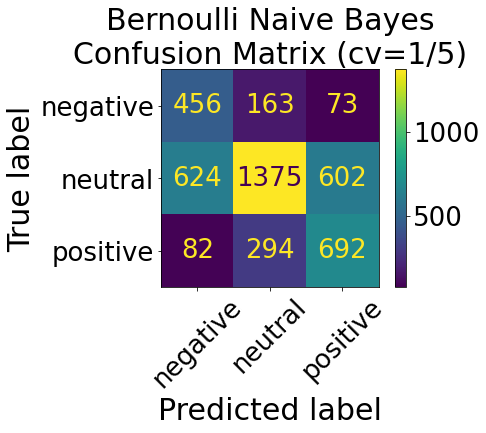

<Figure size 2304x1296 with 0 Axes>

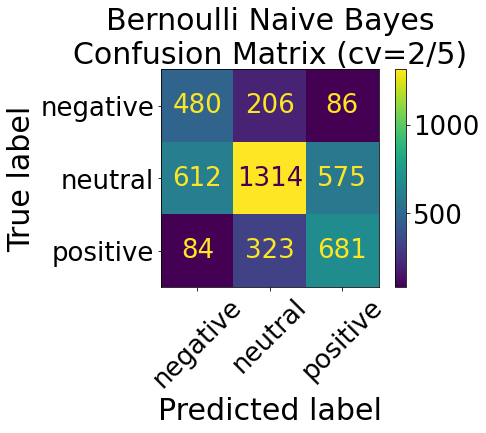

<Figure size 2304x1296 with 0 Axes>

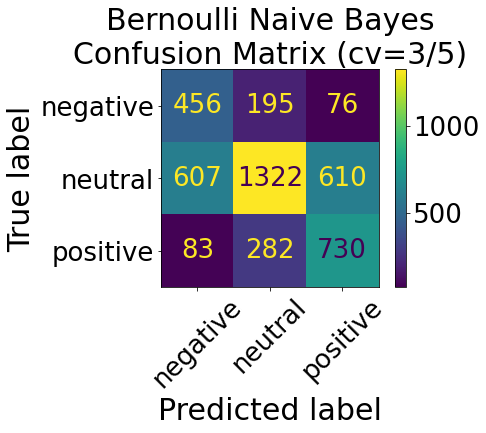

<Figure size 2304x1296 with 0 Axes>

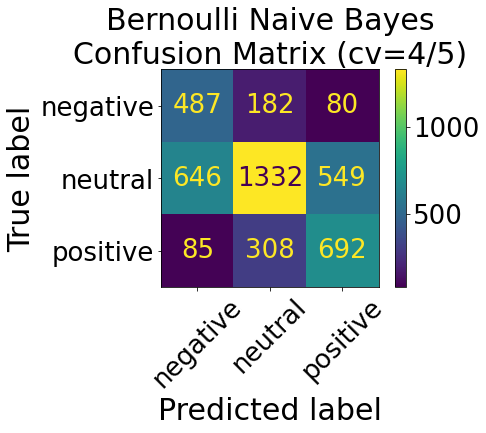

<Figure size 2304x1296 with 0 Axes>

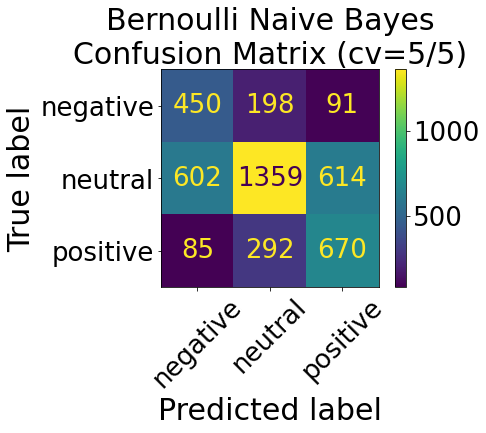

<Figure size 2304x1296 with 0 Axes>

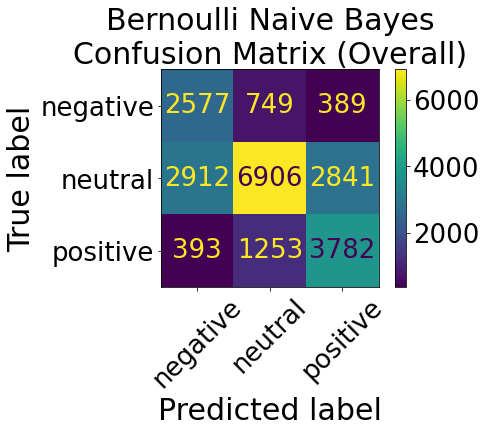

<Figure size 2304x1296 with 0 Axes>

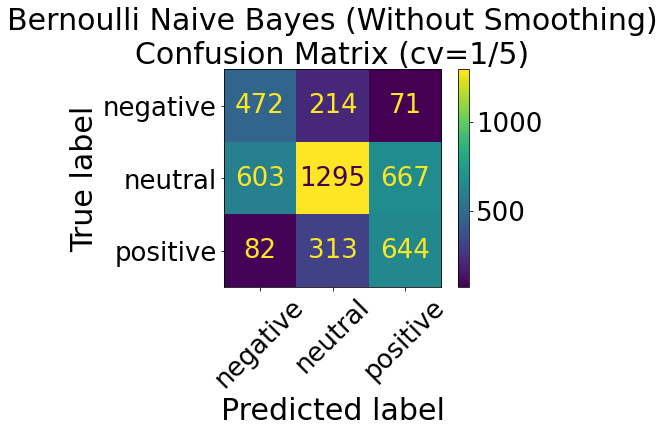

<Figure size 2304x1296 with 0 Axes>

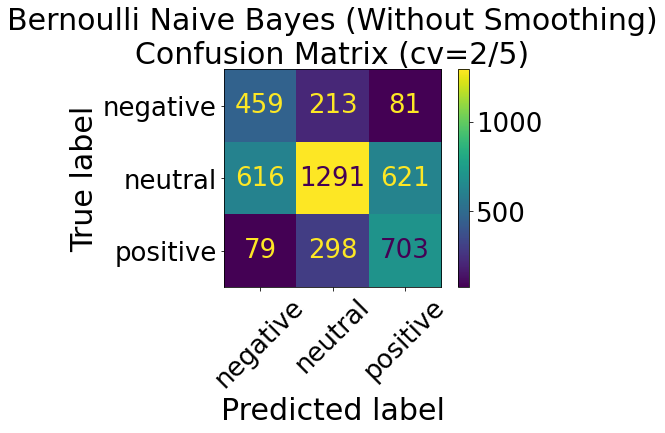

<Figure size 2304x1296 with 0 Axes>

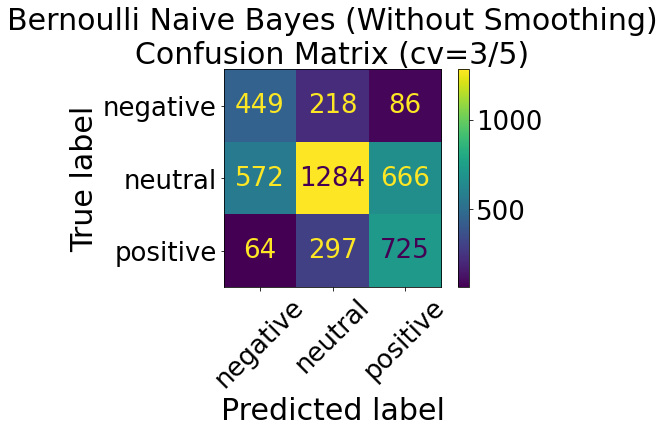

<Figure size 2304x1296 with 0 Axes>

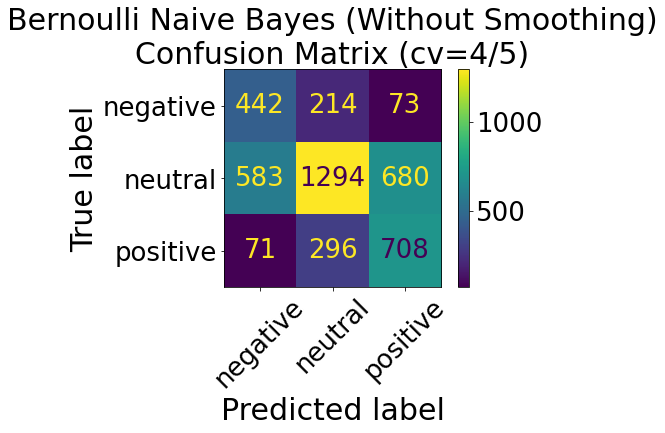

<Figure size 2304x1296 with 0 Axes>

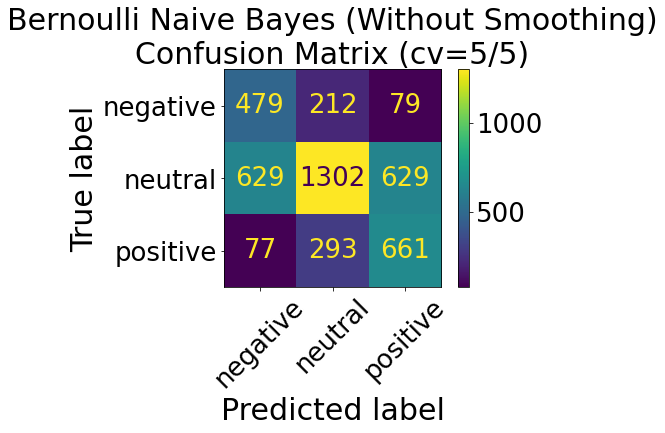

<Figure size 2304x1296 with 0 Axes>

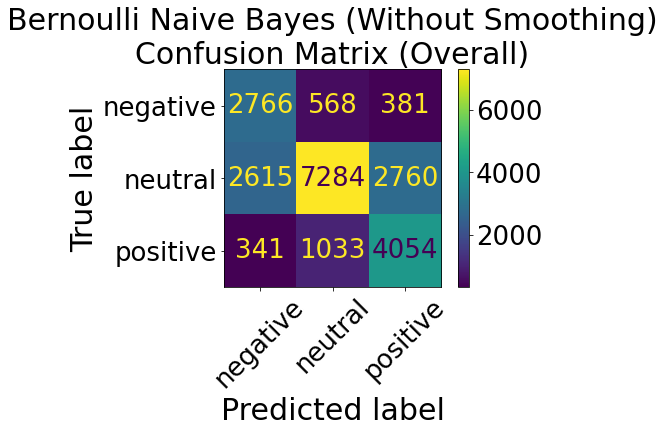

<Figure size 2304x1296 with 0 Axes>

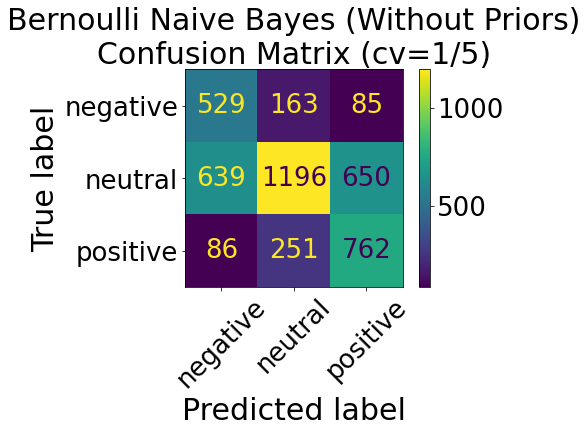

<Figure size 2304x1296 with 0 Axes>

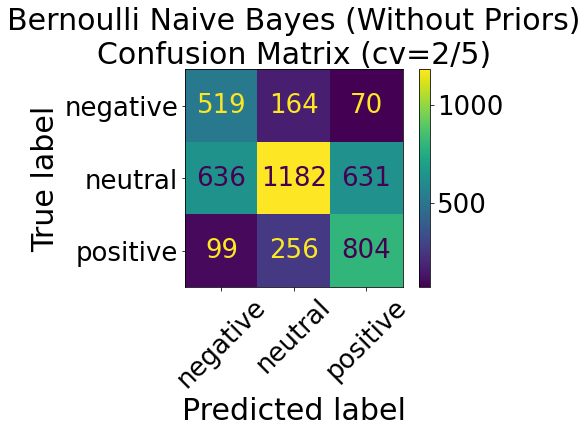

<Figure size 2304x1296 with 0 Axes>

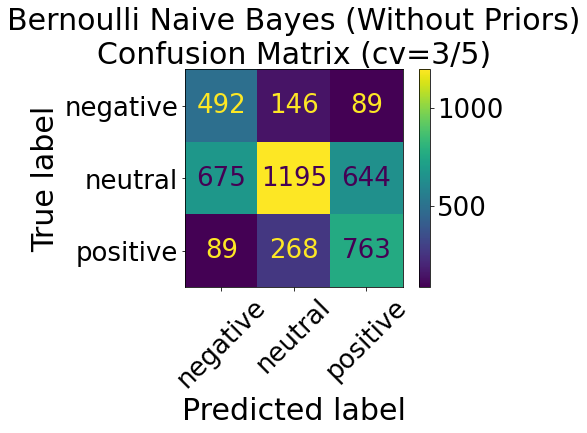

<Figure size 2304x1296 with 0 Axes>

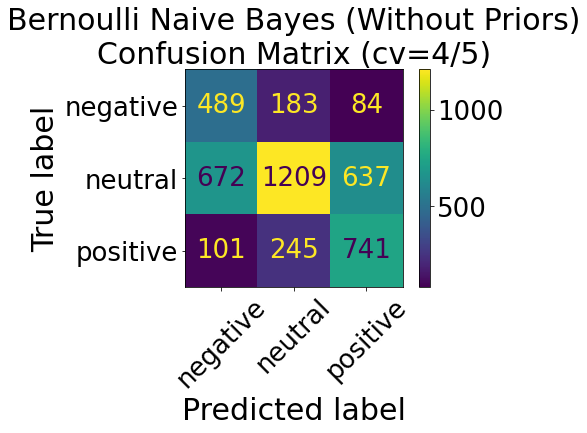

<Figure size 2304x1296 with 0 Axes>

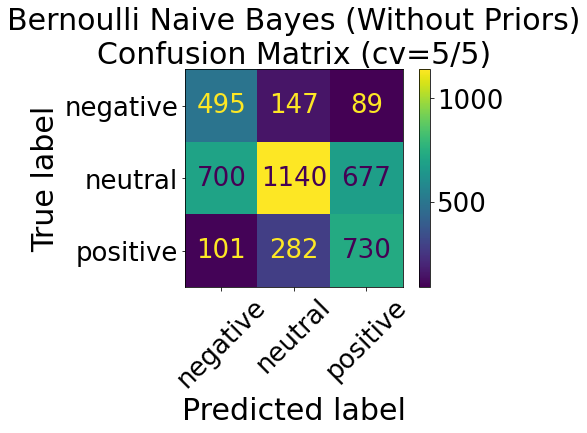

<Figure size 2304x1296 with 0 Axes>

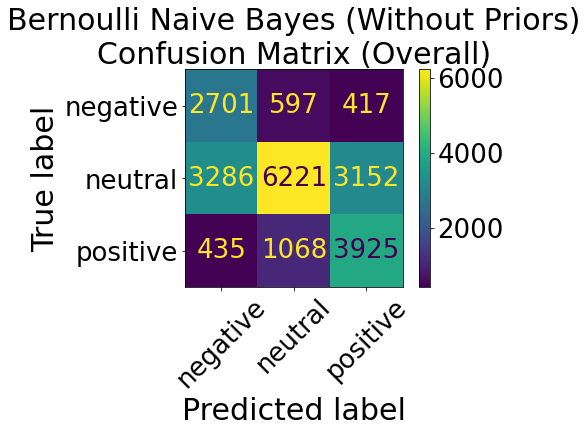

In [ ]:
# Default bnb
bnb = BernoulliNB()
bnb_results = evaluate(bnb, X_train, y, 'Bernoulli Naive Bayes')

# bnb without smoothing
bnb_no_smoothing = BernoulliNB(alpha=0)
bnb_no_smoothing_results = evaluate(bnb_no_smoothing, X_train, y, 'Bernoulli Naive Bayes (Without Smoothing)')

# bnb with priors
bnb_without_priors = BernoulliNB(fit_prior=False)
bnb_without_priors_results = evaluate(bnb_without_priors, X_train, y, 'Bernoulli Naive Bayes (Without Priors)')

### Logistic Regression

<class 'sklearn.linear_model._logistic.LogisticRegression'>


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.42      0.10      0.16       767
     neutral       0.61      0.91      0.73      2512
    positive       0.61      0.25      0.35      1082

    accuracy                           0.60      4361
   macro avg       0.55      0.42      0.41      4361
weighted avg       0.58      0.60      0.53      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.41      0.12      0.19       736
     neutral       0.63      0.87      0.73      2581
    positive       0.54      0.28      0.36      1044

    accuracy                           0.60      4361
   macro avg       0.52      0.42      0.43      4361
weighted avg       0.57      0.60      0.55      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.44      0.13      0.20       735
     neutral       0.62      0.87      0.73      2551
    positive       0.53      0.28      0.37      1075

    accuracy                           0.60      4361
   macro avg       0.53      0.43      0.43      4361
weighted avg       0.57      0.60      0.55      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.49      0.12      0.20       742
     neutral       0.61      0.91      0.73      2518
    positive       0.58      0.22      0.32      1101

    accuracy                           0.60      4361
   macro avg       0.56      0.42      0.42      4361
weighted avg       0.58      0.60      0.54      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.42      0.10      0.16       715
     neutral       0.62      0.91      0.74      2592
    positive       0.55      0.22      0.31      1054

    accuracy                           0.61      4361
   macro avg       0.53      0.41      0.40      4361
weighted avg       0.57      0.61      0.54      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.51      0.10      0.17      3715
     neutral       0.61      0.93      0.74     12659
    positive       0.61      0.23      0.33      5428

    accuracy                           0.61     21802
   macro avg       0.58      0.42      0.41     21802
weighted avg       0.60      0.61      0.54     21802

<class 'sklearn.linear_model._logistic.LogisticRegression'>


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.42      0.08      0.14       739
     neutral       0.61      0.90      0.73      2534
    positive       0.58      0.25      0.35      1088

    accuracy                           0.60      4361
   macro avg       0.53      0.41      0.41      4361
weighted avg       0.57      0.60      0.53      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.42      0.10      0.16       716
     neutral       0.62      0.88      0.73      2594
    positive       0.48      0.24      0.32      1051

    accuracy                           0.60      4361
   macro avg       0.51      0.41      0.40      4361
weighted avg       0.55      0.60      0.54      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.43      0.07      0.12       754
     neutral       0.61      0.92      0.73      2535
    positive       0.60      0.25      0.35      1072

    accuracy                           0.61      4361
   macro avg       0.55      0.41      0.40      4361
weighted avg       0.58      0.61      0.53      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.42      0.11      0.18       736
     neutral       0.61      0.89      0.73      2533
    positive       0.56      0.25      0.34      1092

    accuracy                           0.60      4361
   macro avg       0.53      0.42      0.42      4361
weighted avg       0.57      0.60      0.54      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Xavier Travers\AppData\Local\Temp\ipykernel_27384\324720599.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(32, 18))


              precision    recall  f1-score   support

    negative       0.41      0.14      0.21       746
     neutral       0.62      0.87      0.72      2522
    positive       0.57      0.30      0.39      1093

    accuracy                           0.60      4361
   macro avg       0.53      0.44      0.44      4361
weighted avg       0.57      0.60      0.55      4361



C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.49      0.13      0.20      3715
     neutral       0.62      0.91      0.74     12659
    positive       0.60      0.25      0.35      5428

    accuracy                           0.61     21802
   macro avg       0.57      0.43      0.43     21802
weighted avg       0.59      0.61      0.55     21802



<Figure size 2304x1296 with 0 Axes>

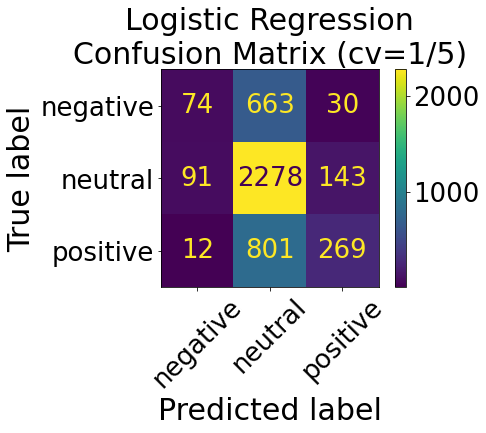

<Figure size 2304x1296 with 0 Axes>

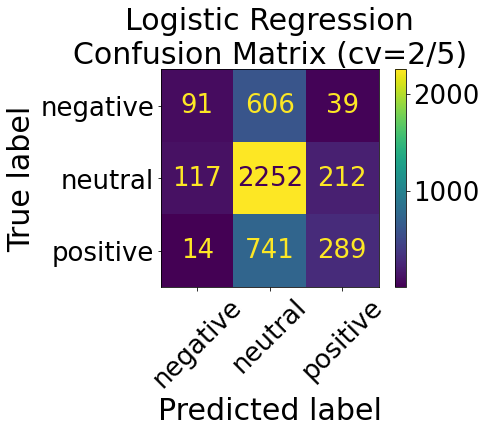

<Figure size 2304x1296 with 0 Axes>

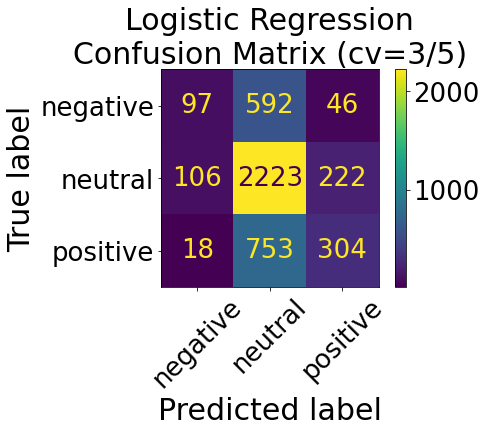

<Figure size 2304x1296 with 0 Axes>

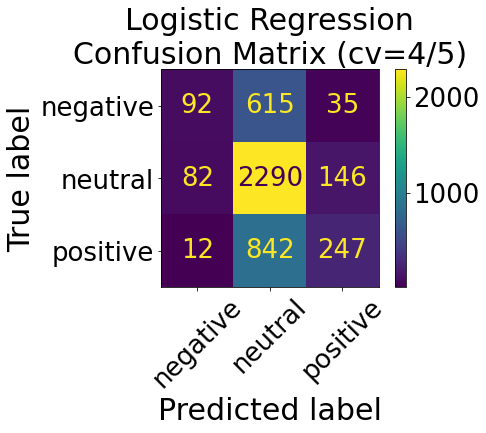

<Figure size 2304x1296 with 0 Axes>

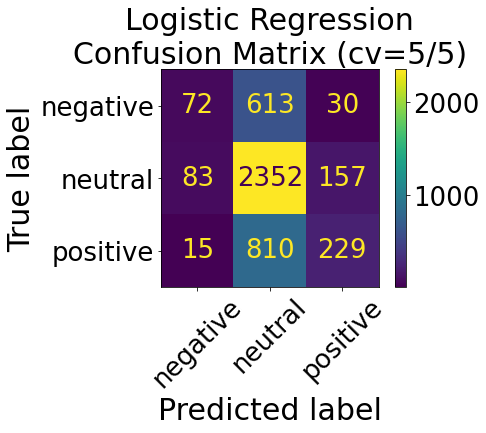

<Figure size 2304x1296 with 0 Axes>

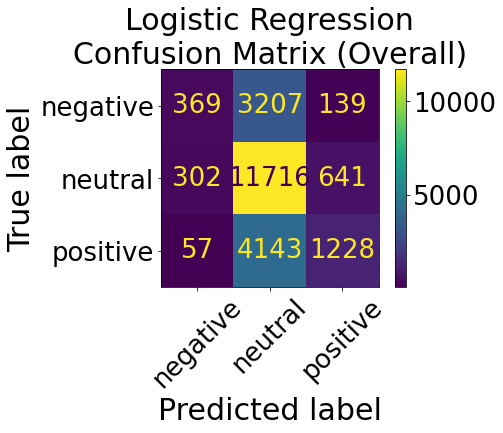

<Figure size 2304x1296 with 0 Axes>

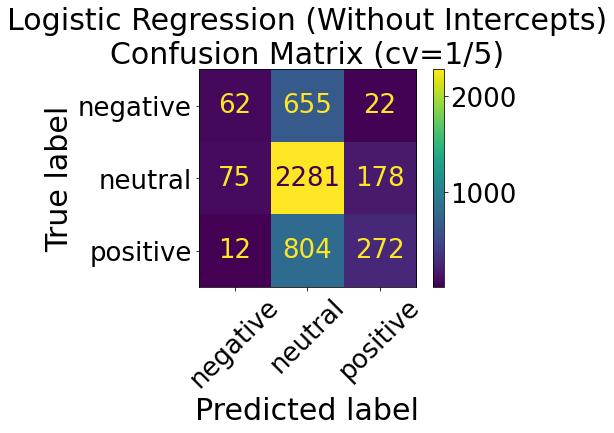

<Figure size 2304x1296 with 0 Axes>

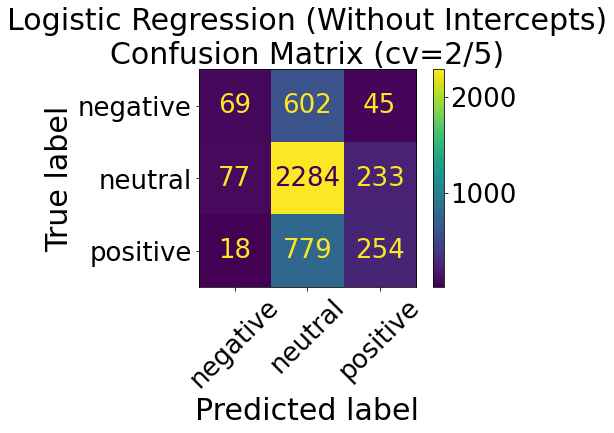

<Figure size 2304x1296 with 0 Axes>

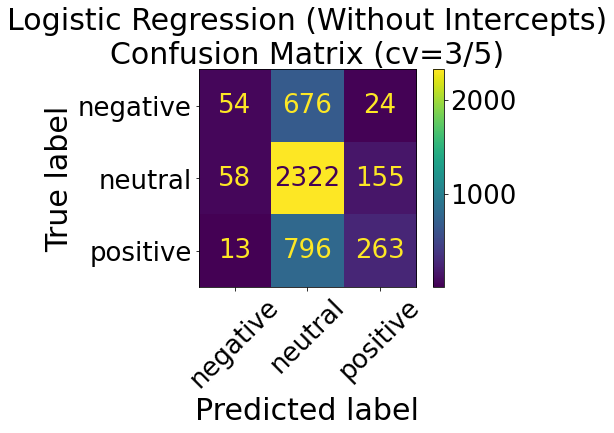

<Figure size 2304x1296 with 0 Axes>

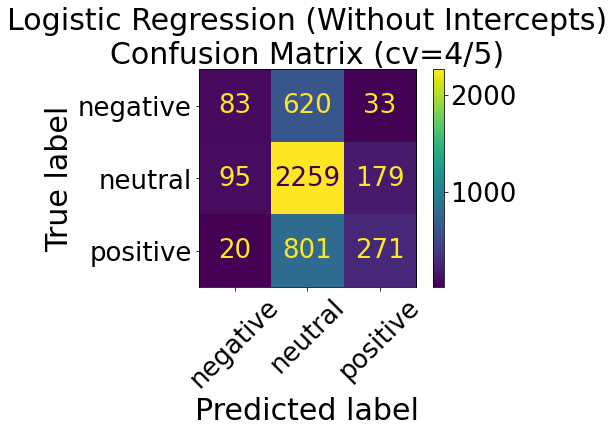

<Figure size 2304x1296 with 0 Axes>

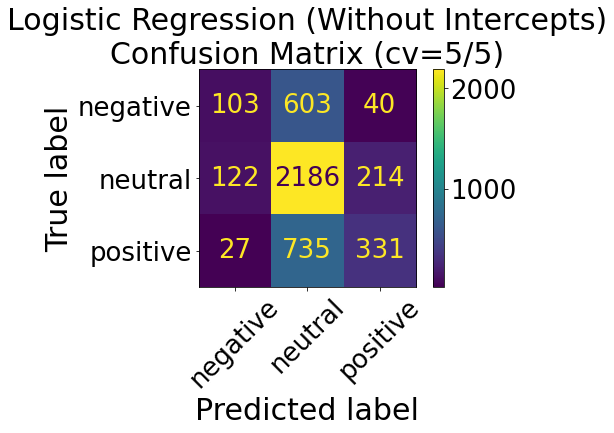

<Figure size 2304x1296 with 0 Axes>

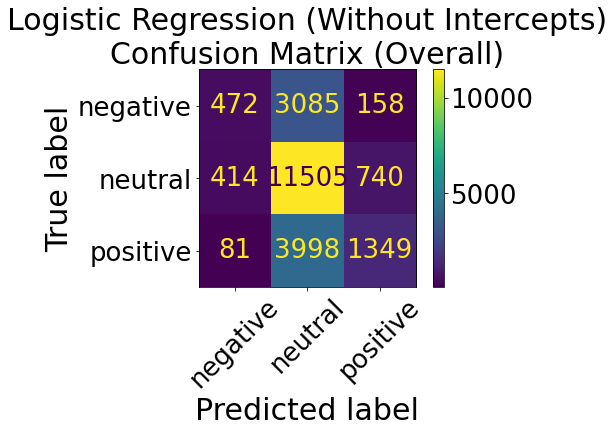

In [ ]:
# Default logreg
logreg = LogisticRegression()
logreg_results = evaluate(logreg, X_train, y, 'Logistic Regression')

# logreg without an intercept term
logreg_fit_intercept = LogisticRegression(fit_intercept=False)
logreg_fit_intercept_results = evaluate(logreg_fit_intercept, X_train, y, 'Logistic Regression (Without Intercepts)')

### Decision Tree

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

    negative       0.29      0.27      0.28       754
     neutral       0.62      0.64      0.63      2498
    positive       0.42      0.40      0.41      1109

    accuracy                           0.52      4361
   macro avg       0.44      0.44      0.44      4361
weighted avg       0.51      0.52      0.51      4361

              precision    recall  f1-score   support

    negative       0.31      0.28      0.29       758
     neutral       0.63      0.67      0.65      2522
    positive       0.42      0.40      0.41      1081

    accuracy                           0.53      4361
   macro avg       0.45      0.45      0.45      4361
weighted avg       0.52      0.53      0.53      4361

              precision    recall  f1-score   support

    negative       0.28      0.27      0.28       740
     neutral       0.63      0.63      0.63      2583
    positive       0

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       727
     neutral       0.59      0.99      0.74      2538
    positive       0.61      0.06      0.10      1096

    accuracy                           0.59      4361
   macro avg       0.40      0.35      0.28      4361
weighted avg       0.50      0.59      0.45      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       732
     neutral       0.59      0.99      0.74      2527
    positive       0.71      0.08      0.14      1102

    accuracy                           0.59      4361
   macro avg       0.43      0.35      0.29      4361
weighted avg       0.52      0.59      0.46      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       758
     neutral       0.58      0.99      0.73      2495
    positive       0.69      0.06      0.12      1108

    accuracy                           0.58      4361
   macro avg       0.42      0.35      0.28      4361
weighted avg       0.51      0.58      0.45      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       745
     neutral       0.58      0.99      0.73      2503
    positive       0.69      0.07      0.12      1113

    accuracy                           0.58      4361
   macro avg       0.42      0.35      0.28      4361
weighted avg       0.51      0.58      0.45      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       735
     neutral       0.60      0.99      0.75      2572
    positive       0.68      0.08      0.14      1054

    accuracy                           0.60      4361
   macro avg       0.43      0.35      0.29      4361
weighted avg       0.52      0.60      0.47      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      3715
     neutral       0.59      0.99      0.74     12659
    positive       0.69      0.07      0.12      5428

    accuracy                           0.59     21802
   macro avg       0.42      0.35      0.29     21802
weighted avg       0.51      0.59      0.46     21802

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              precision    recall  f1-score   support

    negative       0.30      0.27      0.28       720
     neutral       0.65      0.69      0.67      2613
    positive       0.42      0.37      0.39      1028

    accuracy                           0.55      4361
   macro avg       0.45      0.44      0.45      4361
weighted avg       0.53      0.55      0.54      4361

              precision    recall  f1-score   support

    negative       0.32      0.31      0.31       684
     neutral       0.65      0.70      0.67      2557
    positive       0

<Figure size 2304x1296 with 0 Axes>

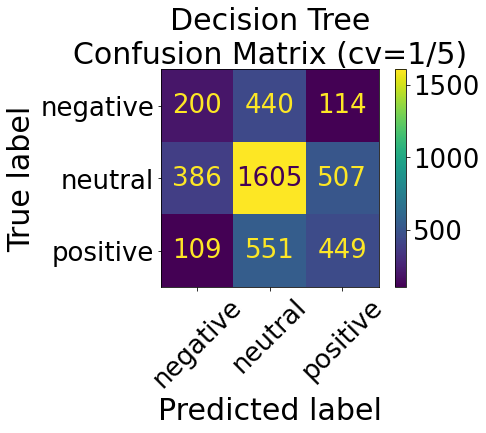

<Figure size 2304x1296 with 0 Axes>

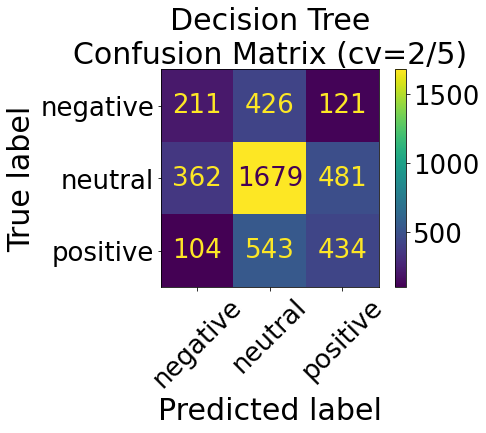

<Figure size 2304x1296 with 0 Axes>

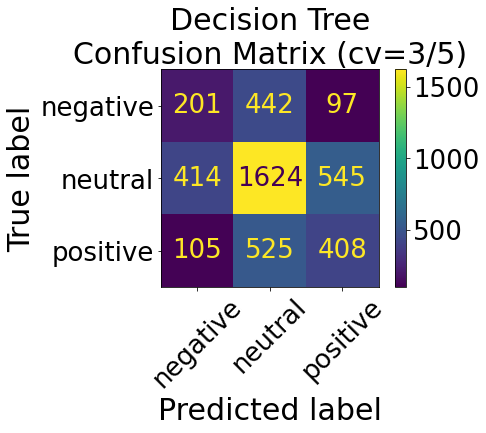

<Figure size 2304x1296 with 0 Axes>

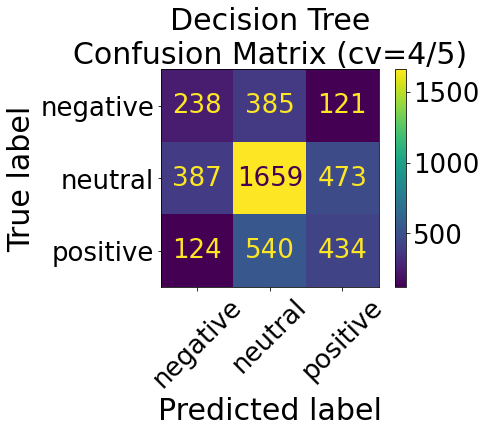

<Figure size 2304x1296 with 0 Axes>

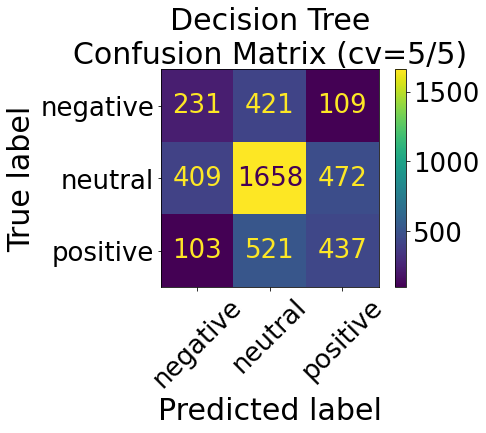

<Figure size 2304x1296 with 0 Axes>

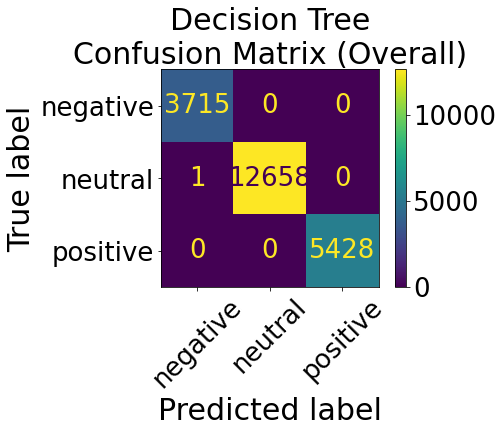

<Figure size 2304x1296 with 0 Axes>

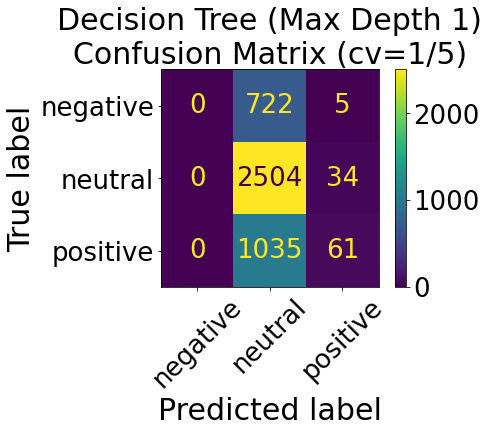

<Figure size 2304x1296 with 0 Axes>

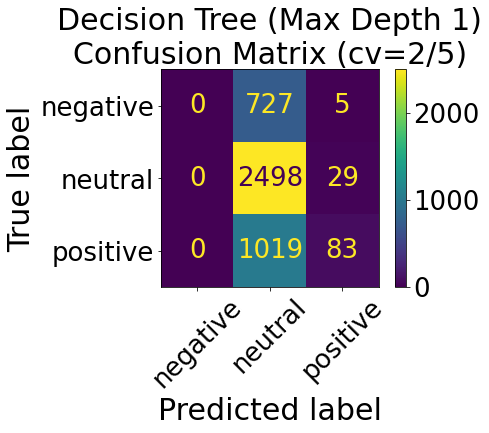

<Figure size 2304x1296 with 0 Axes>

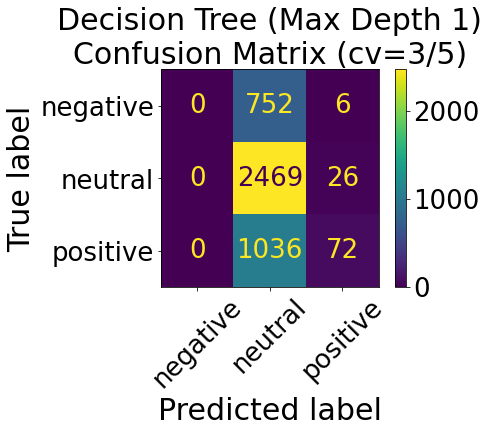

<Figure size 2304x1296 with 0 Axes>

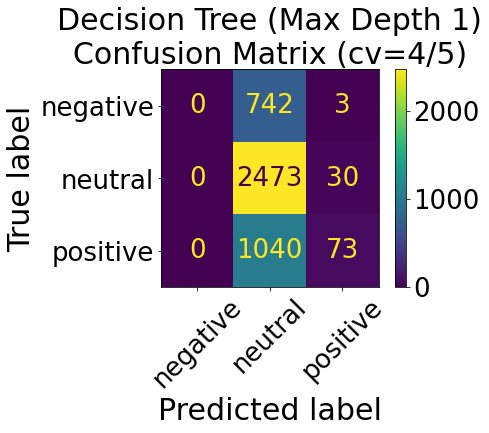

<Figure size 2304x1296 with 0 Axes>

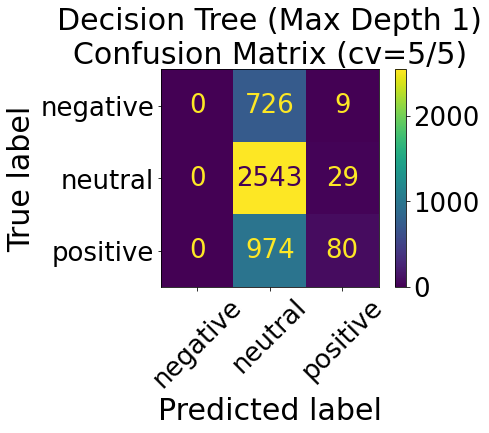

<Figure size 2304x1296 with 0 Axes>

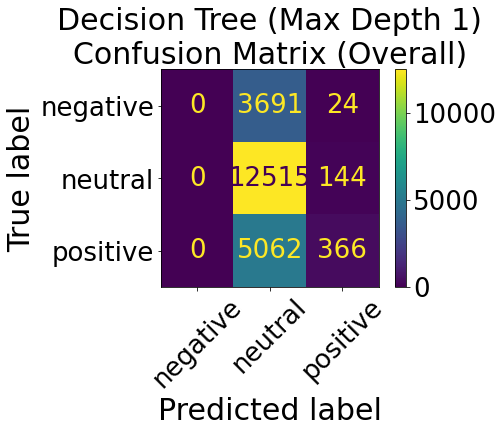

<Figure size 2304x1296 with 0 Axes>

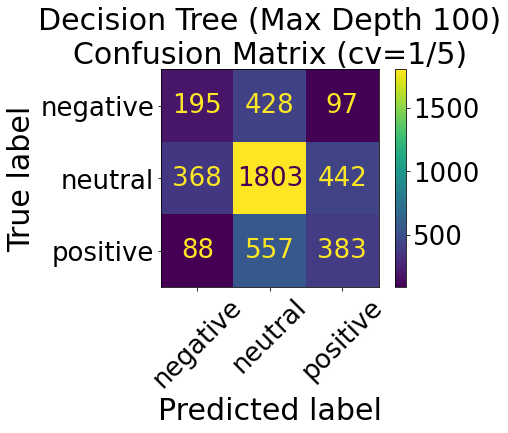

<Figure size 2304x1296 with 0 Axes>

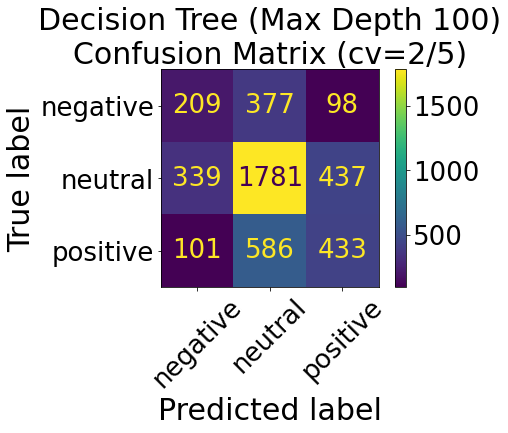

<Figure size 2304x1296 with 0 Axes>

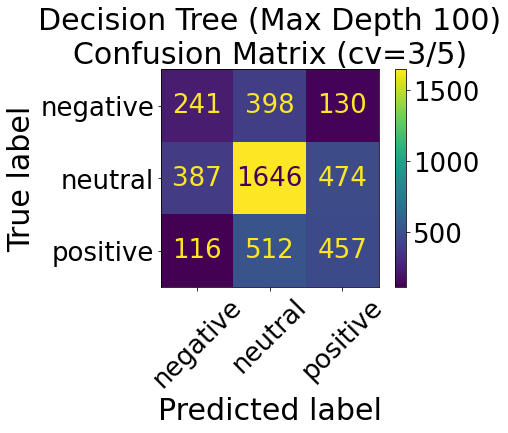

<Figure size 2304x1296 with 0 Axes>

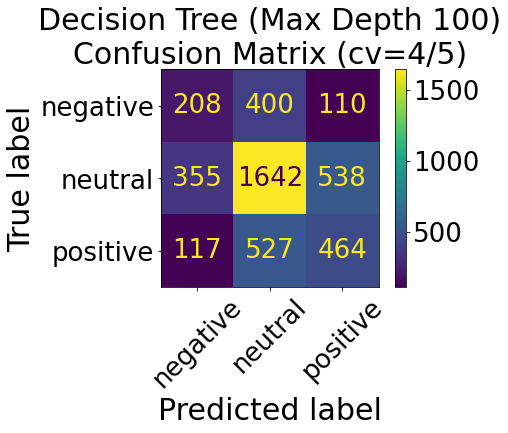

<Figure size 2304x1296 with 0 Axes>

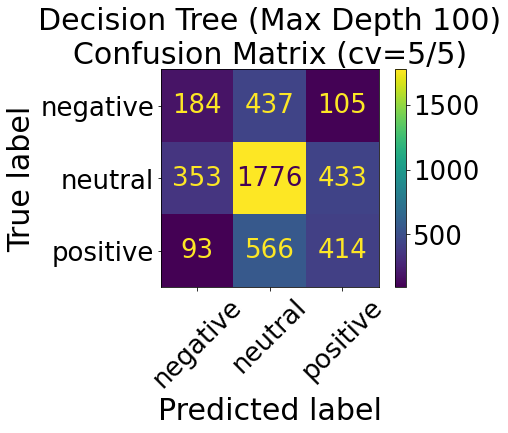

<Figure size 2304x1296 with 0 Axes>

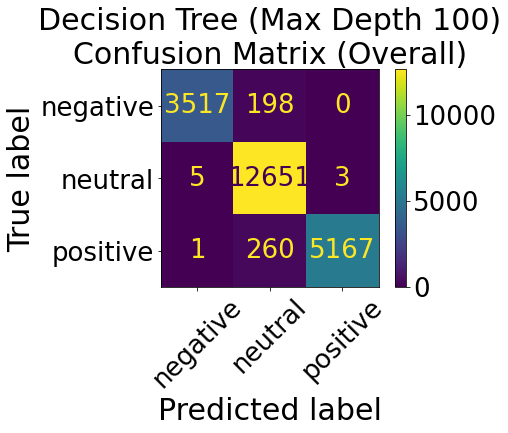

<Figure size 2304x1296 with 0 Axes>

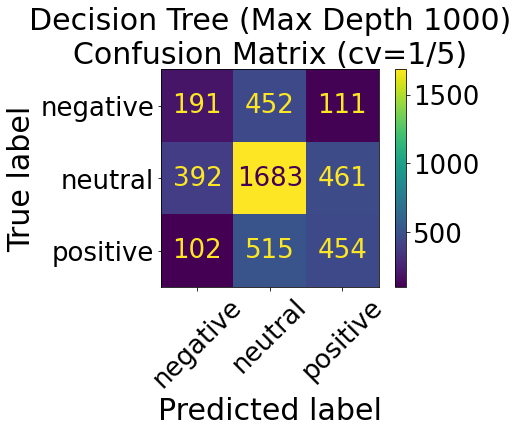

<Figure size 2304x1296 with 0 Axes>

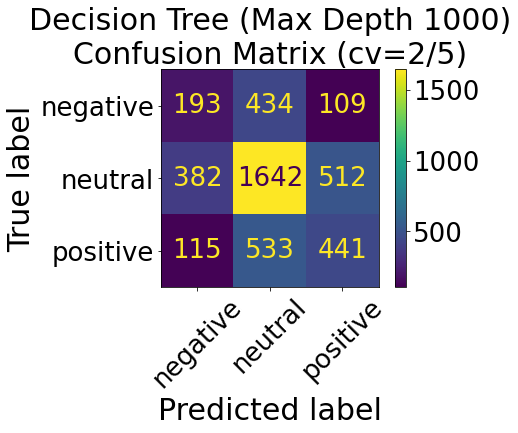

<Figure size 2304x1296 with 0 Axes>

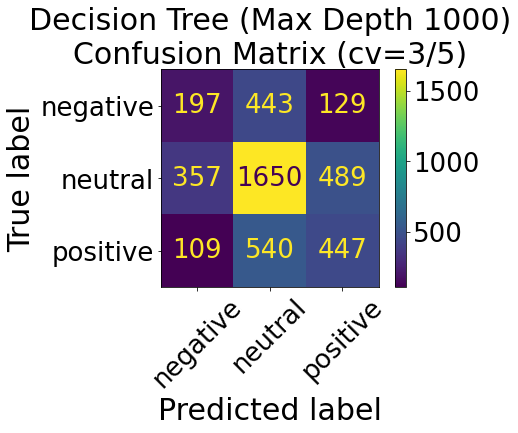

<Figure size 2304x1296 with 0 Axes>

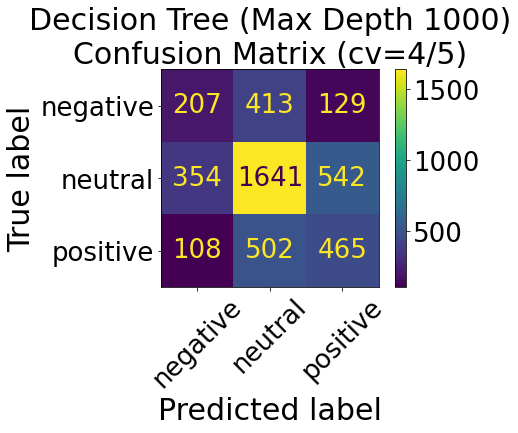

<Figure size 2304x1296 with 0 Axes>

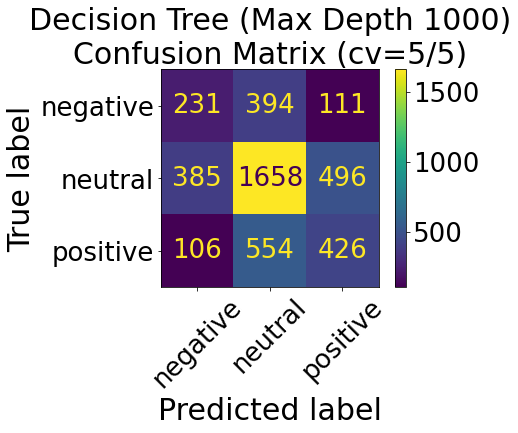

<Figure size 2304x1296 with 0 Axes>

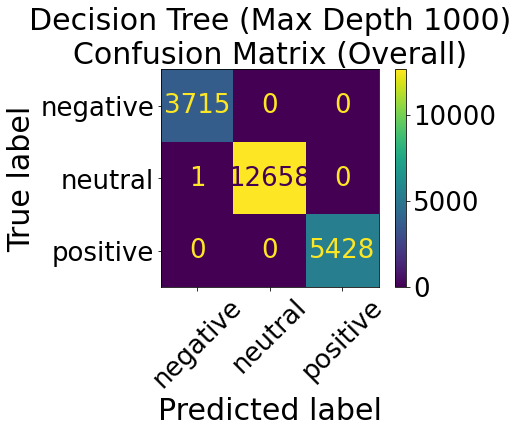

In [ ]:
# Default dt
dt = DecisionTreeClassifier()
dt_results = evaluate(dt, X_train, y, 'Decision Tree')

# dt with different max depths
dt_max_depth_1 = DecisionTreeClassifier(max_depth=1)
dt_max_depth_1_results = evaluate(dt_max_depth_1, X_train, y, 'Decision Tree (Max Depth 1)')
dt_max_depth_100 = DecisionTreeClassifier(max_depth=100)
dt_max_depth_100_results = evaluate(dt_max_depth_100, X_train, y, 'Decision Tree (Max Depth 100)')
dt_max_depth_1000 = DecisionTreeClassifier(max_depth=1000)
dt_max_depth_1000_results = evaluate(dt_max_depth_1000, X_train, y, 'Decision Tree (Max Depth 1000)')

### K Nearest Neighbours

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
              precision    recall  f1-score   support

    negative       0.22      0.22      0.22       711
     neutral       0.61      0.76      0.68      2571
    positive       0.39      0.16      0.23      1079

    accuracy                           0.52      4361
   macro avg       0.41      0.38      0.38      4361
weighted avg       0.49      0.52      0.49      4361

              precision    recall  f1-score   support

    negative       0.22      0.20      0.21       744
     neutral       0.60      0.76      0.67      2525
    positive       0.40      0.17      0.24      1092

    accuracy                           0.52      4361
   macro avg       0.41      0.38      0.37      4361
weighted avg       0.48      0.52      0.48      4361

              precision    recall  f1-score   support

    negative       0.22      0.21      0.22       735
     neutral       0.60      0.75      0.66      2541
    positi

C:\Users\Xavier Travers\AppData\Local\Temp\ipykernel_27384\324720599.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(32, 18))


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3715
     neutral       1.00      1.00      1.00     12659
    positive       1.00      1.00      1.00      5428

    accuracy                           1.00     21802
   macro avg       1.00      1.00      1.00     21802
weighted avg       1.00      1.00      1.00     21802

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       716
     neutral       0.58      1.00      0.74      2541
    positive       0.33      0.00      0.00      1104

    accuracy                           0.58      4361
   macro avg       0.31      0.33      0.25      4361
weighted avg       0.42      0.58      0.43      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       689
     neutral       0.59      1.00      0.74      2585
    positive       0.33      0.00      0.00      1087

    accuracy                           0.59      4361
   macro avg       0.31      0.33      0.25      4361
weighted avg       0.43      0.59      0.44      4361

              precision    recall  f1-score   support

    negative       1.00      0.00      0.01       722
     neutral       0.59      1.00      0.74      2558
    positive       0.40      0.00      0.01      1081

    accuracy                           0.59      4361
   macro avg       0.66      0.33      0.25      4361
weighted avg       0.61      0.59      0.44      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       719
     neutral       0.58      1.00      0.73      2531
    positive       0.60      0.00      0.01      1111

    accuracy                           0.58      4361
   macro avg       0.39      0.33      0.25      4361
weighted avg       0.49      0.58      0.43      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       733
     neutral       0.58      1.00      0.74      2548
    positive       0.50      0.00      0.01      1080

    accuracy                           0.58      4361
   macro avg       0.36      0.33      0.25      4361
weighted avg       0.47      0.58      0.43      4361

              precision    recall  f1-score   support

    negative       1.00      0.00      0.00      3715
     neutral       0.58      1.00      0.74     12659
    positive       0.65      0.01      0.01      5428

    accuracy                           0.58     21802
   macro avg       0.74      0.34      0.25     21802
weighted avg       0.67      0.58      0.43     21802

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       765
     neutral       0.58      1.00      0.73      2518
    positive       0.00      0.00      0.00      1078

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.58      0.42      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       746
     neutral       0.58      1.00      0.73      2519
    positive       0.00      0.00      0.00      1096

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.58      0.42      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       753
     neutral       0.58      1.00      0.73      2523
    positive       0.00      0.00      0.00      1085

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.58      0.42      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       743
     neutral       0.59      1.00      0.74      2577
    positive       0.00      0.00      0.00      1041

    accuracy                           0.59      4361
   macro avg       0.20      0.33      0.25      4361
weighted avg       0.35      0.59      0.44      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       743
     neutral       0.58      1.00      0.73      2533
    positive       0.00      0.00      0.00      1085

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.34      0.58      0.43      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      3715
     neutral       0.58      1.00      0.73     12659
    positive       0.00      0.00      0.00      5428

    accuracy                           0.58     21802
   macro avg       0.19      0.33      0.24     21802
weighted avg       0.34      0.58      0.43     21802



<Figure size 2304x1296 with 0 Axes>

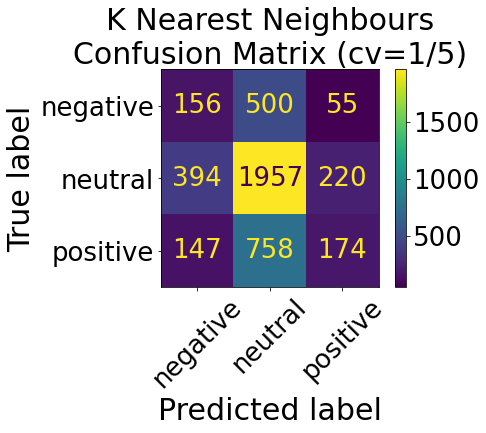

<Figure size 2304x1296 with 0 Axes>

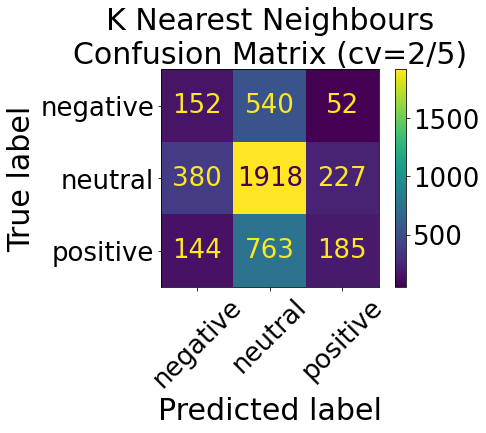

<Figure size 2304x1296 with 0 Axes>

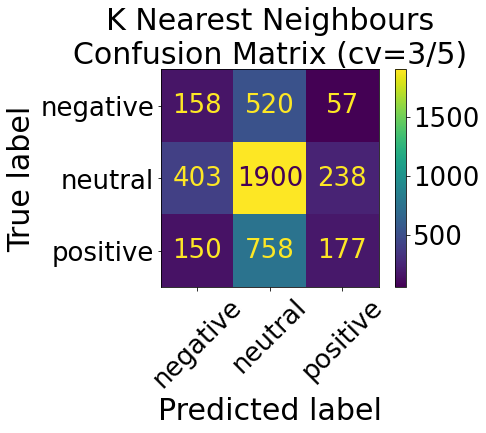

<Figure size 2304x1296 with 0 Axes>

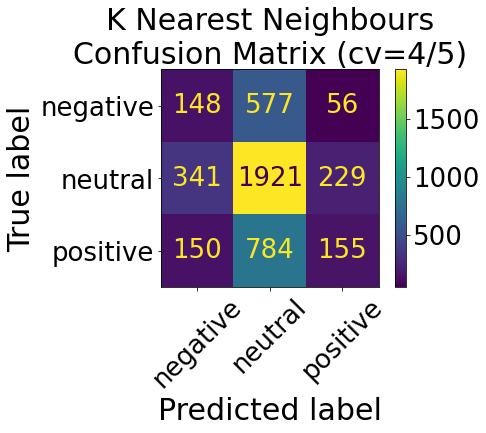

<Figure size 2304x1296 with 0 Axes>

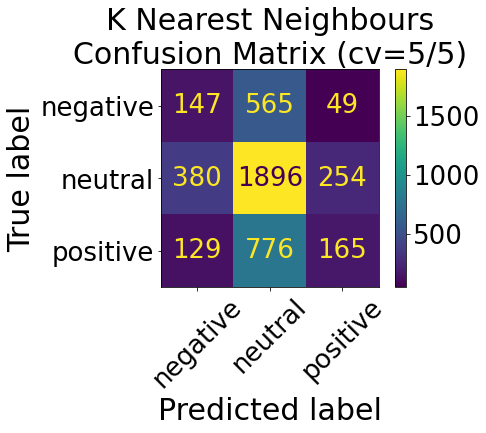

<Figure size 2304x1296 with 0 Axes>

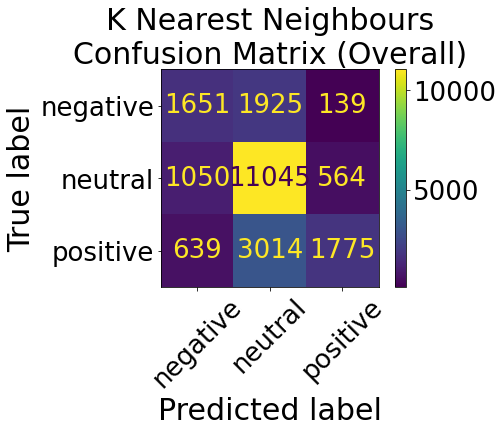

<Figure size 2304x1296 with 0 Axes>

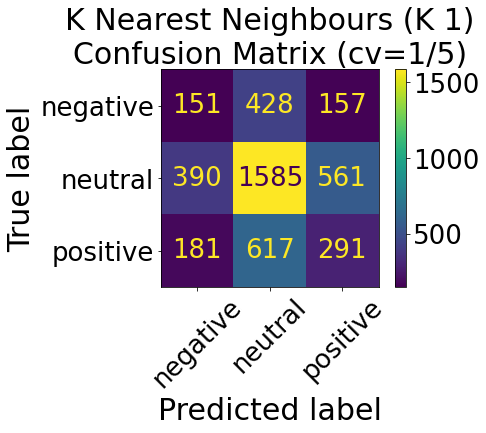

<Figure size 2304x1296 with 0 Axes>

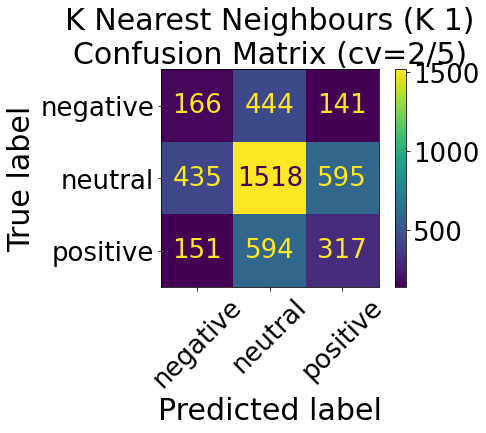

<Figure size 2304x1296 with 0 Axes>

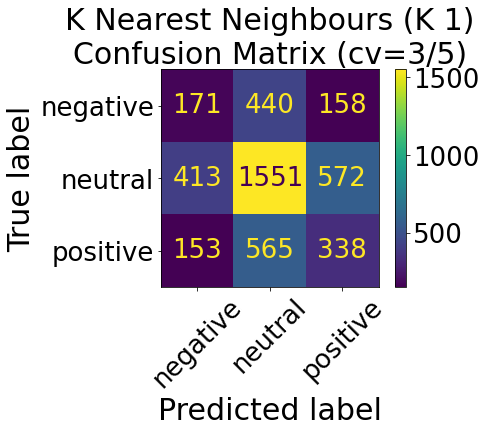

<Figure size 2304x1296 with 0 Axes>

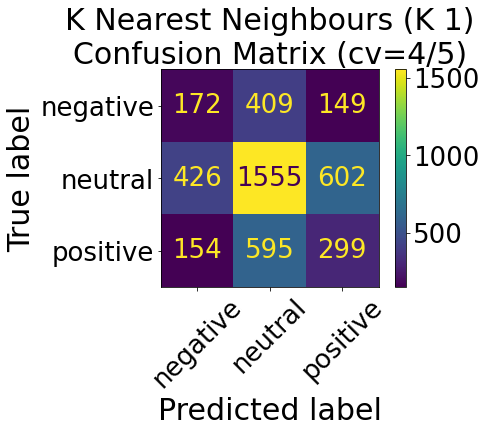

<Figure size 2304x1296 with 0 Axes>

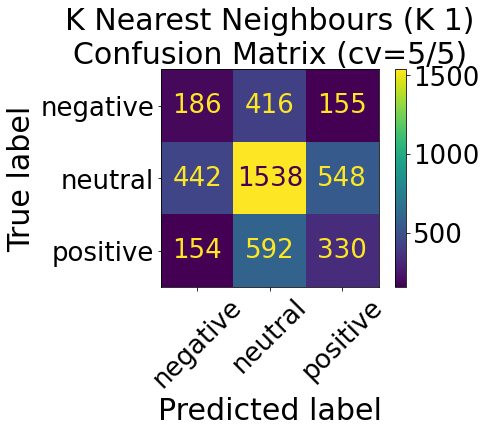

<Figure size 2304x1296 with 0 Axes>

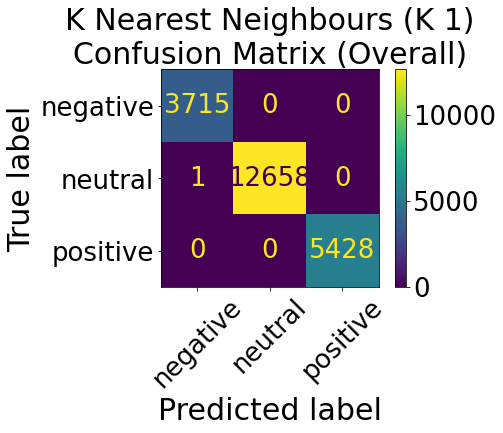

<Figure size 2304x1296 with 0 Axes>

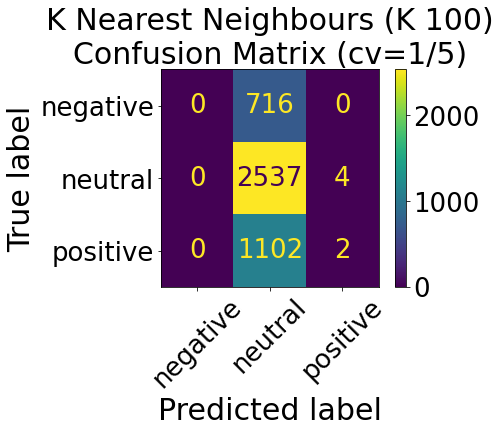

<Figure size 2304x1296 with 0 Axes>

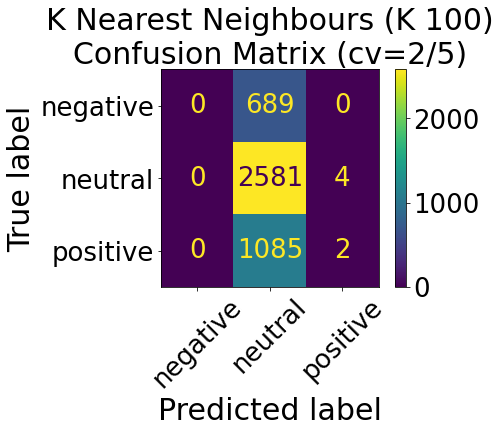

<Figure size 2304x1296 with 0 Axes>

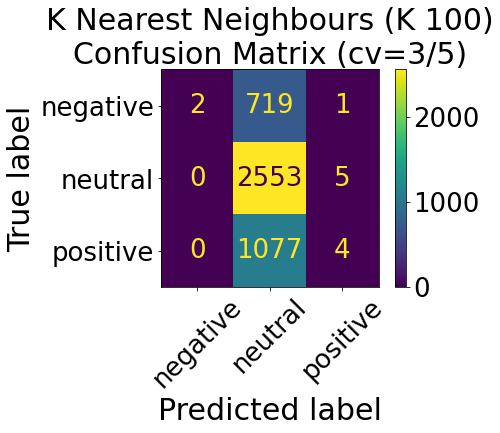

<Figure size 2304x1296 with 0 Axes>

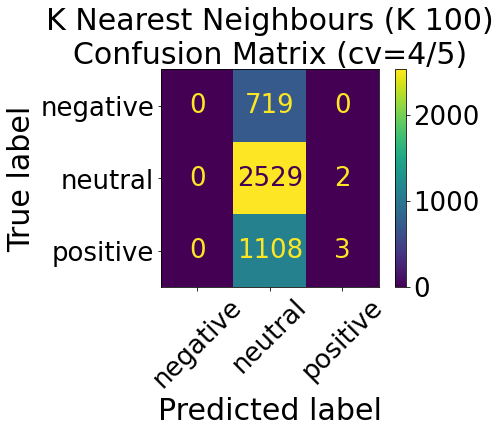

<Figure size 2304x1296 with 0 Axes>

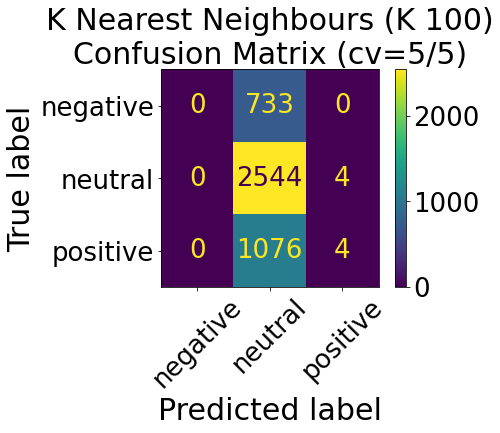

<Figure size 2304x1296 with 0 Axes>

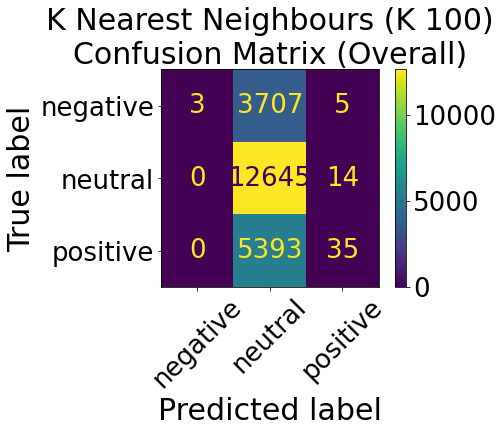

<Figure size 2304x1296 with 0 Axes>

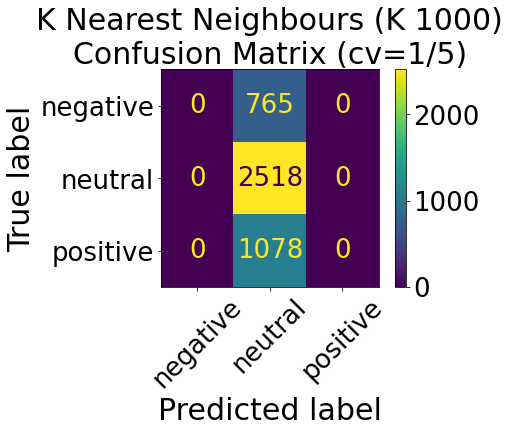

<Figure size 2304x1296 with 0 Axes>

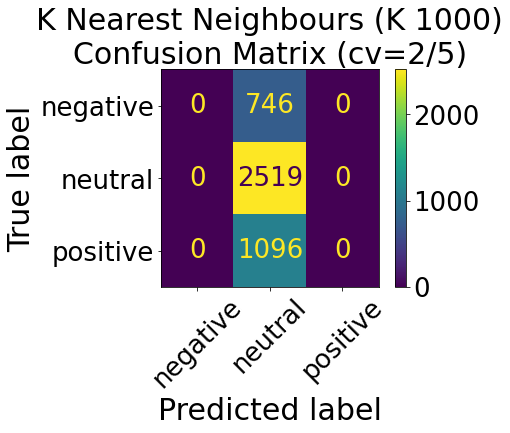

<Figure size 2304x1296 with 0 Axes>

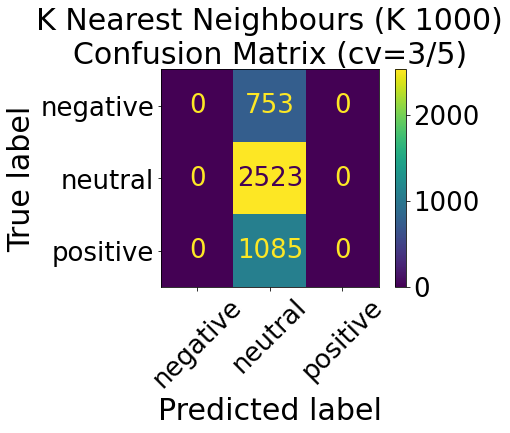

<Figure size 2304x1296 with 0 Axes>

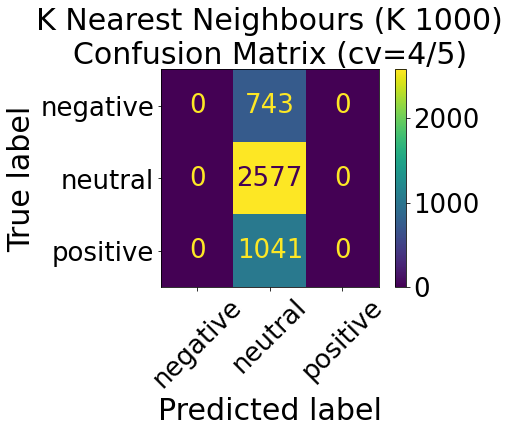

<Figure size 2304x1296 with 0 Axes>

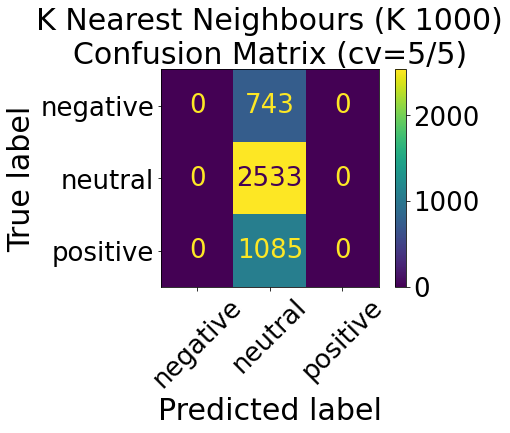

<Figure size 2304x1296 with 0 Axes>

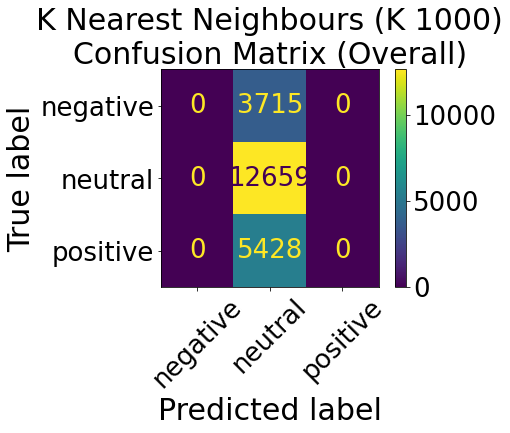

In [ ]:
# default KNN
knn = KNeighborsClassifier()
knn_results = evaluate(knn, X_train, y, 'K Nearest Neighbours')

# KNN with different n neighbours
knn_n_1 = KNeighborsClassifier(n_neighbors=1)
knn_n_1_results = evaluate(knn_n_1, X_train, y, 'K Nearest Neighbours (K 1)')
knn_n_100 = KNeighborsClassifier(n_neighbors=100)
knn_n_100_results = evaluate(knn_n_100, X_train, y, 'K Nearest Neighbours (K 100)')
knn_n_1000 = KNeighborsClassifier(n_neighbors=1000)
knn_n_1000_results = evaluate(knn_n_1000, X_train, y, 'K Nearest Neighbours (K 1000)')

### Support Vector Machine

In [ ]:
# default svm
svc = SVC()
svc_results = evaluate(svc, X_train, y, 'Support Vector Machine')

# KNN with different n neighbours
svc_linear = LinearSVC()
svc_linear_results = evaluate(svc_linear, X_train, y, 'Support Vector Machine (Linear)')
svc_poly_3 = SVC(kernel='poly', degree=3)
svc_poly_3_results = evaluate(svc_poly_3, X_train, y, 'Support Vector Machine (Cubic)')
svc_poly_10 = SVC(kernel='poly', degree=10)
svc_poly_10_results = evaluate(svc_poly_10, X_train, y, 'Support Vector Machine (Polynomial Degree 10)')

<class 'sklearn.svm._classes.SVC'>


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       734
     neutral       0.59      1.00      0.74      2555
    positive       0.00      0.00      0.00      1072

    accuracy                           0.59      4361
   macro avg       0.20      0.33      0.25      4361
weighted avg       0.34      0.59      0.43      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       738
     neutral       0.59      1.00      0.74      2563
    positive       0.00      0.00      0.00      1060

    accuracy                           0.59      4361
   macro avg       0.20      0.33      0.25      4361
weighted avg       0.35      0.59      0.44      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       757
     neutral       0.58      1.00      0.73      2523
    positive       0.00      0.00      0.00      1081

    accuracy                           0.58      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.58      0.42      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       735
     neutral       0.59      1.00      0.74      2557
    positive       0.00      0.00      0.00      1069

    accuracy                           0.59      4361
   macro avg       0.20      0.33      0.25      4361
weighted avg       0.34      0.59      0.43      4361



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       746
     neutral       0.59      1.00      0.74      2567
    positive       0.00      0.00      0.00      1048

    accuracy                           0.59      4361
   macro avg       0.20      0.33      0.25      4361
weighted avg       0.35      0.59      0.44      4361



### Bagging Classifiers

In [ ]:
# default bagging classifer
bc = BaggingClassifier()
bc_results = evaluate(bc, X_train, y, 'Bagging Classifier')

# bagging classifer with different bases
bc_mnb = BaggingClassifier(base_estimator=MultinomialNB())
bc_mnb_results = evaluate(bc_mnb, X_train, y, 'Bagging Classifier (Multinomial Naive Bayes)')
bc_bnb = BaggingClassifier(base_estimator=BernoulliNB())
bc_bnb_results = evaluate(bc_bnb, X_train, y, 'Bagging Classifier (Bernoulli Naive Bayes)')
bc_lr = BaggingClassifier(base_estimator=LogisticRegression())
bc_lr_results = evaluate(bc_lr, X_train, y, 'Bagging Classifier (Logistic Regression)')
bc_svc_linear = BaggingClassifier(base_estimator=LinearSVC())
bc_svc_linear_results = evaluate(bc_svc_linear, X_train, y, 'Bagging Classifier (Linear SVM)')

NameError: name 'BaggingClassifier' is not defined